In [1]:
# =================== CELDA 0 — CONFIG & HELPERS (REFactor propuesta) ===================
import os, sys, random, warnings, pathlib
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

################################################################################
# 1. Reproducibilidad total
################################################################################
def seed_everything(seed: int = 42):
    """
    Fija todas las semillas pseudoaleatorias que razonablemente controlamos:
    - Python `random`
    - Hash aleatorio de Python
    - NumPy
    - (opcional) PyTorch si está disponible
    
    Esto NO garantiza bitwise determinism en CUDA en todas las GPUs/drivers,
    pero elimina la aleatoriedad obvia de entrenamiento/inferencia.
    """
    import importlib

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # PyTorch es opcional: sólo si está instalado
    if importlib.util.find_spec("torch") is not None:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(False)  # True = más lento pero más determinista
        # Nota: cudnn.benchmark=False hace que convs sean deterministas-ish
        if torch.backends.cudnn.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

################################################################################
# 2. Estilo "Nature-ready" para TODAS las figuras
################################################################################
def set_nature_style():
    """
    Ajusta parámetros globales de Matplotlib/Seaborn para figuras tipo Nature:
    - tipografía sans-serif editable en Illustrator (fonttype=42)
    - tamaños de fuente consistentes con 'context="paper"'
    - ejes sin spines top/right
    - ticks hacia afuera
    - DPI alto por defecto
    """
    sns.set_theme(style="white", context="paper")
    mpl.rcParams.update({
        # texto editable en Illustrator / Affinity
        "pdf.fonttype": 42,
        "ps.fonttype": 42,

        # tipografía
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],

        # tamaños (en pt aprox)
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,

        # estética de ejes
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",

        # salida
        "figure.dpi": 300,
        "savefig.pad_inches": 0.02,
    })

set_nature_style()

################################################################################
# 3. Rutas y parámetros globales de la corrida
################################################################################
# Nota: respetamos valores previos si ya existen en el workspace interactivo.
if 'N_FOLDS' not in globals():      N_FOLDS = 5
if 'CLF' not in globals():          CLF = 'logreg'
if 'SUFFIX' not in globals():       SUFFIX = '_integrated_gradients_top50'
if 'CHANNELS_TO_USE' not in globals(): CHANNELS_TO_USE = [1, 2, 5]

if 'BASE_RUN_DIR' not in globals():
    BASE_RUN_DIR = Path('./resultados_13_paper_qc_beta2')

FIG_DIR = Path('./Figures_Nature')
TBL_DIR = Path('./Tables_Nature')
FIG_DIR.mkdir(exist_ok=True, parents=True)
TBL_DIR.mkdir(exist_ok=True, parents=True)

# rutas del tensor y metadata crudos de sujetos
if 'GLOBAL_TENSOR_PATH' not in globals():
    GLOBAL_TENSOR_PATH = (
        '/home/diego/Escritorio/limpio/'
        'AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_'
        'AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/'
        'GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_'
        'AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
    )

if 'METADATA_PATH' not in globals():
    METADATA_PATH = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv'

# un diccionario "config snapshot" bonito para loggear/guardar en Supplementary
RUN_CFG = {
    "SEED": SEED,
    "N_FOLDS": N_FOLDS,
    "CLF": CLF,
    "SUFFIX": SUFFIX,
    "CHANNELS_TO_USE": CHANNELS_TO_USE,
    "BASE_RUN_DIR": str(BASE_RUN_DIR),
    "GLOBAL_TENSOR_PATH": GLOBAL_TENSOR_PATH,
    "METADATA_PATH": METADATA_PATH,
    "FIG_DIR": str(FIG_DIR),
    "TBL_DIR": str(TBL_DIR),
}

################################################################################
# 4. Helper para guardar figuras en alta resolución listas para el paper
################################################################################
def savefig_nature(fig: mpl.figure.Figure,
                   path_no_ext,
                   dpi_png: int = 600,
                   transparent_png: bool = False,
                   extra_meta: dict | None = None):
    """
    Guarda dos versiones de la figura:
      - PDF (vectorial, texto editable) -> para Illustrator / submission
      - PNG (alta resolución)           -> para borradores / slides / supl.
    
    Parámetros
    ----------
    fig : matplotlib.figure.Figure
        Figura a guardar.
    path_no_ext : str | Path
        Ruta base SIN extensión. Se crearán .pdf y .png.
    dpi_png : int
        DPI para la versión PNG.
    transparent_png : bool
        Si True, el fondo del PNG es transparente.
    extra_meta : dict or None
        Metadatos adicionales para incrustar en el PDF.
    """
    p = pathlib.Path(path_no_ext)
    p.parent.mkdir(parents=True, exist_ok=True)

    meta_pdf = {
        "Creator": "Matplotlib",
        "Title": p.name,
        "CreationDate": datetime.now(),
    }
    if extra_meta:
        meta_pdf.update(extra_meta)

    # PDF vectorial
    fig.savefig(
        p.with_suffix(".pdf"),
        metadata=meta_pdf,
        bbox_inches="tight"
    )

    # PNG alta resolución (útil para tener un snapshot rápido)
    fig.savefig(
        p.with_suffix(".png"),
        dpi=dpi_png,
        transparent=transparent_png,
        metadata={"Creator": "Matplotlib"},
        bbox_inches="tight"
    )

################################################################################
# 5. Log de estado
################################################################################
print(">> CONFIG INICIAL")
for k, v in RUN_CFG.items():
    print(f"   {k}: {v}")
print("✔️  Setup gráfico y helpers cargados.\n")


# --- Silenciar logs verbosos de fontTools / tqdm en guardados PDF/SVG ---
import logging, os
logging.getLogger('fontTools').setLevel(logging.WARNING)
logging.getLogger('fontTools.subset').setLevel(logging.WARNING)
os.environ.setdefault("TQDM_DISABLE", "1")  # evita el warning de IProgress si no usas ipywidgets

# SVG con texto editable (no convierte a paths)
mpl.rcParams['svg.fonttype'] = 'none'



>> CONFIG INICIAL
   SEED: 42
   N_FOLDS: 5
   CLF: logreg
   SUFFIX: _integrated_gradients_top50
   CHANNELS_TO_USE: [1, 2, 5]
   BASE_RUN_DIR: resultados_13_paper_qc_beta2
   GLOBAL_TENSOR_PATH: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
   METADATA_PATH: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv
   FIG_DIR: Figures_Nature
   TBL_DIR: Tables_Nature
✔️  Setup gráfico y helpers cargados.



In [2]:
# === CARGA MAESTRA (usar una sola vez) ===
_npz = np.load(GLOBAL_TENSOR_PATH)
global_tensor_data = _npz["global_tensor_data"]              # [n_subj, 7, 131, 131]
subject_ids_all   = _npz["subject_ids"].astype(str)

meta = pd.read_csv(METADATA_PATH)
meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()

idx_df = pd.DataFrame({"SubjectID": subject_ids_all, "tensor_idx": np.arange(len(subject_ids_all))})
cnad_df = (idx_df.merge(meta, on="SubjectID", how="left")
                 .query("ResearchGroup_Mapped in ['CN','AD']").reset_index(drop=True))

print(f"✅ cnad_df listo: {cnad_df.shape[0]} sujetos AD/CN")


✅ cnad_df listo: 184 sujetos AD/CN


In [3]:
cnad_df = cnad_df.copy()

# Normalize Sex to {'M','F'} if it's encoded numeric or lowercase
if 'Sex' in cnad_df.columns:
    cnad_df['Sex'] = (
        cnad_df['Sex']
        .replace({0:'M', 1:'F', 'm':'M', 'f':'F'})
        .astype(str)
        .str.upper()
    )

# Make sure Age is numeric
if 'Age' in cnad_df.columns:
    cnad_df['Age'] = pd.to_numeric(cnad_df['Age'], errors='coerce')


In [4]:
# ===================================================================
# CELDA 1: CANALES (coherentes con tu CLI: --channels_to_use 1 2 5)
# ===================================================================
CHANNEL_CATALOG = {
    0: "Pearson_OMST_GCE_Signed_Weighted",
    1: "Pearson_Full_FisherZ_Signed",
    2: "MI_kNN_Symmetric",
    3: "dFC_AbsDiffMean",
    4: "dFC_StdDev",
    5: "DistanceCorr",
    6: "Granger_F_lag1",
}
CHANNELS_TO_USE = [1, 2, 5]
sel_names = [CHANNEL_CATALOG[c] for c in CHANNELS_TO_USE]
print("[Canales]", CHANNELS_TO_USE, "=>", sel_names)

# Para el paper: C debe ser 3 (no 4) y nombres como arriba.


[Canales] [1, 2, 5] => ['Pearson_Full_FisherZ_Signed', 'MI_kNN_Symmetric', 'DistanceCorr']


In [5]:
# ===================================================================
# CELDA 2 (UNIFICADA): CARGA DE RANKINGS Y CREACIÓN DE ID CANÓNICO
# ===================================================================
all_folds = []
for i in range(1, N_FOLDS + 1):
    path = BASE_RUN_DIR / f"fold_{i}/interpretability_{CLF}/ranking_conexiones_ANOTADO{SUFFIX}.csv"
    if not path.exists():
        print(f"⚠️ Falta fold {i}: {path}")
        continue
    df_i = pd.read_csv(path)
    
    # --- Lógica de la Celda 2bis integrada aquí ---
    # Crear un ID canónico (tupla ordenada) para cada conexión
    df_i["connection_id"] = [tuple(sorted(x)) for x in zip(df_i["src_AAL3_Name"], df_i["dst_AAL3_Name"])]
    df_i["fold"] = i
    all_folds.append(df_i)

if not all_folds:
    raise FileNotFoundError("No se encontró ningún ranking de conexiones.")

# Concatenar todos los dataframes en uno solo
df_full = pd.concat(all_folds, ignore_index=True)

# --- Verificación de la Celda 2bis integrada aquí ---
assert "connection_id" in df_full.columns
assert df_full["connection_id"].map(type).eq(tuple).all(), "La columna 'connection_id' DEBE ser una tupla."

print(f"✅ df_full cargado y preprocesado con {df_full['fold'].nunique()} folds y {len(df_full)} filas.")
print(f"   - Cada conexión tiene un 'connection_id' canónico.")

✅ df_full cargado y preprocesado con 5 folds y 42575 filas.
   - Cada conexión tiene un 'connection_id' canónico.


In [6]:
# ===================================================================
# CELDA 3 (UNIFICADA): ANÁLISIS DE ESTABILIDAD Y LATERALIDAD (CORREGIDA)
# ===================================================================
from collections import Counter
from scipy.stats import t

# --- 1. ESTABILIDAD: Cálculo de π (frecuencia) y τ (consistencia de signo) ---
TOP_K_STABILITY = 200
n_folds = df_full['fold'].nunique()

top_sets = df_full[df_full["Rank"] <= TOP_K_STABILITY].groupby("fold")["connection_id"].apply(set)
pi = pd.Series(Counter(e for s in top_sets for e in s)).div(n_folds)
pi.name = "pi"

# Use 'Saliency_Signed' which exists in your CSV files
sign = np.sign(df_full.set_index(["connection_id", "fold"])["Saliency_Signed"]).unstack() # <-- CORREGIDO
tau = sign.mean(axis=1).abs()
tau.name = "tau"

df_stability = pd.concat([pi, tau], axis=1).fillna({"pi": 0.0})
df_stability["Signed"] = df_stability["pi"] * df_stability["tau"]

# --- 2. CONSENSUS SET: Filtrado por umbrales estrictos ---
CONS_PI, CONS_TAU = 0.6, 0.6
consensus_set = df_stability.query("pi >= @CONS_PI and tau >= @CONS_TAU").sort_values("Signed", ascending=False)
print(f"🔎 Consensus Set: {len(consensus_set)} aristas (π ≥ {CONS_PI}, τ ≥ {CONS_TAU})")
display(consensus_set.head(10))


# --- 3. LATERALIDAD: Preparación de datos para la figura ---
midline_tokens = {'VER','VPL','PAG','NCR','tVPL','VER7','VER8','VER9'}

def hemi_of(roi: str) -> str:
    if not isinstance(roi, str): return 'U'
    if roi.endswith('R'): return 'R'
    if roi.endswith('L'): return 'L'
    base = ''.join([c for c in roi if not c.isdigit()])
    return 'M' if any(t in base for t in midline_tokens) else 'U'

df_full['hemi_src'] = df_full['src_AAL3_Name'].map(hemi_of)
df_full['hemi_dst'] = df_full['dst_AAL3_Name'].map(hemi_of)
df_lat_clean = df_full.query("hemi_src in ['L','R'] and hemi_dst in ['L','R']").copy()
print(f"\n✅ Conexiones de línea media filtradas para análisis de lateralidad: {len(df_lat_clean)} restantes.")

def p_rr_by_fold(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    out = []
    for f, g in top.groupby("fold", observed=True):
        rr = (g["hemi_src"] == "R").sum()
        ll = (g["hemi_src"] == "L").sum()
        n  = rr + ll
        out.append({"fold": int(f), "TopK": K, "p_RR": (rr / n) if n > 0 else np.nan})
    return pd.DataFrame(out)

df_lat_plot = pd.concat(
    [p_rr_by_fold(df_lat_clean, K) for K in (50, 100, 200)], 
    ignore_index=True
)
print("✅ DataFrame 'df_lat_plot' para figura de lateralidad creado exitosamente.")

# --- 4. PREPARAR DATOS PARA CELDAS DE VISUALIZACIÓN POSTERIORES ---
# Recrea el diccionario 'all_fold_edges' para la figura "small-multiples"
all_fold_edges = {fold: data.set_index('connection_id') for fold, data in df_full.groupby('fold')}

# Recrea 'df_all_Signeds' para la figura "dotplot"
df_all_scores = df_full.pivot_table(
    index='connection_id', 
    columns='fold', 
    values='Saliency_Signed'  # <-- CORREGIDO
).rename(columns=lambda c: f'saliency_fold_{c}')

print("✅ Variables auxiliares 'all_fold_edges' y 'df_all_scores' creadas para las figuras.")

🔎 Consensus Set: 10 aristas (π ≥ 0.6, τ ≥ 0.6)


pi  tau  Signed
CER9L    OFCLATR  0.6  1.0    0.60
SMAR     VER7     0.6  1.0    0.60
T3R      VER7     0.6  1.0    0.60
CERCRU2R OFCLATR  0.6  0.6    0.36
O1L      VER6     0.6  0.6    0.36
FMR      O3R      0.6  0.6    0.36
CERCRU1R OFCLATR  0.6  0.6    0.36
CER3R    OFCLATR  0.6  0.6    0.36
ORR      VER6     0.6  0.6    0.36
OFCLATR  T1AR     0.6  0.6    0.36


✅ Conexiones de línea media filtradas para análisis de lateralidad: 38130 restantes.
✅ DataFrame 'df_lat_plot' para figura de lateralidad creado exitosamente.
✅ Variables auxiliares 'all_fold_edges' y 'df_all_scores' creadas para las figuras.


In [7]:
# =================== CELDA 4 — PREP DATOS Y CONFIG DE MODELO ===================

import torch
import numpy as np
import pandas as pd

# 1. Asegurar canales y clasificador (solo si aún no existen)
if 'CHANNELS_TO_USE' not in globals():
    CHANNELS_TO_USE = [1, 2, 5]

if 'CLF' not in globals():
    CLF = 'logreg'

# 2. Cargar tensor global una sola vez
_npz = np.load(GLOBAL_TENSOR_PATH)
global_tensor_data = _npz["global_tensor_data"]              # [n_subj, n_channels_total, R, R]
subject_ids_all   = _npz["subject_ids"].astype(str)

# 3. Construir dataframe maestro de sujetos CN/AD con índice al tensor
meta = pd.read_csv(METADATA_PATH)
meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()

idx_df = pd.DataFrame({
    "SubjectID": subject_ids_all,
    "tensor_idx": np.arange(len(subject_ids_all))
})

cnad_df = (
    idx_df
    .merge(meta, on="SubjectID", how="left")
    .query("ResearchGroup_Mapped in ['CN', 'AD']")
    .reset_index(drop=True)
)

# 4. Config del modelo VAE + features demográficas que alimentan al clasificador
MODEL_CFG = {
    "channels_to_use": CHANNELS_TO_USE,
    "latent_dim": 512,
    "num_conv_layers_encoder": 4,
    "decoder_type": "convtranspose",
    "vae_final_activation": "tanh",
    "intermediate_fc_dim_vae": "quarter",
    "dropout_rate_vae": 0.2,
    "use_layernorm_vae_fc": False,
    "metadata_features": ["Age", "Sex"],
}

# 5. Dispositivo de PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 6. Pequeño log de control
print("✅ Datos preparados:")
print(f"   - cnad_df: {cnad_df.shape[0]} sujetos CN/AD con tensor_idx alineado")
print(f"   - global_tensor_data shape: {global_tensor_data.shape}")
print(f"   - CHANNELS_TO_USE: {CHANNELS_TO_USE}")
print(f"   - device: {device}")
print("✅ MODEL_CFG listo (hiperparámetros del VAE + covariables demográficas).")


✅ Datos preparados:
   - cnad_df: 184 sujetos CN/AD con tensor_idx alineado
   - global_tensor_data shape: (431, 7, 131, 131)
   - CHANNELS_TO_USE: [1, 2, 5]
   - device: cuda
✅ MODEL_CFG listo (hiperparámetros del VAE + covariables demográficas).


In [8]:
npz = np.load(GLOBAL_TENSOR_PATH)
tensor_all = npz["global_tensor_data"][:, CHANNELS_TO_USE, :, :]  # [n_subj, n_chan_sel, R, R]
subj_all_ids = pd.Series(npz["subject_ids"].astype(str), name="SubjectID")

meta = pd.read_csv(METADATA_PATH)
meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()

idx_df = pd.DataFrame({
    "SubjectID": subj_all_ids,
    "tensor_idx": np.arange(len(subj_all_ids))
})

cnad_df = (
    idx_df
    .merge(meta, on="SubjectID", how="left")
    .query("ResearchGroup_Mapped in ['CN', 'AD']")
    .reset_index(drop=True)
)


In [9]:
run_args = {
    "channels_to_use": [1, 2, 5],
    "latent_dim": 512,
    "num_conv_layers_encoder": 4,
    "decoder_type": "convtranspose",
    "vae_final_activation": "tanh",
    "intermediate_fc_dim_vae": "quarter",
    "dropout_rate_vae": 0.2,
    "use_layernorm_vae_fc": False,
    "metadata_features": ["Age", "Sex"],
}
print("✅ run_args reconstruido:", run_args)


✅ run_args reconstruido: {'channels_to_use': [1, 2, 5], 'latent_dim': 512, 'num_conv_layers_encoder': 4, 'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh', 'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2, 'use_layernorm_vae_fc': False, 'metadata_features': ['Age', 'Sex']}


In [10]:
# === Normaliza nombres de canal para las barras ===
name_map = {
    'Ch1': 'Pearson_Full_FisherZ_Signed',
    'Ch2': 'MI_kNN_Symmetric',
    'Ch5': 'DistanceCorr'
}
if 'df_contributions_all_folds' in globals():
    df_contributions_all_folds['channel_name'] = (
        df_contributions_all_folds['channel_name'].replace(name_map)
    )


/home/diego/anaconda3/envs/serentipia_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[INFO] [cuML] ➜ no disponible
[INFO] Usando dispositivo: cuda


¿GPU visible?: True
torch.cuda.is_available -> True
torch.version.cuda      -> 12.1
cupy GPU visible        -> True
¿GPU visible?: True


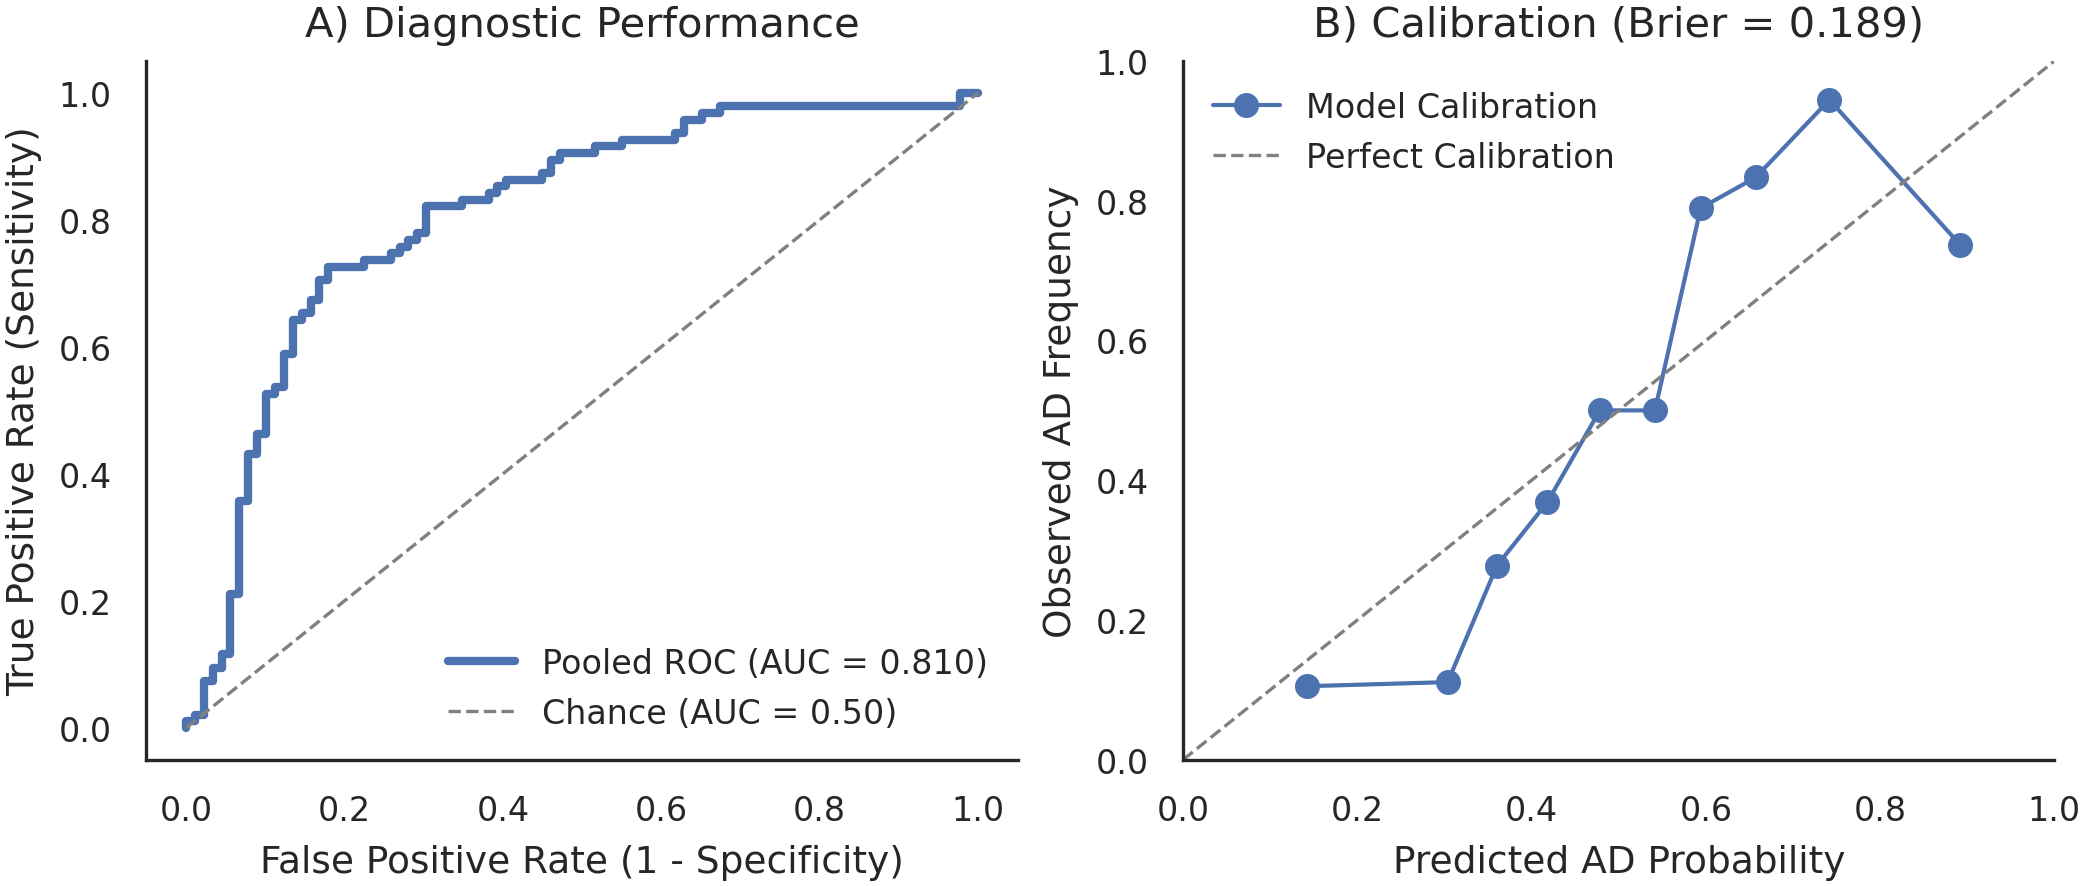

In [11]:
import torch, joblib
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import (
    roc_curve, roc_auc_score, brier_score_loss,
    accuracy_score, recall_score, average_precision_score
)
from sklearn.calibration import calibration_curve
from scipy.stats import t
import matplotlib.pyplot as plt

from serentipia9_qc_beta import apply_normalization_params
from models.convolutional_vae2 import ConvolutionalVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- sanity ---
assert 'cnad_df' in globals()
assert 'run_args' in globals()
assert 'CHANNELS_TO_USE' in globals()
assert 'N_FOLDS' in globals() and 'CLF' in globals()
assert 'global_tensor_data' in globals() or 'GLOBAL_TENSOR_PATH' in globals()



# 1. índices train/test por fold
fold_indices = {}
all_indices = np.arange(len(cnad_df))
for f in range(1, N_FOLDS + 1):
    test_idx_path = BASE_RUN_DIR / f"fold_{f}" / "test_indices.npy"
    test_idx = np.load(test_idx_path)
    train_idx = np.setdiff1d(all_indices, test_idx, assume_unique=True)
    fold_indices[f] = {'train': train_idx, 'test': test_idx}

perf_rows = []

for f in range(1, N_FOLDS + 1):
    fold_dir = BASE_RUN_DIR / f"fold_{f}"

    # clasificador entrenado en ese fold
    pipe = joblib.load(fold_dir / f"classifier_{CLF}_pipeline_fold_{f}.joblib")

    # VAE del fold
    vae_model = ConvolutionalVAE(
        input_channels=len(run_args['channels_to_use']),
        latent_dim=run_args['latent_dim'],
        image_size=global_tensor_data.shape[-1],  # 131
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'],
        use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)

    vae_model.load_state_dict(
        torch.load(fold_dir / f"vae_model_fold_{f}.pt", map_location=device)
    )
    vae_model.eval()

    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

    train_idx_fold = fold_indices[f]['train']
    test_idx_fold  = fold_indices[f]['test']

    df_train_fold = cnad_df.iloc[train_idx_fold].copy()
    df_test_fold  = cnad_df.iloc[test_idx_fold].copy()

    # etiquetas reales AD=1 / CN=0
    y_true_fold = df_test_fold['ResearchGroup_Mapped'].map({'CN':0,'AD':1}).values

    # ----- paso tensor -> normalización -> mu(latente) -----
    gidx_test = df_test_fold['tensor_idx'].values
    tensor_test_orig = global_tensor_data[gidx_test][:, CHANNELS_TO_USE, :, :]
    tensor_test_norm = apply_normalization_params(tensor_test_orig, norm_params)

    with torch.no_grad():
        tensor_torch = torch.from_numpy(tensor_test_norm).float().to(device)
        mu, _ = vae_model.encode(tensor_torch)    # mean latent code
        X_latent_test = mu.cpu().numpy()

    # ----- metadata (Age, Sex, etc) con imputación aprendida en TRAIN -----
    meta_cols = run_args['metadata_features']  # ej ['Age','Sex']
    # aprender imputación usando SOLO train
    metadata_train = df_train_fold[meta_cols].copy()
    if 'Sex' in metadata_train.columns:
        metadata_train['Sex'] = metadata_train['Sex'].map({'M':0,'F':1,'m':0,'f':1})

    imputation_values = {}
    for col in meta_cols:
        if metadata_train[col].isnull().any():
            if pd.api.types.is_numeric_dtype(metadata_train[col]) and metadata_train[col].nunique() > 2:
                imputation_values[col] = metadata_train[col].mean()
            else:
                imputation_values[col] = metadata_train[col].mode().iloc[0]
        else:
            imputation_values[col] = None

    metadata_test = df_test_fold[meta_cols].copy()
    if 'Sex' in metadata_test.columns:
        metadata_test['Sex'] = metadata_test['Sex'].map({'M':0,'F':1,'m':0,'f':1})

    for col, val in imputation_values.items():
        if val is not None:
            metadata_test[col].fillna(val, inplace=True)
        if metadata_test[col].isnull().any():
            metadata_test[col].fillna(-1, inplace=True)  # fallback

    # ----- concatenar latente + metadata -----
    X_test_combined = np.hstack([X_latent_test, metadata_test[meta_cols].values])

    # sanity de dimensiones
    expected_features = pipe.named_steps['scaler'].n_features_in_
    assert X_test_combined.shape[1] == expected_features, \
        f"Fold {f}: shape mismatch ({X_test_combined.shape[1]} vs {expected_features})"

    # ----- inferencia -----
    y_prob_fold = pipe.predict_proba(X_test_combined)[:,1]
    y_pred_fold = (y_prob_fold >= 0.5).astype(int)

    perf_rows.append(pd.DataFrame({
        'fold': f,
        'SubjectID': df_test_fold['SubjectID'].values,
        'tensor_idx': gidx_test,
        'y_true': y_true_fold,
        'y_prob': y_prob_fold,
        'y_pred': y_pred_fold
    }))

# juntamos
perf_df = pd.concat(perf_rows, ignore_index=True)

# métricas por fold
metrics_list = []
for f, g in perf_df.groupby('fold'):
    y_true_f = g['y_true'].astype(int).to_numpy()
    y_prob_f = g['y_prob'].astype(float).to_numpy()
    y_hat_f  = (y_prob_f >= 0.5).astype(int)

    auc_f    = roc_auc_score(y_true_f, y_prob_f) if np.unique(y_true_f).size>1 else np.nan
    pr_auc_f = average_precision_score(y_true_f, y_prob_f) if np.unique(y_true_f).size>1 else np.nan
    acc_f    = accuracy_score(y_true_f, y_hat_f)
    brier_f  = brier_score_loss(y_true_f, y_prob_f)
    sens_f   = recall_score(y_true_f, y_hat_f, pos_label=1, zero_division=0)
    spec_f   = recall_score(y_true_f, y_hat_f, pos_label=0, zero_division=0)

    metrics_list.append({
        "fold": f,
        "AUC": auc_f,
        "PR-AUC": pr_auc_f,
        "Accuracy": acc_f,
        "Brier": brier_f,
        "Sensitivity_AD": sens_f,
        "Specificity_CN": spec_f,
        "N_test": len(g),
    })

metrics_by_fold = pd.DataFrame(metrics_list).sort_values("fold").reset_index(drop=True)

# fila resumen mean ± sd
def _mean_sd_str(x):
    x = np.asarray(x, dtype=float)
    mean = np.nanmean(x)
    std = np.nanstd(x, ddof=1)
    return f"{mean:.3f} ± {std:.3f}" if not np.isnan(mean) else "N/A"

summary_row = {
    "fold": "mean±sd",
    "AUC": _mean_sd_str(metrics_by_fold["AUC"]),
    "PR-AUC": _mean_sd_str(metrics_by_fold["PR-AUC"]),
    "Accuracy": _mean_sd_str(metrics_by_fold["Accuracy"]),
    "Brier": _mean_sd_str(metrics_by_fold["Brier"]),
    "Sensitivity_AD": _mean_sd_str(metrics_by_fold["Sensitivity_AD"]),
    "Specificity_CN": _mean_sd_str(metrics_by_fold["Specificity_CN"]),
    "N_test": int(metrics_by_fold["N_test"].mean()),
}
table1_export = pd.concat([metrics_by_fold, pd.DataFrame([summary_row])], ignore_index=True)

# guardar tabla
table1_csv_path = TBL_DIR / "Table1_performance_byfold.csv"
table1_export.to_csv(table1_csv_path, index=False)

# curvas ROC + calibración pooling todos los folds
y_true_all = perf_df['y_true'].astype(int).to_numpy()
y_prob_all = perf_df['y_prob'].astype(float).to_numpy()

fpr, tpr, _ = roc_curve(y_true_all, y_prob_all, pos_label=1)
auc_all   = roc_auc_score(y_true_all, y_prob_all)
brier_all = brier_score_loss(y_true_all, y_prob_all)
frac_pos, mean_pred = calibration_curve(y_true_all, y_prob_all, n_bins=10, strategy='quantile')

fig, axs = plt.subplots(1,2, figsize=(7,3), constrained_layout=True)

# ROC
axs[0].plot(fpr, tpr, lw=2, label=f"Pooled ROC (AUC = {auc_all:.3f})")
axs[0].plot([0,1],[0,1],'--',c='gray',lw=0.8,label="Chance (AUC = 0.50)")
axs[0].set_xlabel("False Positive Rate (1 - Specificity)")
axs[0].set_ylabel("True Positive Rate (Sensitivity)")
axs[0].set_title("A) Diagnostic Performance")
axs[0].legend(frameon=False, fontsize=8, loc="lower right")

# Calibración
axs[1].plot(mean_pred, frac_pos, marker='o', lw=1, ms=5, label="Model Calibration")
axs[1].plot([0,1],[0,1],'--',c='gray',lw=0.8,label="Perfect Calibration")
axs[1].set_xlabel("Predicted AD Probability")
axs[1].set_ylabel("Observed AD Frequency")
axs[1].set_title(f"B) Calibration (Brier = {brier_all:.3f})")
axs[1].set_xlim(0,1); axs[1].set_ylim(0,1)
axs[1].legend(frameon=False, fontsize=8, loc="upper left")

savefig_nature(fig, FIG_DIR / "fig1_perf_calibration")
plt.show()


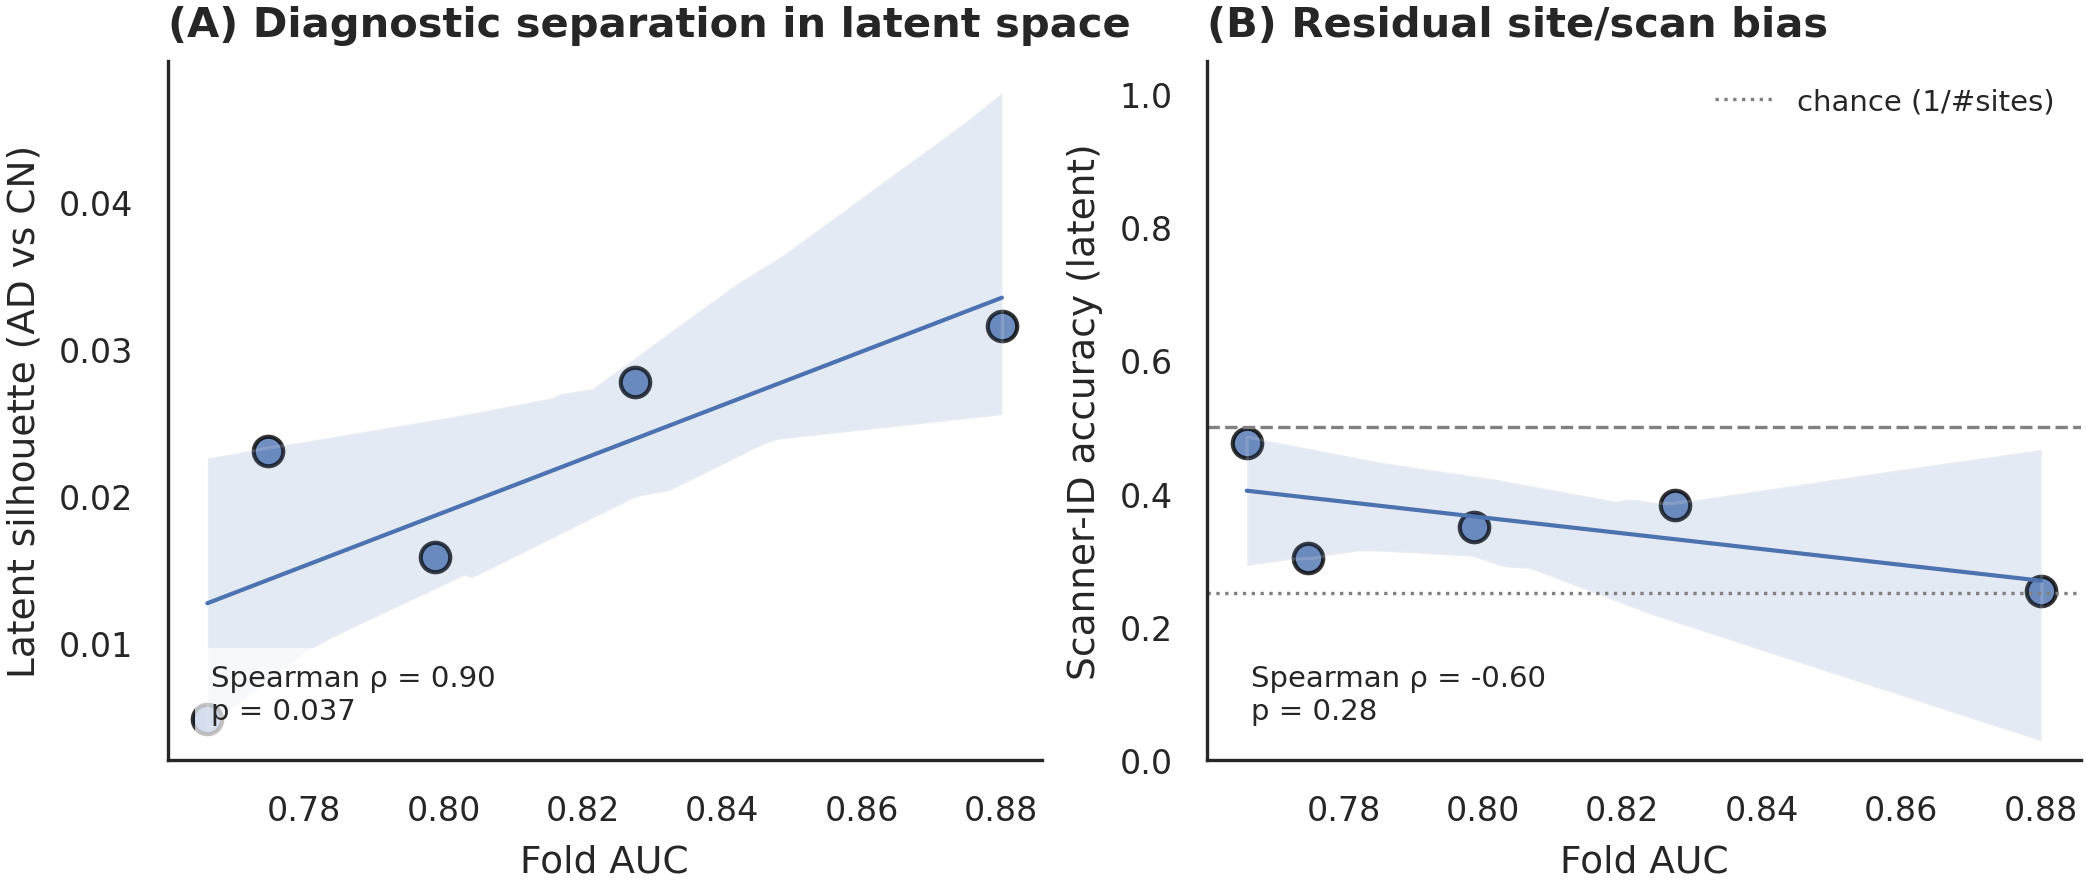

In [12]:
# ============================================================
# CELDA B — DISENTANGLEMENT / QC LATENTE (Fig 2A-2B)
# ============================================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import spearmanr

assert 'metrics_by_fold' in globals(), "Corre Celda A primero (metrics_by_fold)."

def _standardize_qc_cols(df_in: pd.DataFrame) -> pd.DataFrame:
    """Mapea columnas heterogéneas a nombres estándar:
       - silhouette_latent
       - acc_site_latent
       - acc_site_raw
       - n_sites
    """
    df = df_in.copy()
    colmap = {}

    # silhouette_latent
    if 'silhouette_latent' not in df.columns:
        for c in df.columns:
            cl = c.lower()
            if 'silhouette' in cl and ('latent' in cl or 'zspace' in cl or 'mu' in cl):
                colmap[c] = 'silhouette_latent'
                break

    # acc_site_latent
    if 'acc_site_latent' not in df.columns:
        for c in df.columns:
            cl = c.lower()
            if ('acc' in cl or 'accuracy' in cl) and ('site' in cl or 'scanner' in cl) and ('latent' in cl or 'mu' in cl or 'z' in cl):
                colmap[c] = 'acc_site_latent'
                break
        if 'site_leak_latent_acc' in df.columns:
            colmap['site_leak_latent_acc'] = 'acc_site_latent'

    # acc_site_raw
    if 'acc_site_raw' not in df.columns:
        for c in df.columns:
            cl = c.lower()
            if ('acc' in cl or 'accuracy' in cl) and ('site' in cl or 'scanner' in cl) and ('raw' in cl or 'orig' in cl or 'pre' in cl):
                colmap[c] = 'acc_site_raw'
                break

    # n_sites
    if 'n_sites' not in df.columns:
        for c in df.columns:
            cl = c.lower()
            if 'n_sites' in cl or ('sites' in cl and ('n_' in cl or 'num' in cl or 'count' in cl)):
                colmap[c] = 'n_sites'
                break
            if cl in ['n_sites_test','num_sites_test','site_count_test']:
                colmap[c] = 'n_sites'
                break

    df = df.rename(columns=colmap)
    return df

def _load_fold_qc(fold: int) -> pd.DataFrame:
    qc_dir = BASE_RUN_DIR / f"fold_{fold}"
    # Candidatos explícitos:
    qc_candidates = [
        qc_dir / "latent_qc_metrics.csv",
        qc_dir / "qc_latent_metrics.csv",
        qc_dir / f"latent_qc_fold_{fold}.csv",
        qc_dir / f"{CLF}_latent_qc_metrics.csv",
    ]
    # También glob por si cambió el nombre
    qc_candidates.extend(list(qc_dir.glob("*latent*qc*.csv")))
    qc_candidates.extend(list(qc_dir.glob("*qc*latent*.csv")))

    for p in qc_candidates:
        if p.exists():
            tmp = pd.read_csv(p)
            tmp['fold'] = fold
            return _standardize_qc_cols(tmp)

    print(f"⚠️ No encontré QC latente para fold {fold}")
    return pd.DataFrame({"fold":[fold]})

qc_rows = []
for f in range(1, N_FOLDS + 1):
    qc_rows.append(_load_fold_qc(f))
df_qc_all = pd.concat(qc_rows, ignore_index=True)

# merge con AUC por fold
df_qc_summary = pd.merge(
    metrics_by_fold[['fold','AUC']],
    df_qc_all,
    how='left',
    on='fold'
)

# chance-level para predecir sitio = 1 / (#sites)
if 'n_sites' in df_qc_summary.columns:
    df_qc_summary['chance_level'] = 1.0 / df_qc_summary['n_sites'].replace(0, np.nan)
else:
    df_qc_summary['chance_level'] = np.nan

# === FIG 2: si faltan métricas QC, no crashea y lo indica en la figura ===
fig, axs = plt.subplots(1, 2, figsize=(7,3), constrained_layout=True)

# Panel 2A
if 'silhouette_latent' in df_qc_summary.columns and df_qc_summary['silhouette_latent'].notna().any():
    sns.regplot(data=df_qc_summary, x="AUC", y="silhouette_latent",
                ax=axs[0], scatter_kws={"s":50,"edgecolor":"black","alpha":0.8}, line_kws={"lw":1})
    from scipy.stats import spearmanr
    rho_sil, p_sil = spearmanr(df_qc_summary["AUC"], df_qc_summary["silhouette_latent"], nan_policy='omit')
    axs[0].text(0.05, 0.05, f"Spearman ρ = {rho_sil:.2f}\np = {p_sil:.2g}",
                transform=axs[0].transAxes, fontsize=7, va='bottom', ha='left',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[0].set_ylabel("Latent silhouette (AD vs CN)")
else:
    axs[0].text(0.5,0.5,"silhouette_latent\nn/a",ha='center',va='center', color='grey')
    axs[0].set_axis_off()

axs[0].set_title("(A) Diagnostic separation in latent space", loc='left', weight='bold')
axs[0].set_xlabel("Fold AUC")

# Panel 2B
have_acc = 'acc_site_latent' in df_qc_summary.columns and df_qc_summary['acc_site_latent'].notna().any()
if have_acc:
    sns.regplot(data=df_qc_summary, x="AUC", y="acc_site_latent",
                ax=axs[1], scatter_kws={"s":50,"edgecolor":"black","alpha":0.8}, line_kws={"lw":1})
    from scipy.stats import spearmanr
    rho_leak, p_leak = spearmanr(df_qc_summary["AUC"], df_qc_summary["acc_site_latent"], nan_policy='omit')
    axs[1].axhline(0.5, ls="--", c="gray", lw=0.8)
    if 'chance_level' in df_qc_summary.columns and df_qc_summary['chance_level'].notna().any():
        ch = float(np.nanmean(df_qc_summary['chance_level']))
        axs[1].axhline(ch, ls=":", c="gray", lw=0.8, label='chance (1/#sites)')
        axs[1].legend(frameon=False, fontsize=7)
    axs[1].text(0.05, 0.05, f"Spearman ρ = {rho_leak:.2f}\np = {p_leak:.2g}",
                transform=axs[1].transAxes, fontsize=7, va='bottom', ha='left',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[1].set_ylabel("Scanner-ID accuracy (latent)")
    axs[1].set_ylim(0,1.05)
else:
    axs[1].text(0.5,0.5,"acc_site_latent\nn/a",ha='center',va='center', color='grey')
    axs[1].set_axis_off()

axs[1].set_title("(B) Residual site/scan bias", loc='left', weight='bold')
axs[1].set_xlabel("Fold AUC")

savefig_nature(fig, FIG_DIR / "fig2_disentangle_auc_vs_qc")
plt.show()


In [13]:
# =================== EXPORTAR TABLA DE CONSENSO A LaTeX ===================
from pathlib import Path

# 1) Columnas de red (prefiere "Refined" si existe)
net_src_col = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
net_dst_col = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'

# 2) Mapeo ROI -> red (robusto a que el ROI aparezca como src o dst)
roi2net = {}

for _, r in df_full[['src_AAL3_Name', net_src_col]].dropna().drop_duplicates().iterrows():
    roi2net[r['src_AAL3_Name']] = r[net_src_col]

for _, r in df_full[['dst_AAL3_Name', net_dst_col]].dropna().drop_duplicates().iterrows():
    roi2net.setdefault(r['dst_AAL3_Name'], r[net_dst_col])

# 3) Construir filas LaTeX (ordenadas por score = π×τ, descendente)
def _tex_escape(s: str) -> str:
    return str(s).replace('_', r'\_')

rows = []
cons_sorted = consensus_set.sort_values('Signed', ascending=False)
assert len(cons_sorted) == 10, f"Esperaba 10 aristas; obtuve {len(cons_sorted)}."

for (a, b), r in cons_sorted.iterrows():
    net_a = roi2net.get(a, '')
    net_b = roi2net.get(b, '')
    fila = (
        f"{_tex_escape(a)} & {_tex_escape(b)} & "
        f"{_tex_escape(net_a)}—{_tex_escape(net_b)} & "
        f"{r['pi']:.2f} & {r['tau']:.2f} \\\\"
    )
    rows.append(fila)

# 4) Guardar el .tex con solo las filas (para \input{} en LaTeX)
Path('Tables_Nature').mkdir(parents=True, exist_ok=True)
out_path = Path('Tables_Nature/consensus_edges.tex')
out_path.write_text("\n".join(rows), encoding='utf-8')

print(f"✅ Escribí {len(rows)} filas en:", out_path.resolve())
print("\nVista previa (primeras 5 filas):\n", "\n".join(rows[:5]))


✅ Escribí 10 filas en: /home/diego/Escritorio/limpio/Tables_Nature/consensus_edges.tex

Vista previa (primeras 5 filas):
 CER9L & OFCLATR & Cerebellum—DefaultMode\_VentralMedial & 0.60 & 1.00 \\
SMAR & VER7 & Somatomotor\_A—Background/NonCortical & 0.60 & 1.00 \\
T3R & VER7 & Limbic\_A\_TempPole—Background/NonCortical & 0.60 & 1.00 \\
CERCRU2R & OFCLATR & Cerebellum—DefaultMode\_VentralMedial & 0.60 & 0.60 \\
O1L & VER6 & Visual\_Peripheral—Visual\_Peripheral & 0.60 & 0.60 \\


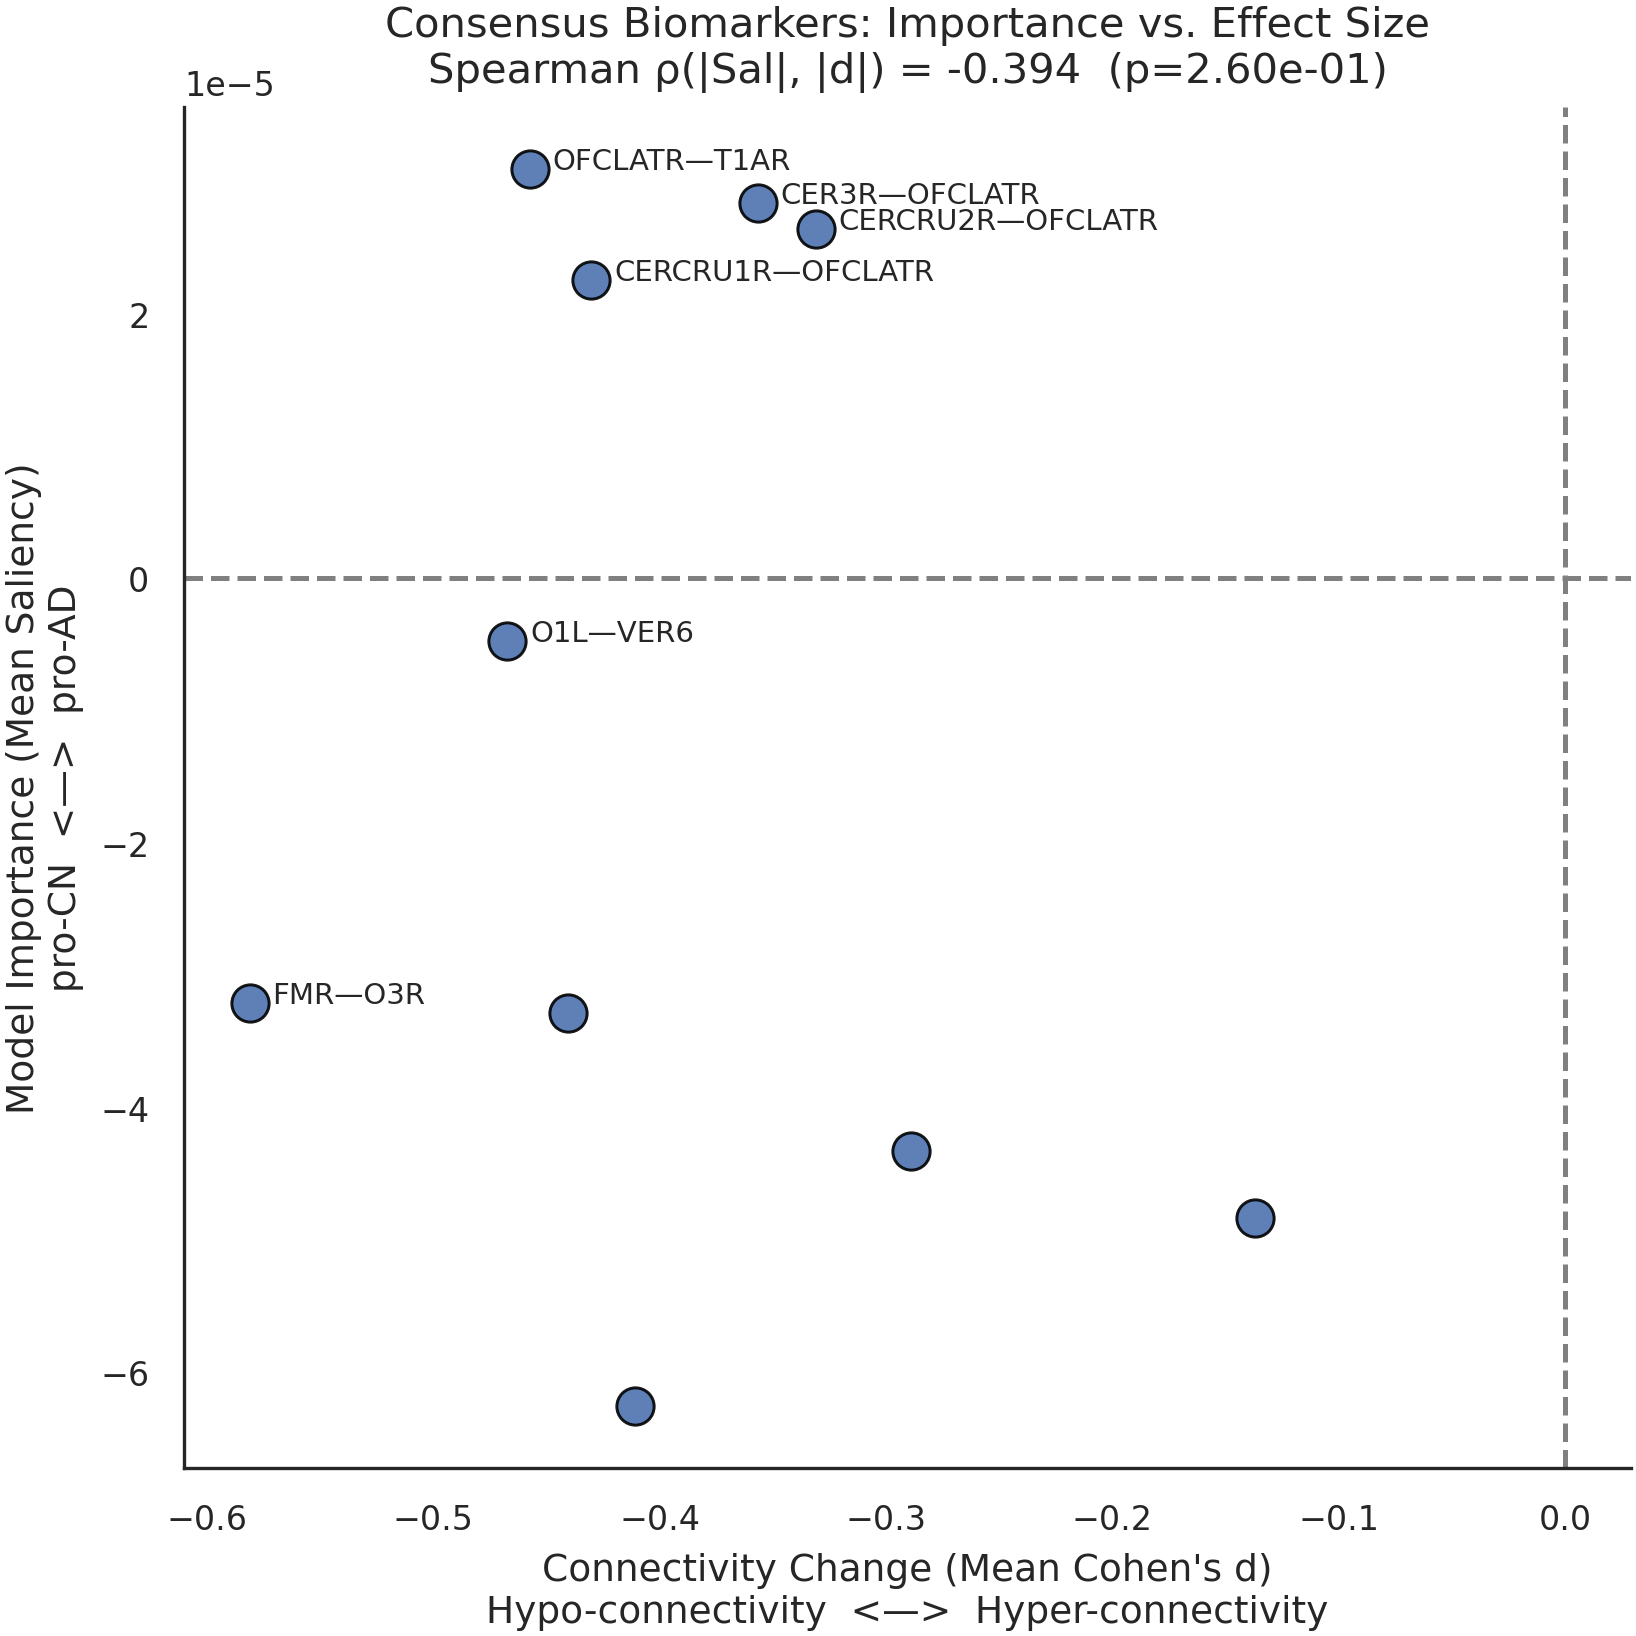

✅ mean_cohen_d calculado en test por fold y promediado entre folds.
   - Figura de dispersión guardada en 'Figures_Nature/fig_SI_quadrant_plot.pdf/png'.
   - DataFrame 'df_consensus_analysis' contiene los datos para análisis adicional.
                     mean_saliency  mean_cohen_d          conn_str
(CER3R, OFCLATR)          0.000028     -0.356441     CER3R—OFCLATR
(CER9L, OFCLATR)         -0.000063     -0.410894     CER9L—OFCLATR
(CERCRU1R, OFCLATR)       0.000023     -0.430077  CERCRU1R—OFCLATR
(CERCRU2R, OFCLATR)       0.000026     -0.330838  CERCRU2R—OFCLATR
(FMR, O3R)               -0.000032     -0.580990           FMR—O3R
(O1L, VER6)              -0.000005     -0.467206          O1L—VER6
(OFCLATR, T1AR)           0.000031     -0.457176      OFCLATR—T1AR
(ORR, VER6)              -0.000033     -0.440641          ORR—VER6
(SMAR, VER7)             -0.000048     -0.136805         SMAR—VER7
(T3R, VER7)              -0.000043     -0.289020          T3R—VER7
-0.3939393939393939 0.25999

In [14]:
# ===================================================================
# CELDA REEMPLAZO: Saliencia (media) vs. Cambio de Conectividad (Cohen's d real)
# ===================================================================
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import spearmanr

# --- Utilidad estable para d de Cohen (AD - CN) ---
def cohen_d(ad, cn, eps=1e-9):
    ad, cn = np.asarray(ad), np.asarray(cn)
    nx, ny = ad.size, cn.size
    if nx < 2 or ny < 2:
        return np.nan
    dof = nx + ny - 2
    s_ad = np.var(ad, ddof=1)
    s_cn = np.var(cn, ddof=1)
    pooled = np.sqrt(((nx - 1) * s_ad + (ny - 1) * s_cn) / max(dof, 1))
    if pooled < eps:
        return 0.0
    return (np.mean(ad) - np.mean(cn)) / pooled

# --- Carga de tensor y metadatos (usa tus rutas ya definidas) ---
npz = np.load(GLOBAL_TENSOR_PATH)
# Filtrar a canales seleccionados y mantener orden de sujetos del NPZ
tensor_all = npz["global_tensor_data"][:, CHANNELS_TO_USE, :, :]  # [n_subj, n_chan_sel, R, R]
subj_all_ids = pd.Series(npz["subject_ids"].astype(str), name="SubjectID")

meta = pd.read_csv(METADATA_PATH, usecols=["SubjectID", "ResearchGroup_Mapped"])
meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()

# DataFrame maestro alineado al NPZ
idx_df = pd.DataFrame({"SubjectID": subj_all_ids, "tensor_idx": np.arange(len(subj_all_ids))})
merged = idx_df.merge(meta, on="SubjectID", how="left")
cnad_df = merged[merged["ResearchGroup_Mapped"].isin(["CN", "AD"])].reset_index(drop=True)

# --- Conjunto de conexiones a evaluar y su (idx_i, idx_j) canónico ---
if not {"idx_i", "idx_j"}.issubset(df_full.columns):
    raise KeyError("df_full debe contener columnas 'idx_i' e 'idx_j' para mapear ROIs.")

conn_map = (
    df_full[["connection_id", "idx_i", "idx_j"]]
    .drop_duplicates("connection_id")
    .set_index("connection_id")
    .astype(int)
)

# --- d de Cohen por fold en TEST y promedio entre folds ---
N_FOLDS_FOUND = df_full["fold"].nunique()
cohen_per_fold = []

for f in range(1, N_FOLDS_FOUND + 1):
    test_idx_path = BASE_RUN_DIR / f"fold_{f}" / "test_indices.npy"
    if not test_idx_path.exists():
        print(f"⚠️ Falta test_indices en fold {f}: {test_idx_path}. Se omite este fold.")
        continue

    test_indices_in_cnad = np.load(test_idx_path)  # índices sobre cnad_df
    test_df = cnad_df.iloc[test_indices_in_cnad]

    ad_idx = test_df[test_df["ResearchGroup_Mapped"] == "AD"]["tensor_idx"].to_numpy()
    cn_idx = test_df[test_df["ResearchGroup_Mapped"] == "CN"]["tensor_idx"].to_numpy()

    if len(ad_idx) < 2 or len(cn_idx) < 2:
        print(f"⚠️ Muy pocos sujetos en test para fold {f}. Se omite.")
        continue

    rows = []
    for conn, (i, j) in conn_map.iterrows():
        # valor de conectividad por sujeto (promedio sobre canales seleccionados)
        # shape: [n_subj]
        vals_all = tensor_all[:, :, i, j].mean(axis=1)
        dval = cohen_d(vals_all[ad_idx], vals_all[cn_idx])
        rows.append((conn, dval))

    df_fold_d = pd.DataFrame(rows, columns=["connection_id", f"cohen_d_fold_{f}"]).set_index("connection_id")
    cohen_per_fold.append(df_fold_d)

if not cohen_per_fold:
    raise RuntimeError("No se pudo calcular Cohen's d en ningún fold (revisa test_indices.npy y metadatos).")

df_cohen_all = pd.concat(cohen_per_fold, axis=1)

# Promedio (ignorando NaNs si algún fold faltó) y dispersión por si quieres reportarla
df_cohen_all["mean_cohen_d"] = df_cohen_all.mean(axis=1, skipna=True)
df_cohen_all["std_cohen_d"]  = df_cohen_all.std(axis=1,  skipna=True)

# --- Saliencia media entre folds (para el eje Y del plot) ---
df_mean_saliency = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("mean_saliency") # <-- CORREGIDO

# --- Merge para análisis (y filtro al consensus set) ---
df_analysis = pd.concat([df_mean_saliency, df_cohen_all["mean_cohen_d"]], axis=1).dropna()
df_consensus_analysis = df_analysis.loc[df_analysis.index.intersection(consensus_set.index)].copy()
df_consensus_analysis["conn_str"] = df_consensus_analysis.index.map(lambda t: f"{t[0]}—{t[1]}")

# --- Correlación (opcional, magnitudes) ---
rho, pval = spearmanr(df_consensus_analysis["mean_saliency"].abs(),
                      df_consensus_analysis["mean_cohen_d"].abs())

# --- Quadrant plot ---
fig, ax = plt.subplots(figsize=(5.5, 5.5), constrained_layout=True)
sns.scatterplot(
    data=df_consensus_analysis,
    x="mean_cohen_d", y="mean_saliency",
    s=80, edgecolor="black", alpha=0.9, ax=ax
)
ax.axhline(0, color="grey", ls="--"); ax.axvline(0, color="grey", ls="--")
ax.set_title(
    f"Consensus Biomarkers: Importance vs. Effect Size\n"
    f"Spearman ρ(|Sal|, |d|) = {rho:.3f}  (p={pval:.2e})"
)
ax.set_xlabel("Connectivity Change (Mean Cohen's d)\nHypo-connectivity  <—>  Hyper-connectivity")
ax.set_ylabel("Model Importance (Mean Saliency)\npro-CN  <—>  pro-AD")

# Anotar algunas conexiones más salientes para contexto
for _, r in df_consensus_analysis.sort_values("mean_saliency", ascending=False).head(6).iterrows():
    ax.text(r["mean_cohen_d"] + 0.01, r["mean_saliency"], r["conn_str"], fontsize=7)

savefig_nature(fig, FIG_DIR / "fig_SI_quadrant_plot")
plt.show()

print("✅ mean_cohen_d calculado en test por fold y promediado entre folds.")
print("   - Figura de dispersión guardada en 'Figures_Nature/fig_SI_quadrant_plot.pdf/png'.")
print("   - DataFrame 'df_consensus_analysis' contiene los datos para análisis adicional.")
print(df_consensus_analysis)
print(rho, pval)

### 2.3. ¿De Dónde Viene la Información? Contribución por Canal y Lateralidad

Finalmente, investigamos dos fuentes de variación:
- **Contribución por Canal**: Analizamos qué métrica de conectividad (canal) aporta la mayor "energía" de saliencia, revelando qué tipo de dinámica funcional es más discriminativa.
- **Asimetría Hemisférica**: Usamos un **test binomial** para determinar si existe una lateralización estadísticamente significativa en las conexiones más salientes (p. ej., si las conexiones dentro del hemisferio derecho son más frecuentes de lo esperado).


✅ Se cargaron datos de contribución de canales de 5 folds.


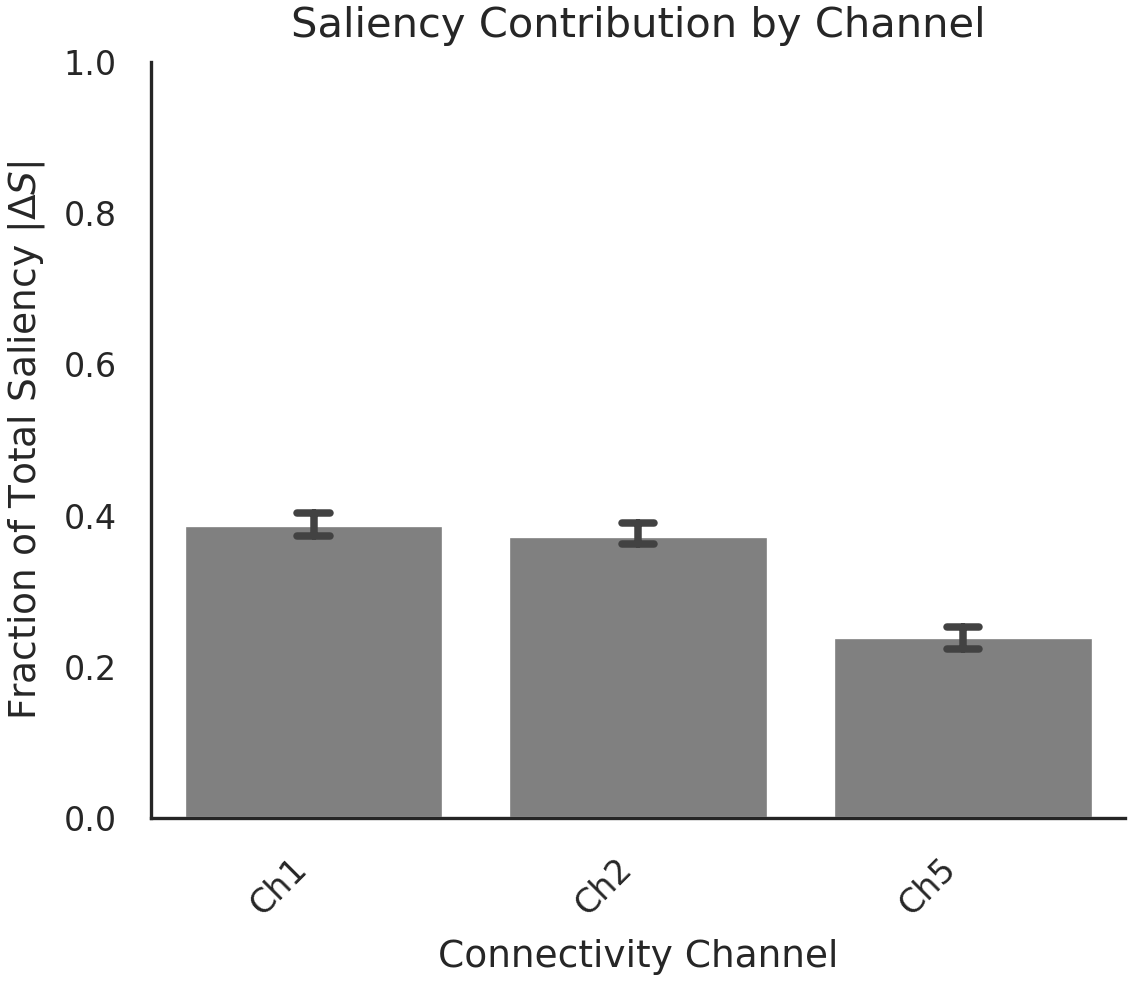

In [15]:
# ===================================================================
# CELDA CORREGIDA: CONTRIBUCIÓN POR CANAL (PROMEDIADO ENTRE FOLDS)
# ===================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuración de rutas ---
BASE_RUN_DIR = Path('./resultados_13_paper_qc_beta2')
CLF = 'logreg'
SUFFIX = '_integrated_gradients_top50'
N_FOLDS = 5

# --- Recolectar datos de todos los folds ---
channel_contributions_rows = []
files_found = 0
for i in range(1, N_FOLDS + 1):
    file_path = BASE_RUN_DIR / f'fold_{i}/interpretability_{CLF}/channel_contributions{SUFFIX}.csv'
    if file_path.exists():
        df_contribution = pd.read_csv(file_path)
        df_contribution['fold'] = i
        channel_contributions_rows.append(df_contribution)
        files_found += 1
    else:
        print(f"⚠️ Advertencia: No se encontró el archivo para el fold {i} en: {file_path}")

# --- Proceder solo si se encontraron archivos ---
if channel_contributions_rows:
    df_contributions_all_folds = pd.concat(channel_contributions_rows, ignore_index=True)
    print(f"\n✅ Se cargaron datos de contribución de canales de {files_found} folds.")

    # --- Generar el gráfico con barras de error ---
    fig, ax = plt.subplots(figsize=(4, 3.5))
    
    sns.barplot(
        data=df_contributions_all_folds, 
        x='channel_name', 
        y='l1_norm_fraction_abs',
        color='gray',
        errorbar=('ci', 95),
        capsize=.1,
        ax=ax
    )
    
    ax.set_title('Saliency Contribution by Channel')
    ax.set_xlabel('Connectivity Channel')
    ax.set_ylabel(r'Fraction of Total Saliency $|\Delta S|$')
    ax.set_ylim(0, 1)
    
    # --- LÍNEA CORREGIDA ---
    # La rotación y alineación se controlan aquí, no en tick_params
    plt.xticks(rotation=45, ha='right')
    
    fig.tight_layout()
    
    savefig_nature(fig, FIG_DIR / 'fig_SI_channel_contributions')
    plt.show()

else:
    print("\n❌ No se encontraron archivos de contribución de canales. No se puede generar el gráfico.")

In [16]:
from sklearn.utils import check_random_state
from statsmodels.stats.multitest import multipletests

def perm_pvals_edgewise(df_subj_ig, group, strata, B=2000, seed=7):
    # df_subj_ig: DataFrame [n_subj x n_edges] con |IG_ij| por sujeto
    # group: Series (AD/CN); strata: DataFrame con Manufacturer, Sex
    rng = check_random_state(seed)
    real = df_subj_ig[group=='AD'].mean() - df_subj_ig[group=='CN'].mean()
    real = real.abs()
    counts = np.zeros_like(real, dtype=int)
    # preconstruir índices por estrato
    keys = list(zip(strata['Manufacturer'], strata['Sex']))
    uniq = sorted(set(keys))
    idx_by = {u: np.where([k==u for k in keys])[0] for u in uniq}
    y = group.values.copy()
    for b in range(B):
        y_perm = y.copy()
        for u, idx in idx_by.items():
            rng.shuffle(y_perm[idx])
        perm = df_subj_ig[y_perm=='AD'].mean() - df_subj_ig[y_perm=='CN'].mean()
        counts += (np.abs(perm) >= real).astype(int)
    p = (counts + 1) / (B + 1)
    q = multipletests(p, method='fdr_bh')[1]
    out = pd.DataFrame({'abs_deltaS': real.values, 'p': p, 'q': q}, index=df_subj_ig.columns)
    return out.sort_values('q')


In [17]:
def edge_inclusion_probability(df_rank_by_fold, K=200, B=1000, seed=13):
    rng = np.random.default_rng(seed)
    edges = sorted(set.union(*[set(df.head(K).index) for df in df_rank_by_fold.values()]))
    e2i = {e:i for i,e in enumerate(edges)}
    cnt = np.zeros(len(edges), dtype=int)
    for _ in range(B):
        for f, df in df_rank_by_fold.items():
            # re-muestra sujetos (suponiendo que guardaste IG por sujeto) y recomputa ranking...
            pass
        # incrementa cnt[e2i[edge]] si edge entra en top-K del bootstrap-meta
    return pd.Series(cnt/B, index=edges, name='EIP')


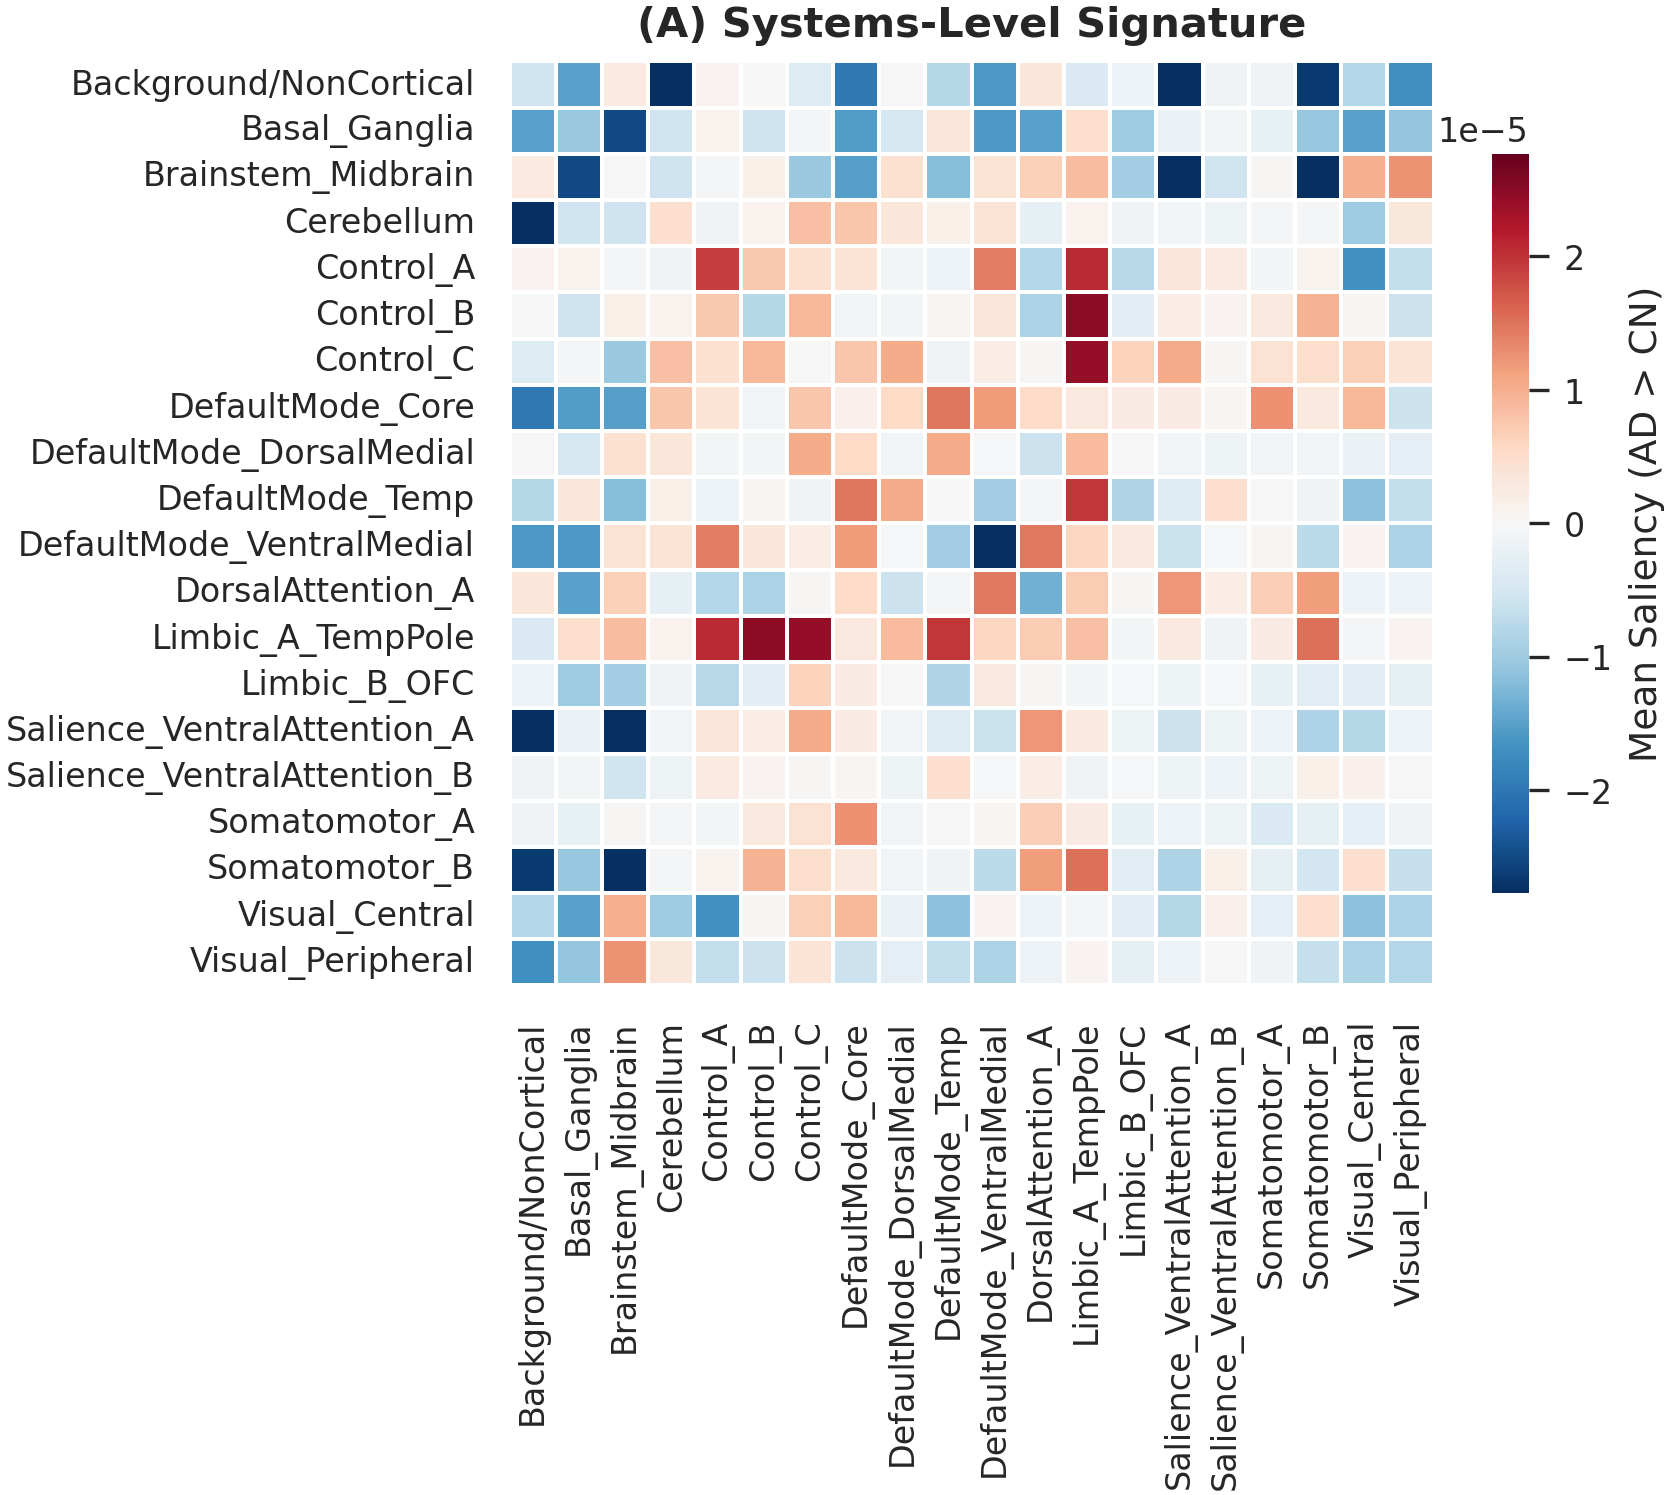

✅ Figura del Panel A guardada en: Figures_Nature/figure_A_systems_signature.svg


In [18]:
# ===================================================================
# CELDA PARA FIGURA A: Systems-Level Signature (Fold 1)
# ===================================================================

# --- Configuración ---
FOLD_TO_SHOW = 1 # Fold representativo
FIG_A_NAME = "figure_A_systems_signature"

# --- Preparación de Datos ---
df_fold_a = df_full[df_full["fold"] == FOLD_TO_SHOW].copy()
net_src_col = "src_Refined_Network" if "src_Refined_Network" in df_fold_a.columns else "src_Yeo17_Network"
net_dst_col = "dst_Refined_Network" if "dst_Refined_Network" in df_fold_a.columns else "dst_Yeo17_Network"

mat_A = df_fold_a.groupby([net_src_col, net_dst_col])["Saliency_Signed"].mean().unstack(fill_value=0)
mat_A = (mat_A + mat_A.T) / 2 # Simetrizar
network_order = sorted(mat_A.columns)
mat_A = mat_A.reindex(index=network_order, columns=network_order).fillna(0.0)

# --- Generación del Gráfico ---
fig_A, ax_A = plt.subplots(figsize=(5, 4))

# Usamos un valor máximo robusto para la escala de color
vmax_A = np.percentile(np.abs(mat_A.values), 98)

sns.heatmap(mat_A, cmap="RdBu_r", center=0, vmin=-vmax_A, vmax=vmax_A, square=True,
            cbar_kws={'label': 'Mean Saliency (AD > CN)', 'shrink': 0.8},
            ax=ax_A, linewidths=.5, linecolor='white')

ax_A.set_title("(A) Systems-Level Signature", weight="bold")
ax_A.set_xlabel("")
ax_A.set_ylabel("")
ax_A.tick_params(axis='x', rotation=90)
ax_A.tick_params(axis='y', rotation=0)

# --- Guardado en SVG ---
output_path_A = FIG_DIR / f"{FIG_A_NAME}.svg"
fig_A.savefig(output_path_A, format='svg', bbox_inches="tight")
plt.show()

print(f"✅ Figura del Panel A guardada en: {output_path_A}")

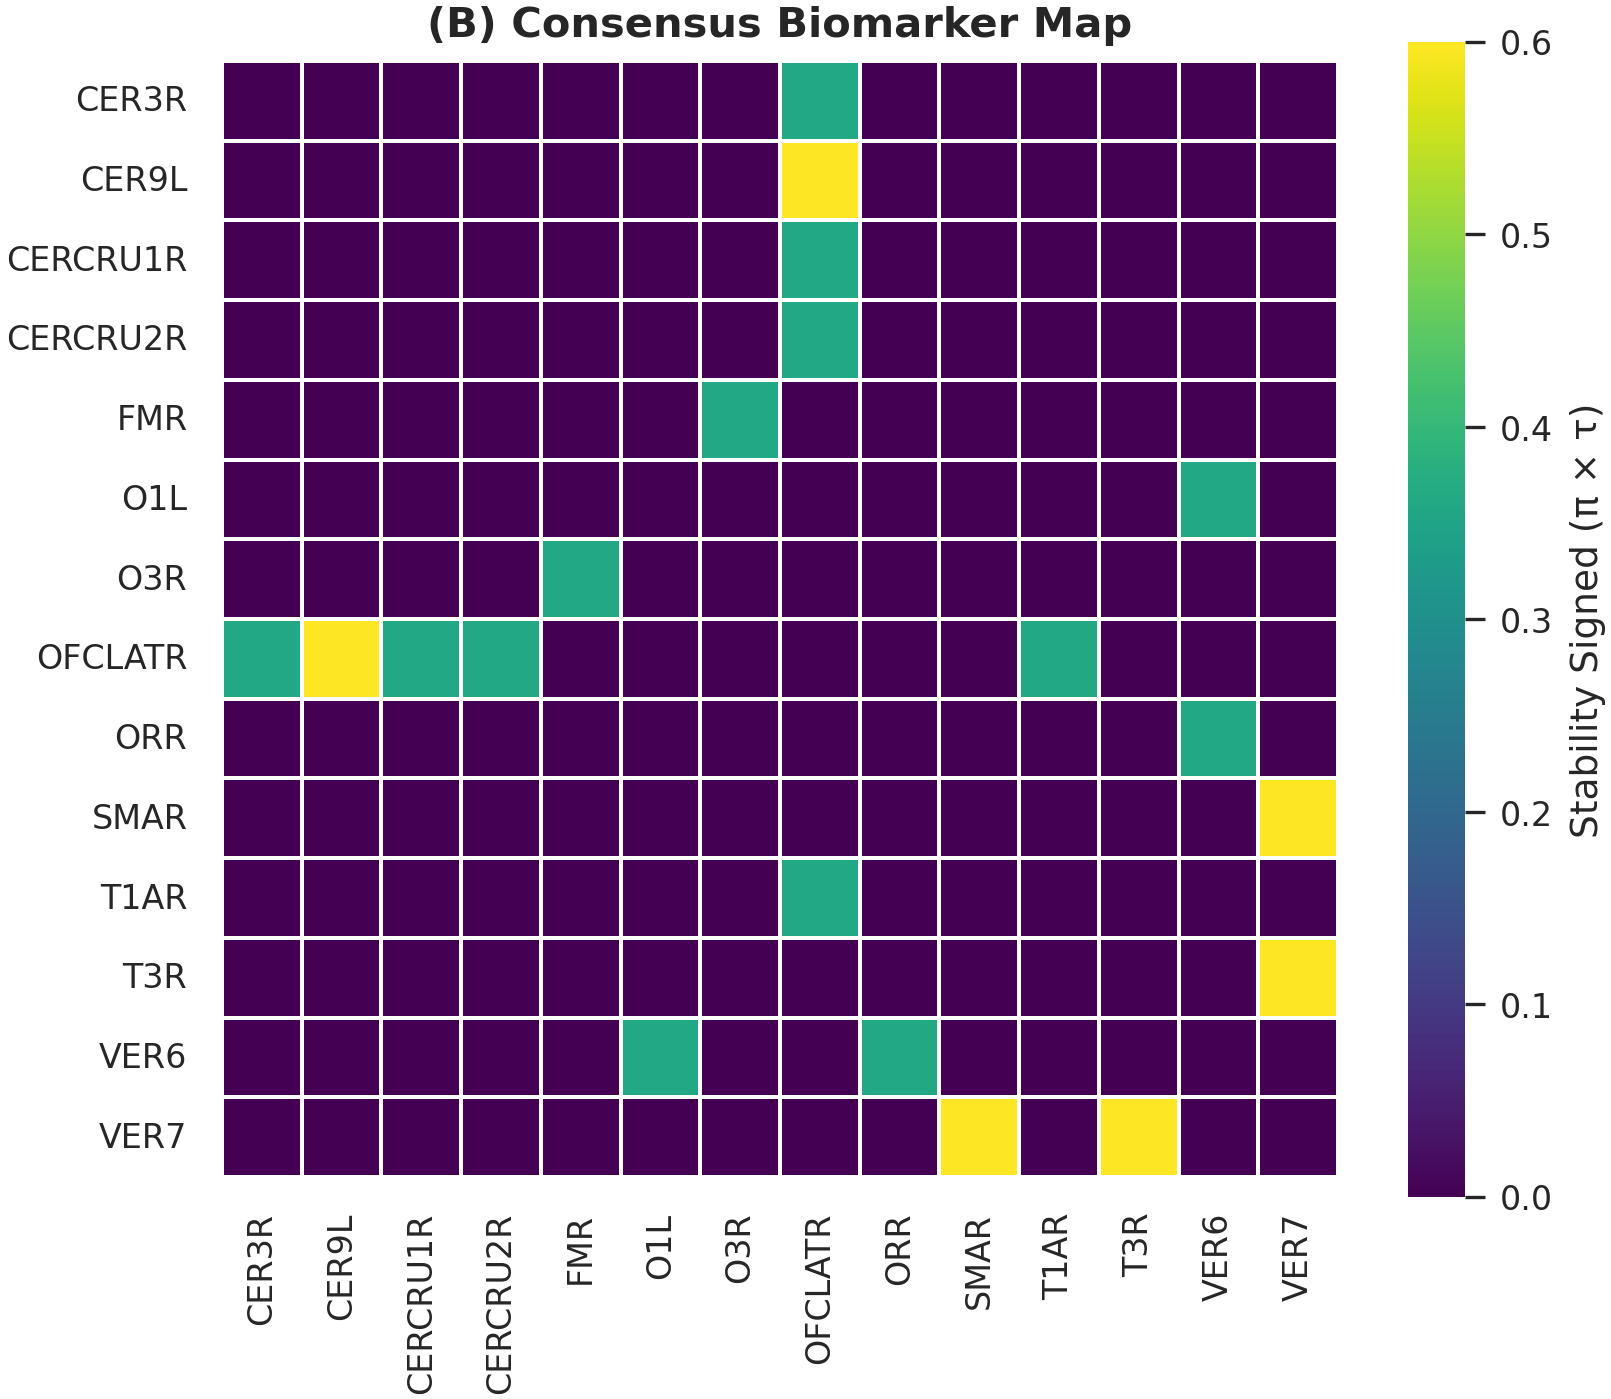

✅ Figura del Panel B guardada en: Figures_Nature/figure_B_consensus_map.svg


In [19]:
# ===================================================================
# CELDA PARA FIGURA B: Consensus Biomarker Map
# ===================================================================

# --- Configuración ---
FIG_B_NAME = "figure_B_consensus_map"

# --- Preparación de Datos ---
# Asegúrate de que 'consensus_set' ya ha sido calculado
rois_B = sorted(list(set(roi for conn_tuple in consensus_set.index for roi in conn_tuple)))
mat_B = pd.DataFrame(0.0, index=rois_B, columns=rois_B)
for (src, dst), row in consensus_set.iterrows():
    mat_B.loc[src, dst] = mat_B.loc[dst, src] = row['Signed']

# --- Generación del Gráfico ---
fig_B, ax_B = plt.subplots(figsize=(6, 5))

sns.heatmap(mat_B, cmap="viridis", square=True,
            cbar_kws={'label': 'Stability Signed (π × τ)'},
            ax=ax_B, linewidths=.5, linecolor='white')

ax_B.set_title("(B) Consensus Biomarker Map", weight="bold")
ax_B.set_xlabel("")
ax_B.set_ylabel("")
ax_B.tick_params(axis='x', rotation=90)
ax_B.tick_params(axis='y', rotation=0)

# --- Guardado en SVG ---
output_path_B = FIG_DIR / f"{FIG_B_NAME}.svg"
fig_B.savefig(output_path_B, format='svg', bbox_inches="tight")
plt.show()

print(f"✅ Figura del Panel B guardada en: {output_path_B}")

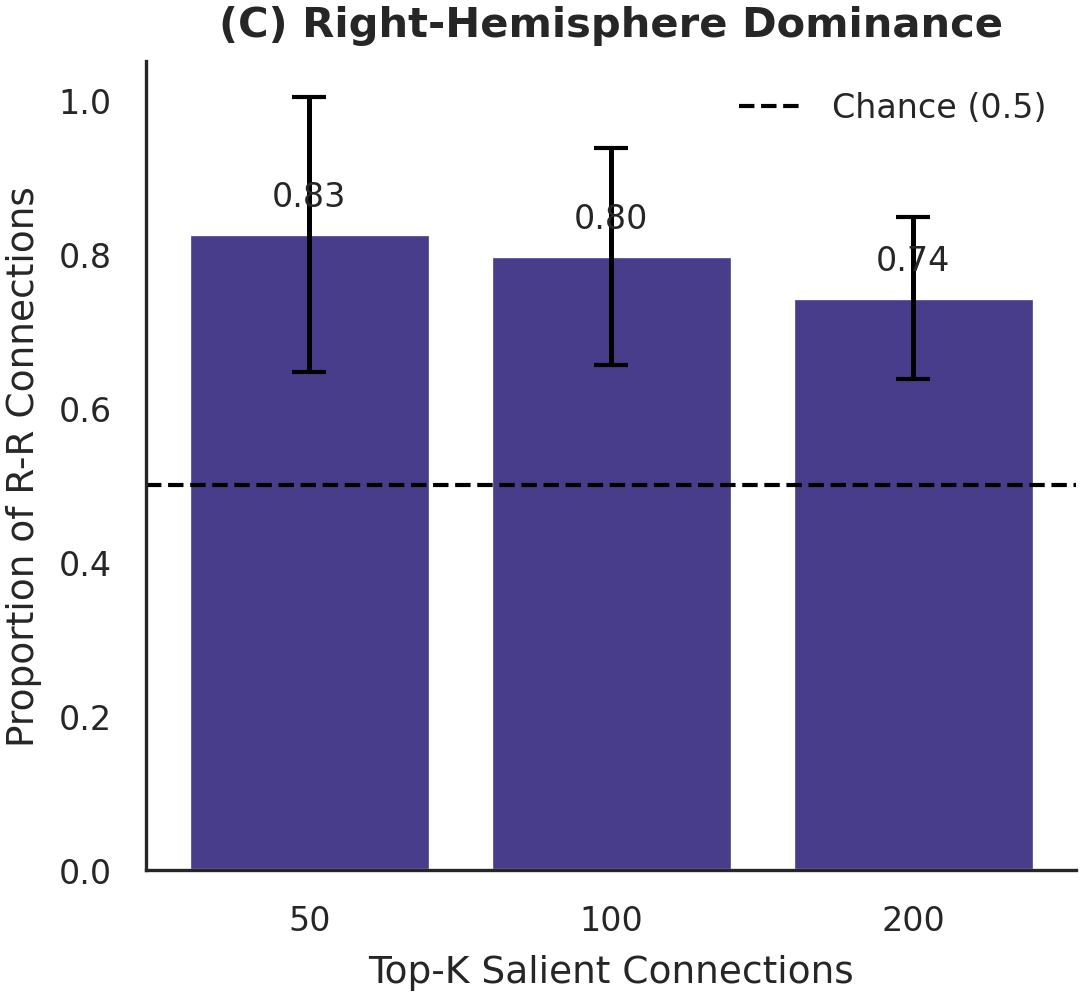

In [20]:
# === FIGURA C (Right-Hemisphere Dominance) SIN categorical-units INFO ===
from scipy.stats import t

agg_C = df_lat_plot.groupby("TopK")["p_RR"].agg(["mean","count","std"]).reset_index()
agg_C["sem"] = agg_C["std"] / np.sqrt(agg_C["count"])
agg_C["ci"]  = t.ppf(0.975, df=agg_C["count"] - 1) * agg_C["sem"]

fig_C, ax_C = plt.subplots(figsize=(4, 3.5))

# barras en posiciones numéricas
xvals = np.arange(len(agg_C))
ax_C.bar(xvals, agg_C["mean"], color="darkslateblue")

# errorbars con x numéricas
ax_C.errorbar(xvals, agg_C["mean"], yerr=agg_C["ci"], fmt="none", capsize=4, ecolor="black")

# ejes y título
ax_C.axhline(0.5, ls="--", c="black", lw=1, label="Chance (0.5)")
ax_C.set_ylim(0, 1.05)
ax_C.set_xlabel("Top-K Salient Connections")
ax_C.set_ylabel("Proportion of R-R Connections")
ax_C.set_title("(C) Right-Hemisphere Dominance", weight="bold")
ax_C.legend(frameon=False)

# ticks bonitos
ax_C.set_xticks(xvals)
ax_C.set_xticklabels(agg_C["TopK"].astype(int))

# anotaciones
for i, m in enumerate(agg_C["mean"]):
    ax_C.annotate(f"{m:.2f}", (xvals[i], m), ha='center', va='center',
                  xytext=(0, 9), textcoords='offset points', fontsize=8)

savefig_nature(fig_C, FIG_DIR / "figure_C_hemisphere_dominance")
plt.show()


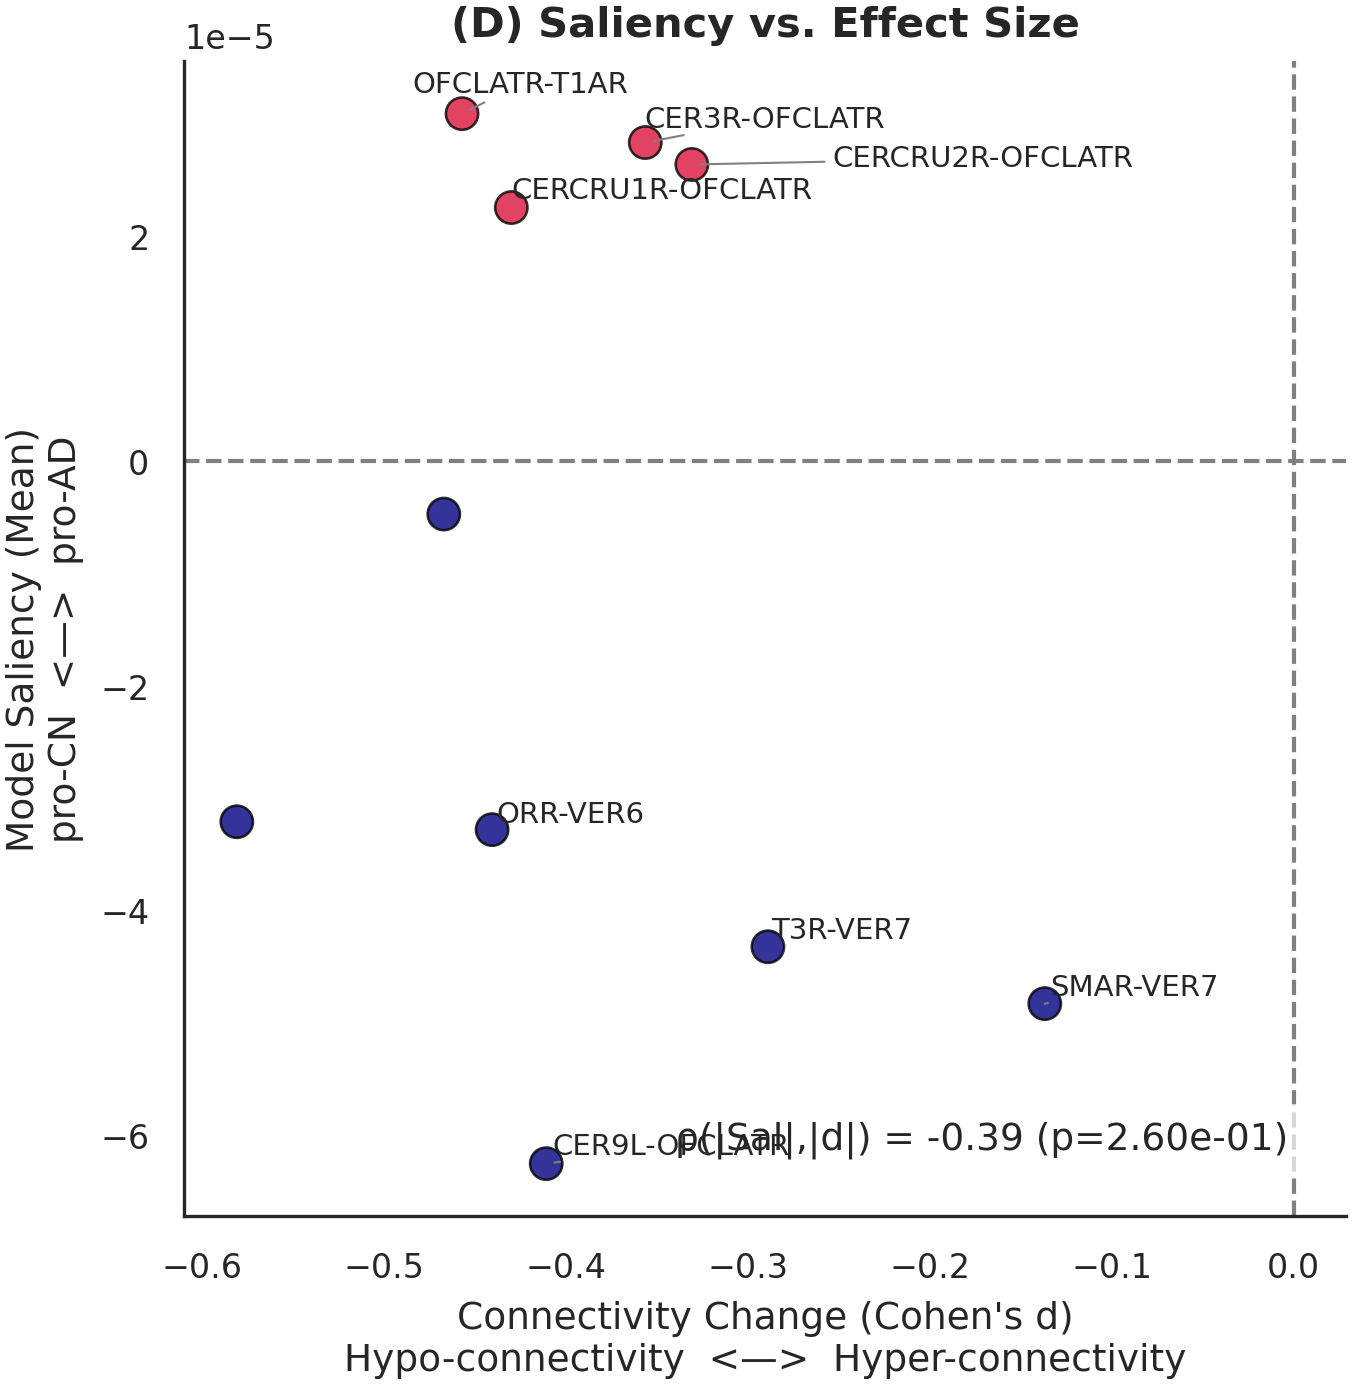

✅ Figura del Panel D guardada en: Figures_Nature/figure_D_saliency_vs_effect.svg


In [21]:
# ===================================================================
# CELDA PARA FIGURA D: Saliency vs. Effect Size (FIX)
# ===================================================================
from scipy.stats import spearmanr
try:
    from adjustText import adjust_text
    ADJUST_TEXT_AVAILABLE = True
except ImportError:
    ADJUST_TEXT_AVAILABLE = False
    def adjust_text(texts, **kwargs): pass

FIG_D_NAME = "figure_D_saliency_vs_effect"

# --- Preparación de Datos (usa df_cohen_all) ---
df_mean_sal = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("sal")
cohen_df = df_cohen_all[["mean_cohen_d"]].rename(columns={"mean_cohen_d": "cohen_d"})

# Asegurar mismo índice y filtrar al consensus_set
df_qc = (
    pd.concat([df_mean_sal, cohen_df], axis=1)
      .dropna()
      .loc[df_mean_sal.index.intersection(consensus_set.index)]
)

# Seguridad: si quedara vacío, no crashea
if len(df_qc) == 0:
    print("⚠️ df_qc está vacío. Revisa que consensus_set y df_cohen_all compartan índices.")
    fig_D, ax_D = plt.subplots(figsize=(5, 5))
    ax_D.text(0.5, 0.5, "No data after merge", ha='center', va='center', style='italic', color='grey')
    ax_D.set_xticks([]); ax_D.set_yticks([])
    output_path_D = FIG_DIR / f"{FIG_D_NAME}.svg"
    fig_D.savefig(output_path_D, format='svg', bbox_inches="tight")
    plt.show()
else:
    rho, pval = spearmanr(df_qc["sal"].abs(), df_qc["cohen_d"].abs())

    fig_D, ax_D = plt.subplots(figsize=(5, 5))
    sns.scatterplot(
        data=df_qc, x="cohen_d", y="sal",
        s=60, edgecolor="black", alpha=0.8, ax=ax_D,
        hue=(df_qc['sal'] > 0), palette={True:'crimson', False:'navy'}, legend=False
    )

    ax_D.axhline(0, c="grey", ls="--", lw=1)
    ax_D.axvline(0, c="grey", ls="--", lw=1)
    ax_D.set_title("(D) Saliency vs. Effect Size", weight="bold")
    ax_D.set_xlabel("Connectivity Change (Cohen's d)\nHypo-connectivity  <—>  Hyper-connectivity")
    ax_D.set_ylabel("Model Saliency (Mean)\npro-CN  <—>  pro-AD")

    ax_D.text(0.95, 0.05, f'ρ(|Sal|,|d|) = {rho:.2f} (p={pval:.2e})',
              transform=ax_D.transAxes, ha='right', va='bottom', fontsize=9,
              bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Etiquetar extremos
    pts = pd.concat([df_qc.nlargest(4, 'sal'), df_qc.nsmallest(4, 'sal')])
    texts = [ax_D.text(r["cohen_d"], r["sal"], f"{i[0]}-{i[1]}", fontsize=7)
             for i, r in pts.iterrows()]
    if ADJUST_TEXT_AVAILABLE:
        adjust_text(texts, ax=ax_D, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    output_path_D = FIG_DIR / f"{FIG_D_NAME}.svg"
    fig_D.savefig(output_path_D, format='svg', bbox_inches="tight")
    plt.show()

print(f"✅ Figura del Panel D guardada en: {output_path_D}")

# GUARDAR LA FIGURA COMO Figure_result1_v1.svg
from pathlib import Path
FIGURE_RESULT1_PATH = FIG_DIR / "Figure_result1_v1.svg"
from xml.etree import ElementTree as ET
# Cargar los SVGs individuales
svg_A = ET.parse(FIG_DIR / f"{FIG_A_NAME}.svg").getroot()
svg_B = ET.parse(FIG_DIR / f"{FIG_B_NAME}.svg").getroot()
svg_C = ET.parse(FIG_DIR / f"figure_C_hemisphere_dominance.svg").getroot()
svg_D = ET.parse(FIG_DIR / f"figure_D_saliency_vs_effect.svg").getroot()
# Crear un nuevo SVG contenedor
svg_ns = "http://www.w3.org/2000/svg"
ET.register_namespace("", svg_ns)
figure_result1 = ET.Element(ET.QName(svg_ns, "svg"), attrib={
    "width": "1200",
    "height": "1000",
    "viewBox": "0 0 1200 1000",
    "xmlns": svg_ns
})
# Posicionar cada panel dentro del SVG contenedor
def add_panel(svg_root, x, y):
    g = ET.SubElement(figure_result1, ET.QName(svg_ns, "g"), attrib={
        "transform": f"translate({x},{y})"
    })
    for elem in svg_root:
        g.append(elem)



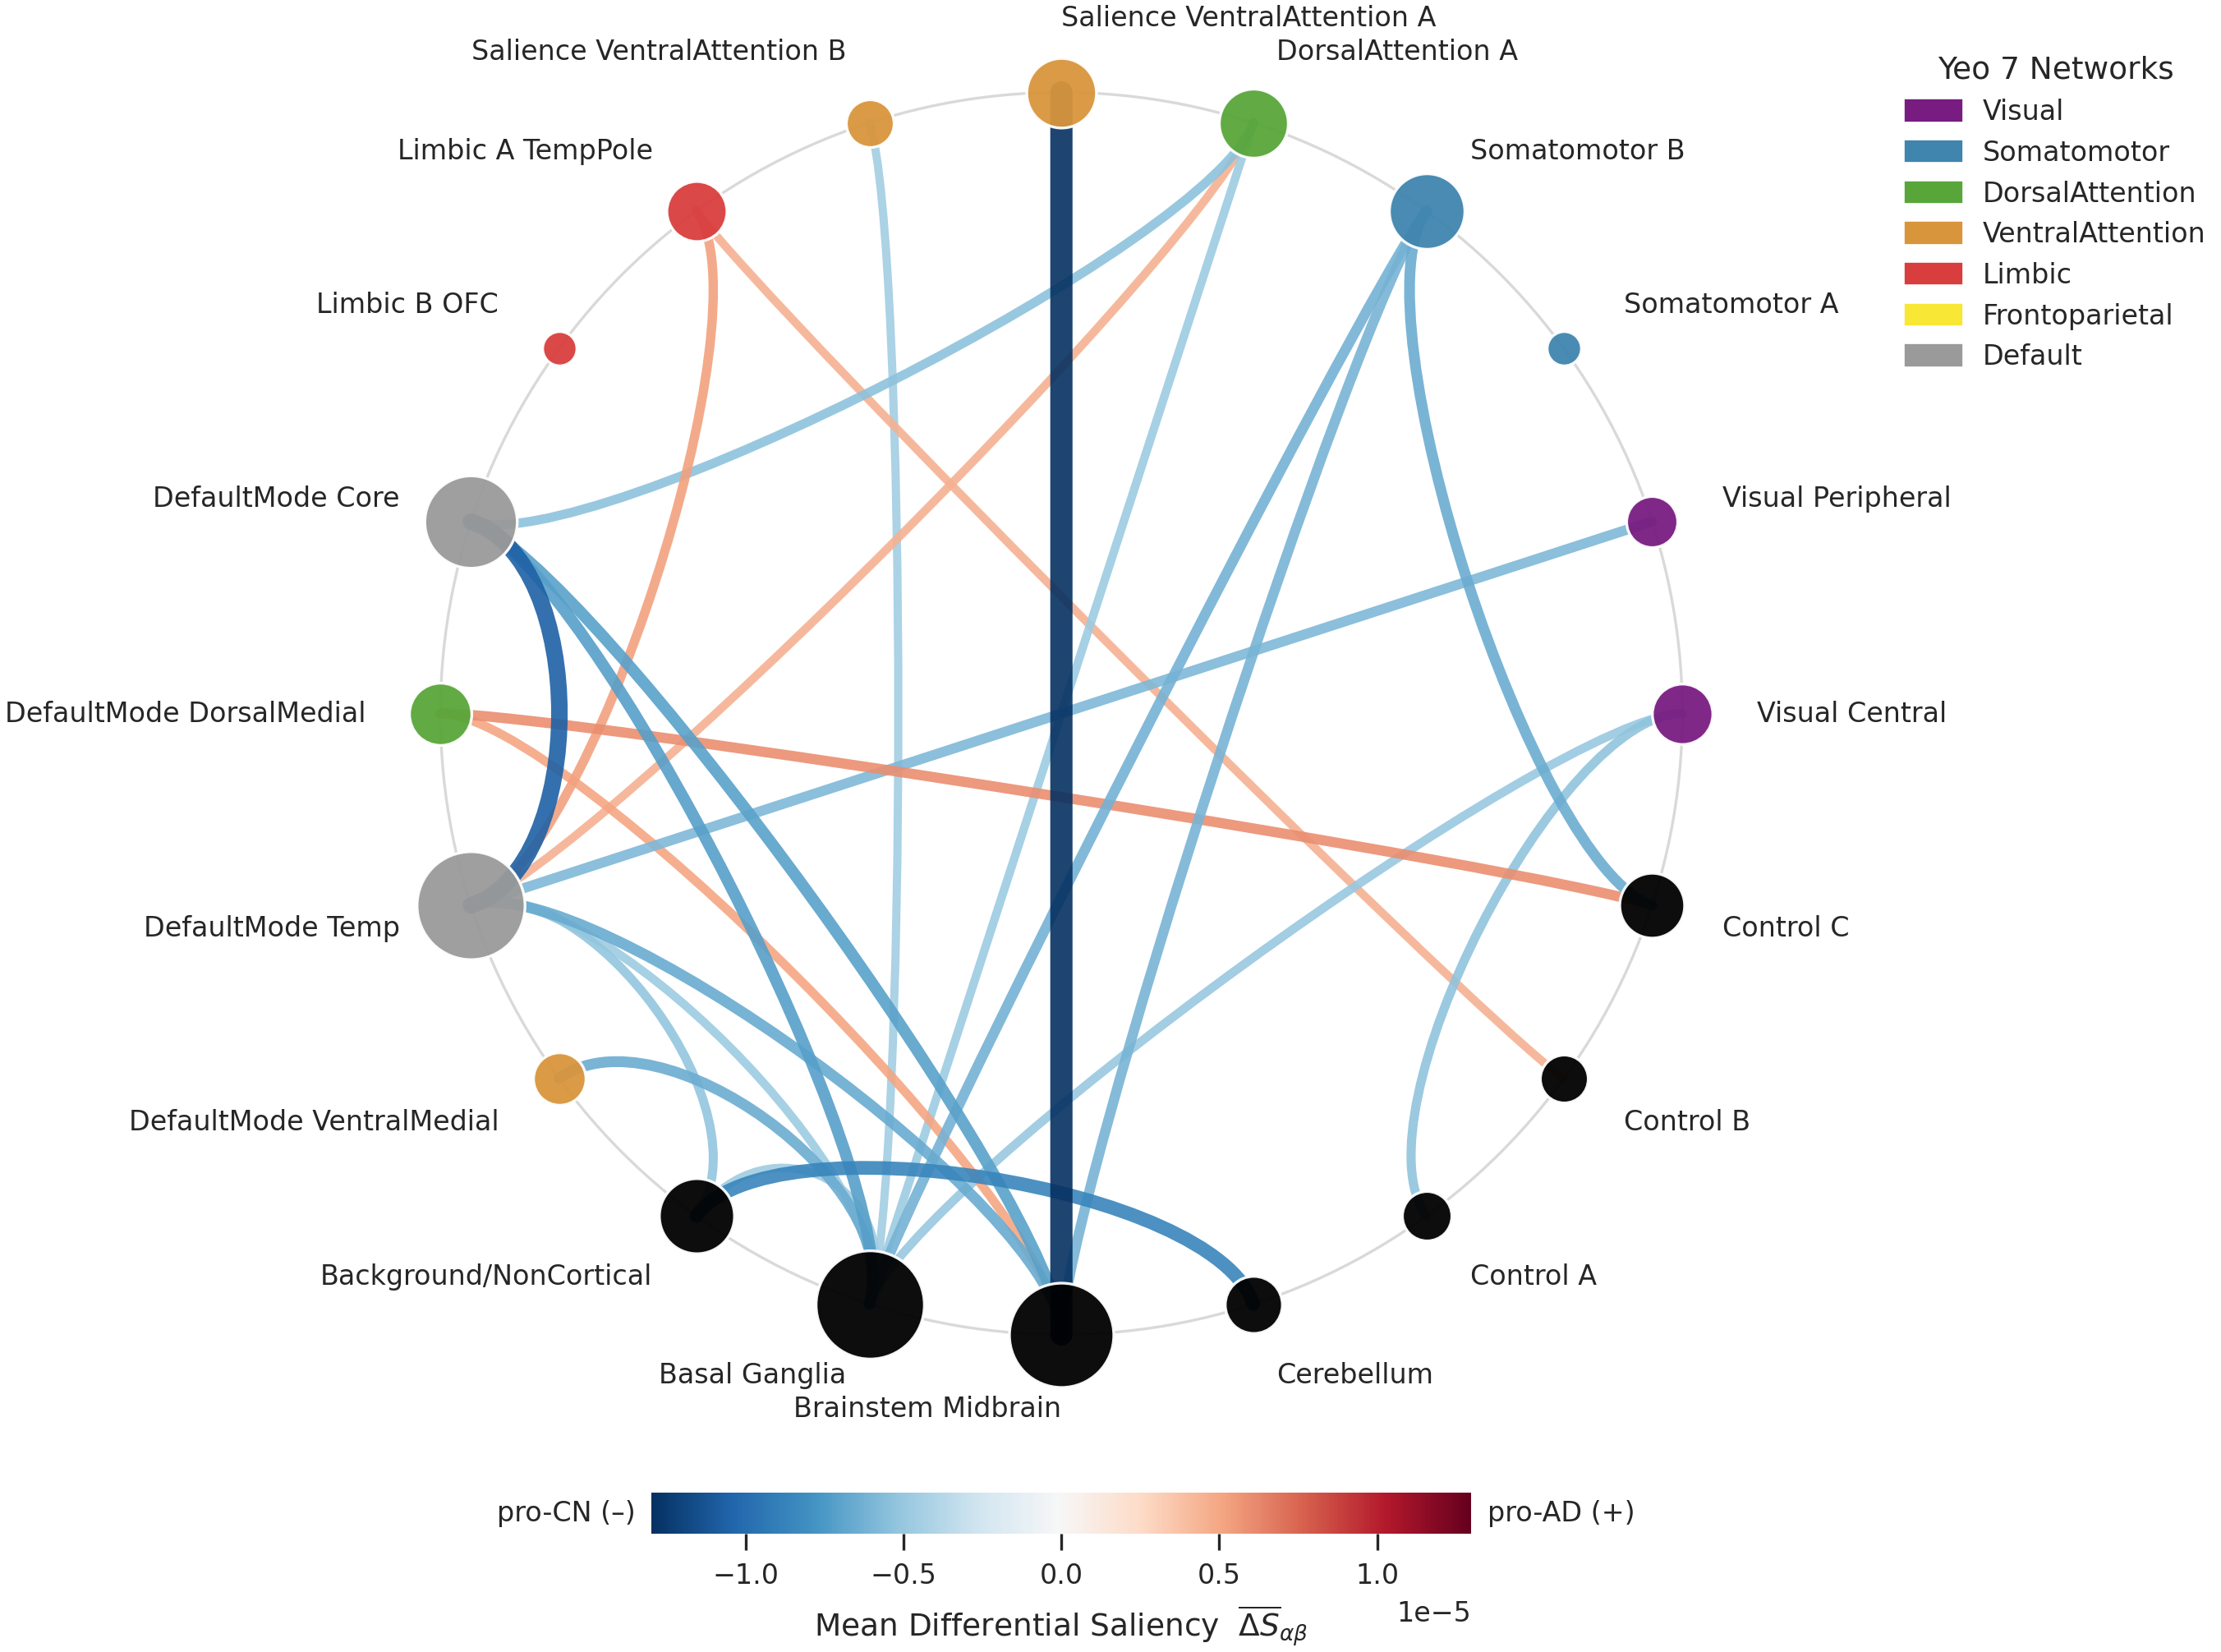

In [22]:
# ======================= CELDA — Chord Yeo↔Yeo (VERSIÓN FINAL CON SVG CORREGIDO) =======================
import pathlib
from datetime import datetime as _dt
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_cmaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch, Circle
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ======================== PARÁMETROS DE LA FIGURA ========================
TOP_K_PAIRS = 24
AGGREGATE_ACROSS_FOLDS = True
FOLD_TO_SHOW = 1
CMAP = 'RdBu_r'
FIGSIZE = (7.2, 7.2)
R_BASE, R_LABEL = 1.00, 1.12
CURVE_INSET = 0.80
ORDER_MODE = 'yeo'
NODE_COLOR_MODE = 'yeo'
MIN_ABS_WEIGHT = 0.0
outname = FIG_DIR / f"fig_YeoChord_{'allfolds' if AGGREGATE_ACROSS_FOLDS else f'fold{FOLD_TO_SHOW}'}_{_dt.now().strftime('%Y%m%d_%H%M')}"

# ======================== LÓGICA DE PLOTEO (Función Principal) ========================
YEO7_ORDER = ['Visual', 'Somatomotor', 'DorsalAttention', 'VentralAttention', 
              'Limbic', 'Frontoparietal', 'Default']
YEO_COLOR_MAP = {
    'visual': '#781C81', 'somato': '#3F85AE', 'dorsal': '#58A63A', 
    'ventral': '#D8953C', 'limbic': '#D83E3E', 'fronto': '#F8E734', 'default': '#9A9A9A'
}

def guess_yeo_color(name: str, default='black'):
    n = name.lower()
    for key, col in YEO_COLOR_MAP.items():
        if key in n: return col
    return default

def _bezier_chord(ax, p1, p2, lw, color, alpha=0.9, inset=0.80):
    ctrl1, ctrl2 = p1 * inset, p2 * inset
    path = MplPath([p1, ctrl1, ctrl2, p2], [MplPath.MOVETO, MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4])
    ax.add_patch(PathPatch(path, facecolor='none', edgecolor=color, lw=lw, alpha=alpha, capstyle='round'))

# ---- Preparación de datos (sin cambios) ----
ns = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
nd = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'
_df = df_full[[ns, nd, 'Saliency_Signed'] + (['fold'] if 'fold' in df_full.columns else [])].dropna()
if not AGGREGATE_ACROSS_FOLDS and 'fold' in _df.columns:
    _df = _df[_df['fold'] == FOLD_TO_SHOW].copy()
title_suffix = 'mean across folds' if AGGREGATE_ACROSS_FOLDS else f'fold {FOLD_TO_SHOW}'
mat = _df.groupby([ns, nd])['Saliency_Signed'].mean().unstack(fill_value=0.0)
mat = (mat + mat.T) / 2
networks = sorted(mat.index.union(mat.columns))
mat = mat.reindex(index=networks, columns=networks).fillna(0.0)
edges = []
for i, a in enumerate(networks):
    for j, b in enumerate(networks):
        if j <= i: continue
        w = float(mat.loc[a, b])
        if abs(w) >= MIN_ABS_WEIGHT:
            edges.append((a, b, w, abs(w)))
if not edges: raise ValueError("No hay pares de redes para graficar.")
k = int(min(TOP_K_PAIRS, len(edges)))
edges_top = sorted(edges, key=lambda t: t[3], reverse=True)[:k]
node_strength = pd.Series(0.0, index=networks)
for a, b, w, aw in edges_top:
    node_strength[a] += aw; node_strength[b] += aw
if ORDER_MODE == 'yeo':
    def _get_order_key(name):
        n_lower = name.lower()
        for idx, canon in enumerate(YEO7_ORDER):
            if canon.lower() in n_lower: return (idx, name)
        return (len(YEO7_ORDER), name)
    net_order = sorted(networks, key=_get_order_key)
else:
    net_order = sorted(networks)
theta = np.linspace(0, 2*np.pi, len(net_order), endpoint=False)
pos = {net: np.array([R_BASE*np.cos(t), R_BASE*np.sin(t)]) for net, t in zip(net_order, theta)}
vmax = np.percentile([aw for *_, aw in edges_top], 98) if edges_top else 1.0
if not np.isfinite(vmax) or vmax <= 1e-6: vmax = 1.0
norm = Normalize(vmin=-vmax, vmax=vmax)
cmap = mpl_cmaps.get_cmap(CMAP)
max_abs = max((aw for *_, aw in edges_top), default=1.0)
def width_from_abs(aw):
    return float(np.clip(0.6 + 6.0 * (aw / (max_abs + 1e-12)), 0.6, 6.5))

# ---- Figura ----
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_aspect('equal'); ax.axis('off')
ax.add_patch(Circle((0,0), R_BASE, facecolor='none', edgecolor='0.85', lw=0.8, zorder=0))

for a, b, w, aw in sorted(edges_top, key=lambda t: t[3]):
    _bezier_chord(ax, pos[a], pos[b], lw=width_from_abs(aw), color=cmap(norm(w)), inset=CURVE_INSET)

for net in net_order:
    xy = pos[net]
    facecolor = guess_yeo_color(net) if NODE_COLOR_MODE == 'yeo' else 'black'
    size = 100 + 900 * (node_strength.get(net, 0) / node_strength.max() if node_strength.max() > 0 else 0)
    ax.scatter([xy[0]], [xy[1]], s=size, zorder=5, edgecolor='white', linewidth=0.8, color=facecolor, alpha=0.95)
    ang = np.arctan2(xy[1], xy[0])
    lx, ly = R_LABEL*np.cos(ang), R_LABEL*np.sin(ang)
    ax.text(lx, ly, net.replace('_',' '), fontsize=8, ha='left' if lx >= 0 else 'right', va='center')

# --- LEYENDA PARA LAS REDES YEO ---
key_map = {
    'Visual': 'visual', 'Somatomotor': 'somato', 'DorsalAttention': 'dorsal',
    'VentralAttention': 'ventral', 'Limbic': 'limbic', 'Frontoparietal': 'fronto', 'Default': 'default'
}
legend_handles = [mpatches.Patch(color=YEO_COLOR_MAP[key_map[name]], label=name) for name in YEO7_ORDER]
ax.legend(handles=legend_handles, 
          title='Yeo 7 Networks', 
          bbox_to_anchor=(1.1, 1.0),
          loc='upper left',         
          fontsize=8,
          title_fontsize=9,
          frameon=False)            

# --- COLORBAR HORIZONTAL ABAJO (FIX SVG) ---
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(-vmax, vmax, 256))  # ⟵ CLAVE: da “datos” al mapeador

cax = inset_axes(ax, width="60%", height="3%", loc='lower center', borderpad=-5)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r'Mean Differential Saliency  $\overline{\Delta S}_{\alpha\beta}$', fontsize=9)
cbar.solids.set_edgecolor("face")       # evita líneas en el gradiente
cbar.outline.set_visible(False)
# (opcional) rasterizar SOLO el gradiente si ves banding en Illustrator
# cbar.solids.set_rasterized(True)

cbar.ax.text(1.02, 0.5, 'pro-AD (+)', transform=cbar.ax.transAxes, ha='left', va='center', fontsize=8)
cbar.ax.text(-0.02, 0.5, 'pro-CN (–)', transform=cbar.ax.transAxes, ha='right', va='center', fontsize=8)

# --- Guardado ---
savefig_nature(fig, outname)  # pdf/png como ya tenías
fig.savefig(outname.with_suffix(".svg"), format='svg', bbox_inches="tight")  # ⟵ sin 'rasterized'

#la figura se guarda en outname con extensiones .pdf, .png y .svg


In [23]:
# === NUEVA CELDA: Robust hubs agregados (grado-controlado) ===
import pandas as pd, numpy as np
from pathlib import Path

Ks = (50, 100, 200)
hub_rows = []

for fold in range(1, N_FOLDS + 1):
    for K in Ks:
        path = BASE_RUN_DIR / f"fold_{fold}/interpretability_{CLF}/node_robust_hubs_top{K}{SUFFIX}.csv"
        if not path.exists():
            print(f"⚠️ Falta: {path}")
            continue
        df = pd.read_csv(path)
        # aseguramos columnas esperadas
        assert {'node','degree','strength','residual_strength'}.issubset(df.columns), "CSV hubs no tiene columnas esperadas"
        df = df.sort_values('residual_strength', ascending=False).reset_index(drop=True)
        df['fold'] = fold
        df['K'] = K
        df['rank_resid'] = np.arange(1, len(df)+1)
        # guardamos top-10 por robustez
        hub_rows.append(df.head(10)[['node','residual_strength','rank_resid','fold','K']])

if not hub_rows:
    raise RuntimeError("No se encontraron CSVs de hubs. Corre interpretar_fold_paper.py (saliency) para generarlos.")

hubs_agg = pd.concat(hub_rows, ignore_index=True)

# métricas de “epicentro”
summary = (
    hubs_agg
    .groupby('node')
    .agg(
        top3_hits = ('rank_resid', lambda s: int((s <= 3).sum())),
        mean_rank = ('rank_resid', 'mean'),
        mean_resid= ('residual_strength', 'mean'),
        n_lists   = ('rank_resid', 'size')
    )
    .sort_values(['top3_hits','mean_resid'], ascending=[False, False])
)

display(summary.head(20))

# ✅ chequeo específico de HIPPOR y cerebelo
roi_focus = [r for r in summary.index if ('HIPPOR' in r) or ('CER' in r)]
display(summary.loc[roi_focus].sort_values(['top3_hits','mean_resid'], ascending=[False,False]).head(20))


top3_hits  mean_rank  mean_resid  n_lists
node                                              
FMR              4   4.500000    0.000073        6
VER6             3   3.875000    0.000129        8
O3R              3   1.666667    0.000112        3
tMDmL            3   1.750000    0.000096        4
V1R              3   1.333333    0.000093        3
CER10R           3   2.000000    0.000077        3
T1AR             3   5.200000    0.000072        5
FMOR             2   4.000000    0.000101        3
tVLL             2   3.000000    0.000089        3
F3O_2R           2   2.666667    0.000078        3
AMYGDL           2   2.500000    0.000061        2
PQR              2   4.000000    0.000059        3
T1AL             2   6.166667    0.000044        6
VER9             1   1.000000    0.000123        1
OFCLATR          1   5.500000    0.000069        2
FMOL             1   3.000000    0.000069        2
LINGR            1   3.000000    0.000067        1
CER8R            1   7.250000    0.000060        4
VER7             1   4.000000    0.000059        3
NCL              1   4.000000    0.000056        3

top3_hits  mean_rank  mean_resid  n_lists
node                                                  
CER10R               3   2.000000    0.000077        3
CER8R                1   7.250000    0.000060        4
PARA_HIPPOR          0   8.000000    0.000071        1
CER7BL               0   5.833333    0.000049        6
CER9R                0   7.000000    0.000043        4
HIPPOR               0   7.333333    0.000035        3
CER3L                0   9.000000    0.000034        1
CERCRU1R             0  10.000000    0.000033        4
CERCRU2R             0   8.000000    0.000015        1

In [24]:
# === NUEVA CELDA: Lateralización con conteos y test binomial ===
import pandas as pd, numpy as np
from scipy.stats import binomtest

def rr_ll_counts(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    out = []
    for f, g in top.groupby("fold", observed=True):
        rr = (g["hemi_src"] == "R").sum()
        ll = (g["hemi_src"] == "L").sum()
        out.append({"fold": int(f), "K": K, "RR": rr, "LL": ll})
    return pd.DataFrame(out)

counts = pd.concat([rr_ll_counts(df_lat_clean, K) for K in (50, 100, 200)], ignore_index=True)

stats = []
for K, g in counts.groupby('K'):
    rr_total = g['RR'].sum()
    ll_total = g['LL'].sum()
    n = rr_total + ll_total
    prop = rr_total / max(n, 1)
    p = binomtest(rr_total, n, p=0.5, alternative='greater').pvalue if n > 0 else np.nan
    stats.append({"TopK": K, "RR_total": rr_total, "LL_total": ll_total, "prop_RR": prop, "p_binom": p})
stats_df = pd.DataFrame(stats).sort_values('TopK')
display(stats_df)

# (opcional) imprimir frase lista para el paper
for r in stats_df.itertuples():
    print(f"K={r.TopK}: R–R={r.RR_total}, L–L={r.LL_total}, proporción R–R={r.prop_RR:.2f}, binomial p={r.p_binom:.3g}")


TopK  RR_total  LL_total   prop_RR       p_binom
0    50        79        18  0.814433  1.360272e-10
1   100       152        42  0.783505  3.943969e-16
2   200       292       103  0.739241  2.405366e-22

K=50: R–R=79, L–L=18, proporción R–R=0.81, binomial p=1.36e-10
K=100: R–R=152, L–L=42, proporción R–R=0.78, binomial p=3.94e-16
K=200: R–R=292, L–L=103, proporción R–R=0.74, binomial p=2.41e-22


index channel_name     mean       std  count       sem      ci95
0      0          Ch1  0.38707  0.019734      5  0.008825  0.024503
1      1          Ch2  0.37367  0.017941      5  0.008023  0.022276
2      2          Ch5  0.23926  0.019058      5  0.008523  0.023664

Empty DataFrame
Columns: []
Index: []

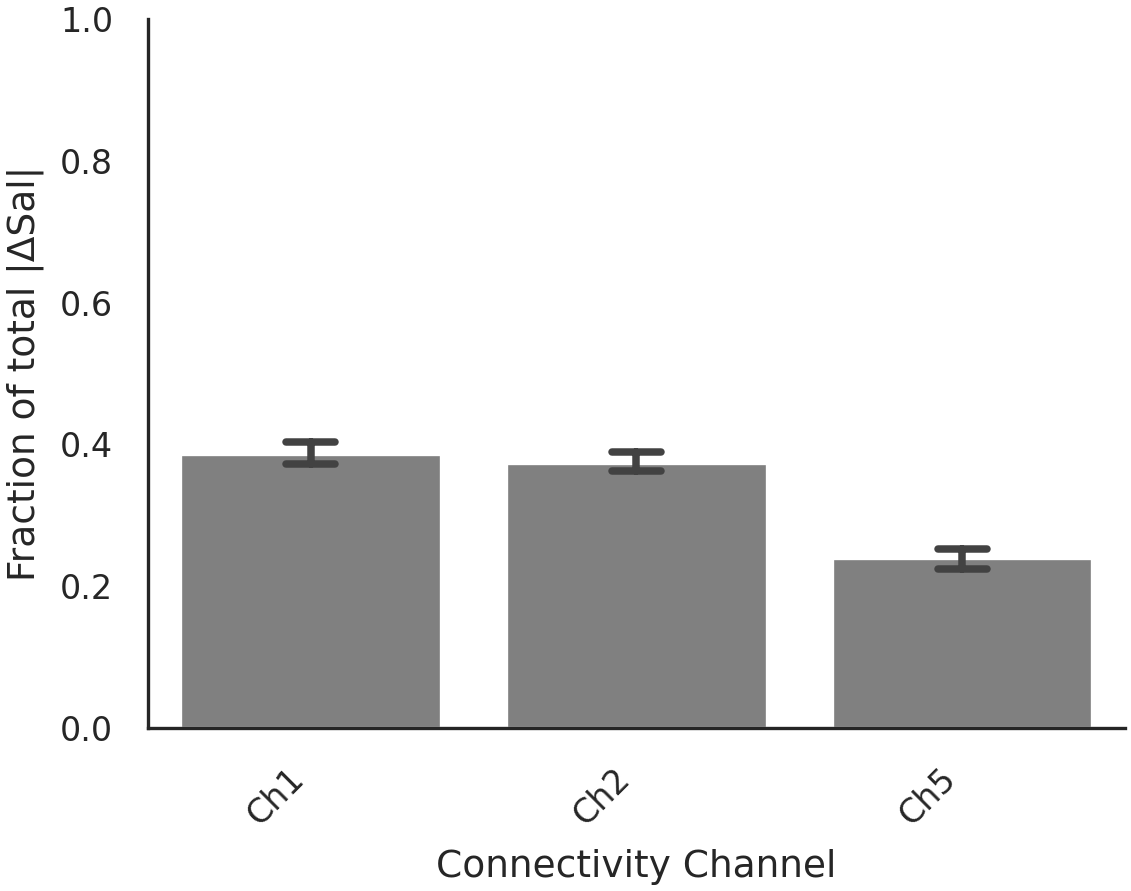

In [25]:
# === NUEVA CELDA: Contribución por canal con IC95 + Wilcoxon apareado ===
import numpy as np, pandas as pd
from scipy.stats import t, wilcoxon
import seaborn as sns, matplotlib.pyplot as plt

assert 'df_contributions_all_folds' in globals(), "Ejecuta antes la celda que concatena channel_contributions de los 5 folds."

# Resumen por canal
agg = (df_contributions_all_folds
       .groupby('channel_name', as_index=False)['l1_norm_fraction_abs']
       .agg(['mean','std','count'])
       .reset_index())
agg['sem'] = agg['std'] / np.sqrt(agg['count'])
agg['ci95'] = t.ppf(0.975, df=agg['count'] - 1) * agg['sem']
display(agg)

# Contraste apareado por fold: no lineales vs Pearson
pivot = df_contributions_all_folds.pivot_table(index='fold', columns='channel_name', values='l1_norm_fraction_abs')
pear = pivot.get('Pearson_Full_FisherZ_Signed')
mi   = pivot.filter(like='MI').iloc[:,0] if any(pivot.columns.str.contains('MI')) else None
dc   = pivot.filter(like='DistanceCorr').iloc[:,0] if any(pivot.columns.str.contains('DistanceCorr')) else None

tests = []
if mi is not None and pear is not None:
    stat,p = wilcoxon(mi, pear, alternative='greater')
    tests.append({'comparison':'MI_kNN > Pearson', 'p_wilcoxon':p, 'median_diff': (mi-pear).median()})
if dc is not None and pear is not None:
    stat,p = wilcoxon(dc, pear, alternative='greater')
    tests.append({'comparison':'DistanceCorr > Pearson', 'p_wilcoxon':p, 'median_diff': (dc-pear).median()})
display(pd.DataFrame(tests))

# Figura compacta para el panel C (media ± IC95)
fig, ax = plt.subplots(figsize=(4, 3.2))
sns.barplot(data=df_contributions_all_folds, x='channel_name', y='l1_norm_fraction_abs',
            errorbar=('ci', 95), color='gray', capsize=.15, ax=ax)
ax.set_xlabel('Connectivity Channel'); ax.set_ylabel('Fraction of total |ΔSal|'); ax.set_ylim(0,1)
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
savefig_nature(fig, FIG_DIR / 'fig_signature_properties_panelC_channels')
plt.show()


[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


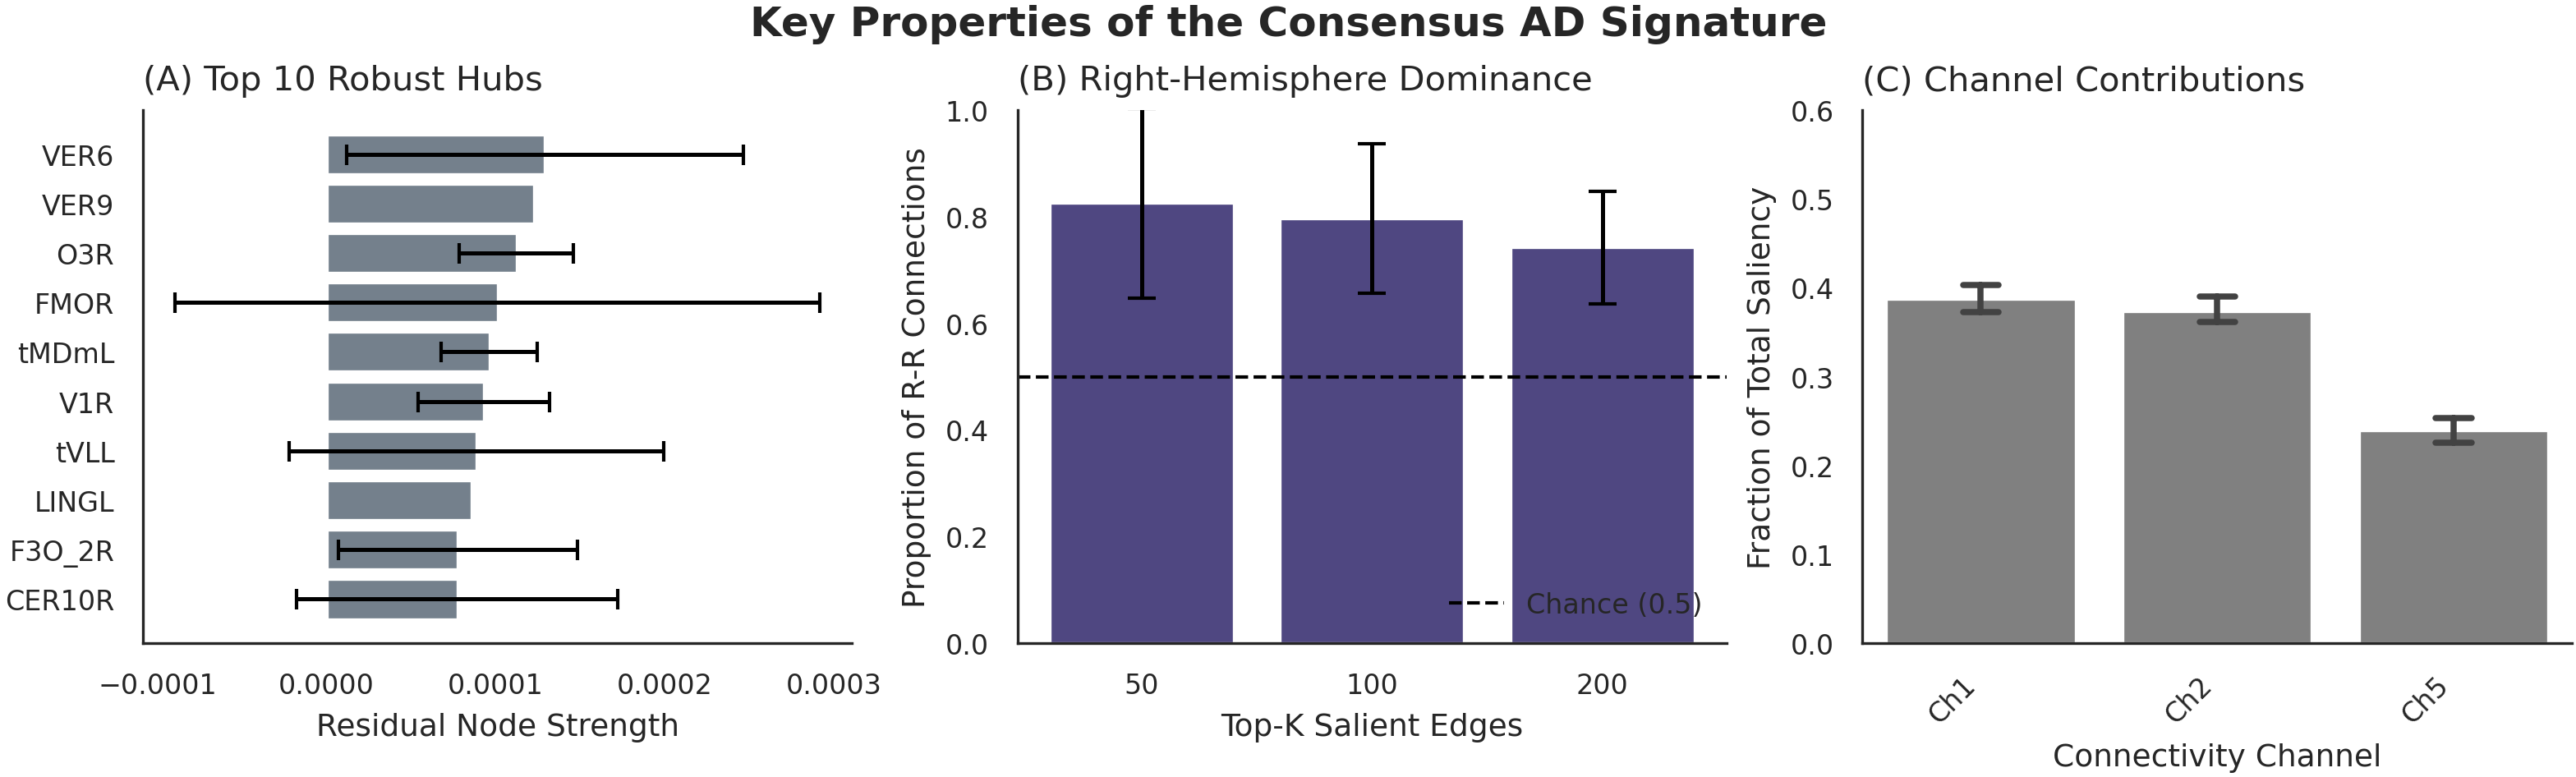

✅ Figura compuesta 'signature_properties' guardada en: Figures_Nature/signature_properties.pdf


In [26]:
# ==============================================================================
# CELDA FINAL: Figura compuesta "signature_properties" (A-B-C) para Q1
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

# --- Verificar que los datos necesarios existen ---
assert 'hubs_agg' in globals(), "Ejecuta la celda de análisis de hubs primero."
assert 'df_lat_plot' in globals(), "Ejecuta la celda 3 (análisis de estabilidad) primero."
assert 'df_contributions_all_folds' in globals(), "Ejecuta la celda de contribución de canales primero."

# ---- (A) Preparar datos para el panel de Hubs ----
topA = (
    hubs_agg
    .groupby('node')
    .agg(mean_resid=('residual_strength', 'mean'),
         sem=('residual_strength', lambda s: s.std(ddof=1) / np.sqrt(s.size) if s.size > 1 else 0),
         n=('residual_strength', 'size'))
    .sort_values('mean_resid', ascending=False)
    .head(10)
    .reset_index()
)
topA['ci95'] = t.ppf(0.975, df=topA['n'] - 1) * topA['sem']

# ---- (B) Preparar datos para el panel de Lateralización ----
agg_B = df_lat_plot.groupby("TopK")["p_RR"].agg(["mean", "count", "std"]).reset_index()
agg_B["sem"] = agg_B["std"] / np.sqrt(agg_B["count"])
agg_B["ci95"] = t.ppf(0.975, df=agg_B["count"] - 1) * agg_B["sem"]

# ---- (C) Preparar datos para el panel de Canales ----
# Los datos ya están en 'df_contributions_all_folds'

# ---- Creación de la Figura Compuesta ----
fig, axs = plt.subplots(1, 3, figsize=(10.5, 3.2), constrained_layout=True)
fig.suptitle('Key Properties of the Consensus AD Signature', fontsize=12, weight='bold')

# ---------- Panel A: Hubs ----------
sns.barplot(ax=axs[0], data=topA, y='node', x='mean_resid', color='slategray', orient='h')
axs[0].errorbar(x=topA['mean_resid'], y=np.arange(len(topA)), xerr=topA['ci95'], fmt='none', ecolor='black', capsize=3)
axs[0].set_title('(A) Top 10 Robust Hubs', loc='left')
axs[0].set_xlabel('Residual Node Strength'); axs[0].set_ylabel('')

# ---------- Panel B: Lateralización ----------
sns.barplot(ax=axs[1], data=agg_B, x='TopK', y='mean', color='darkslateblue')
axs[1].errorbar(x=np.arange(len(agg_B)), y=agg_B['mean'], yerr=agg_B['ci95'], fmt='none', ecolor='black', capsize=4)
axs[1].axhline(0.5, ls='--', c='black', lw=1, label='Chance (0.5)')
axs[1].set_ylim(0, 1.0); axs[1].set_xlabel('Top-K Salient Edges'); axs[1].set_ylabel('Proportion of R-R Connections')
axs[1].set_title('(B) Right-Hemisphere Dominance', loc='left')
axs[1].legend(frameon=False, loc='lower right')

# ---------- Panel C: Canales ----------
# --- LÍNEA CORREGIDA ---
sns.barplot(ax=axs[2], data=df_contributions_all_folds, x='channel_name', y='l1_norm_fraction_abs',
            errorbar=('ci', 95), color='gray', capsize=.15)
axs[2].set_ylim(0, 0.6); axs[2].set_xlabel('Connectivity Channel'); axs[2].set_ylabel('Fraction of Total Saliency')
axs[2].tick_params(axis='x', rotation=45)
plt.setp(axs[2].get_xticklabels(), ha='right')
axs[2].set_title('(C) Channel Contributions', loc='left')

# Guardar la figura
savefig_nature(fig, FIG_DIR / 'signature_properties')
plt.show()

print(f"✅ Figura compuesta 'signature_properties' guardada en: {FIG_DIR / 'signature_properties.pdf'}")

In [27]:
# === Guardar el panel D en PDF y exportar tabla de lateralidad ===
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, binomtest

FIG_DIR = Path('./Figures_Nature'); FIG_DIR.mkdir(exist_ok=True, parents=True)
TBL_DIR = Path('./Tables_Nature');  TBL_DIR.mkdir(exist_ok=True, parents=True)

# --- Recalcular DF para el panel D (si no quedaron en el entorno) ---
df_mean_sal = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("sal")
cohen_df = df_cohen_all[["mean_cohen_d"]].rename(columns={"mean_cohen_d": "cohen_d"})
df_qc = (pd.concat([df_mean_sal, cohen_df], axis=1)
           .dropna()
           .loc[df_mean_sal.index.intersection(consensus_set.index)])

fig, ax = plt.subplots(figsize=(5,5))
rho, pval = spearmanr(df_qc["sal"].abs(), df_qc["cohen_d"].abs())
sns.scatterplot(data=df_qc, x="cohen_d", y="sal", s=60, edgecolor="black", alpha=0.8, ax=ax)
ax.axhline(0, c="grey", ls="--", lw=1); ax.axvline(0, c="grey", ls="--", lw=1)
ax.set_title("(D) Saliency vs. Effect Size", weight="bold")
ax.set_xlabel("Cohen's d (CN ↔ AD)"); ax.set_ylabel("Mean model saliency")
ax.text(0.95, 0.05, f'ρ(|Sal|,|d|) = {rho:.2f} (p={pval:.2e})',
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
# Guarda en PDF para LaTeX:
fig.savefig(FIG_DIR / "figure_D_saliency_vs_effect.pdf", bbox_inches="tight")
plt.close(fig)
print("✅ Guardado D en PDF:", FIG_DIR / "figure_D_saliency_vs_effect.pdf")

# --- Exportar tabla de lateralidad (agregada entre pliegues) ---
def rr_ll_counts(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    rr = (top["hemi_src"] == "R").sum()
    ll = (top["hemi_src"] == "L").sum()
    n  = rr + ll
    prop = rr / n if n else np.nan
    p = binomtest(rr, n, p=0.5, alternative='greater').pvalue if n else np.nan
    return pd.DataFrame({"TopK":[K], "RR_total":[rr], "LL_total":[ll], "prop_RR":[prop], "p_binom":[p]})

Kvals = [50,100,200]
stats_df = pd.concat([rr_ll_counts(df_lat_clean, K) for K in Kvals], ignore_index=True)
stats_df.to_csv(TBL_DIR / "laterality_stats.csv", index=False)
print("✅ Exportada tabla:", TBL_DIR / "laterality_stats.csv")


✅ Guardado D en PDF: Figures_Nature/figure_D_saliency_vs_effect.pdf
✅ Exportada tabla: Tables_Nature/laterality_stats.csv


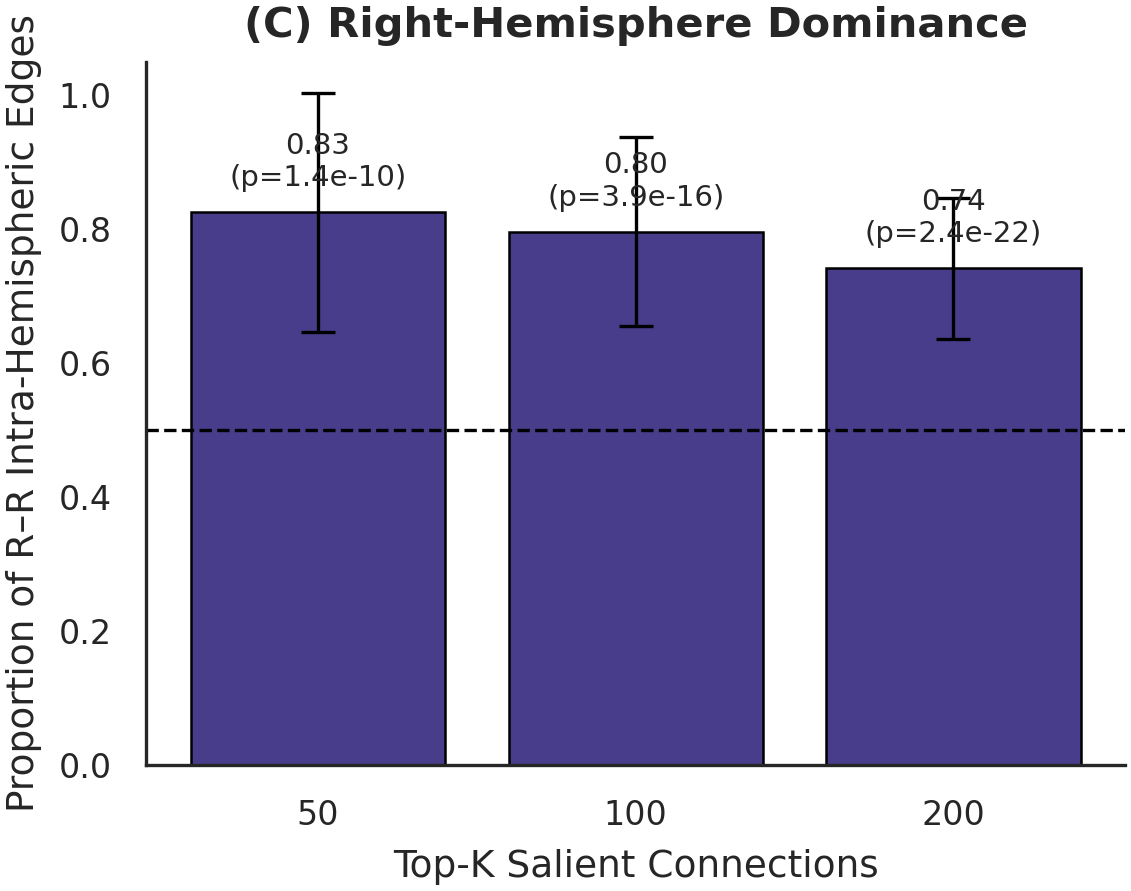

✅ Panel C actualizado con IC95 + p(binomial). Guardado en figure_C_hemisphere_dominance_FINAL.pdf/png
   TopK      mean      ci95  prop_all   p_binom_all
0    50  0.825202  0.178210  0.814433  1.360272e-10
1   100  0.796621  0.140841  0.783505  3.943969e-16
2   200  0.742003  0.105217  0.739241  2.405366e-22


In [28]:
# ===================== CELDA: Panel C FINAL (Right-Hemisphere Dominance) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

assert 'df_lat_clean' in globals(), "Necesito df_lat_clean de la celda de lateralidad"
assert 'df_lat_plot' in globals(), "Necesito df_lat_plot (proporción R-R por fold)"
assert 'stats_df' in globals(), "Ejecuta antes la celda que calcula stats_df con binomial test"

# 1. Reagregamos promedio por K
agg_C = (
    df_lat_plot
    .groupby("TopK", as_index=False)["p_RR"]
    .agg(mean="mean", std="std", count="count")
)
agg_C["sem"] = agg_C["std"] / np.sqrt(agg_C["count"])
agg_C["ci95"] = t.ppf(0.975, df=agg_C["count"]-1) * agg_C["sem"]

# 2. Merge con p-val binomial de todos los folds combinados (stats_df ya lo tiene)
agg_C = agg_C.merge(
    stats_df.rename(columns={"prop_RR":"prop_all", "p_binom":"p_binom_all"})[["TopK","prop_all","p_binom_all"]],
    on="TopK",
    how="left"
)

# 3. Plot bonito
fig_C, ax_C = plt.subplots(figsize=(4, 3.2))

xvals = np.arange(len(agg_C))
bars = ax_C.bar(
    xvals,
    agg_C["mean"],
    color="darkslateblue",
    edgecolor="black",
    linewidth=0.6
)

ax_C.errorbar(
    xvals,
    agg_C["mean"],
    yerr=agg_C["ci95"],
    fmt="none",
    ecolor="black",
    elinewidth=0.8,
    capsize=4,
    capthick=0.8
)

# línea chance
ax_C.axhline(0.5, ls="--", c="black", lw=0.8)
ax_C.set_ylim(0, 1.05)

ax_C.set_xticks(xvals)
ax_C.set_xticklabels(agg_C["TopK"].astype(str))
ax_C.set_xlabel("Top-K Salient Connections")
ax_C.set_ylabel("Proportion of R–R Intra-Hemispheric Edges")
ax_C.set_title("(C) Right-Hemisphere Dominance", weight="bold")

# anotar media y p_binomial
for xi, bar, row in zip(xvals, bars, agg_C.itertuples()):
    ax_C.text(
        xi,
        bar.get_height() + 0.03,
        f"{bar.get_height():.2f}\n(p={row.p_binom_all:.1e})",
        ha="center",
        va="bottom",
        fontsize=7
    )

fig_C.tight_layout()
savefig_nature(fig_C, FIG_DIR / "figure_C_hemisphere_dominance_FINAL")
plt.show()

print("✅ Panel C actualizado con IC95 + p(binomial). Guardado en figure_C_hemisphere_dominance_FINAL.pdf/png")
print(agg_C[["TopK","mean","ci95","prop_all","p_binom_all"]])

# También guardar en SVG
fig_C.savefig(FIG_DIR / "figure_C_hemisphere_dominance_FINAL.svg", format='svg', bbox_inches="tight")



[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


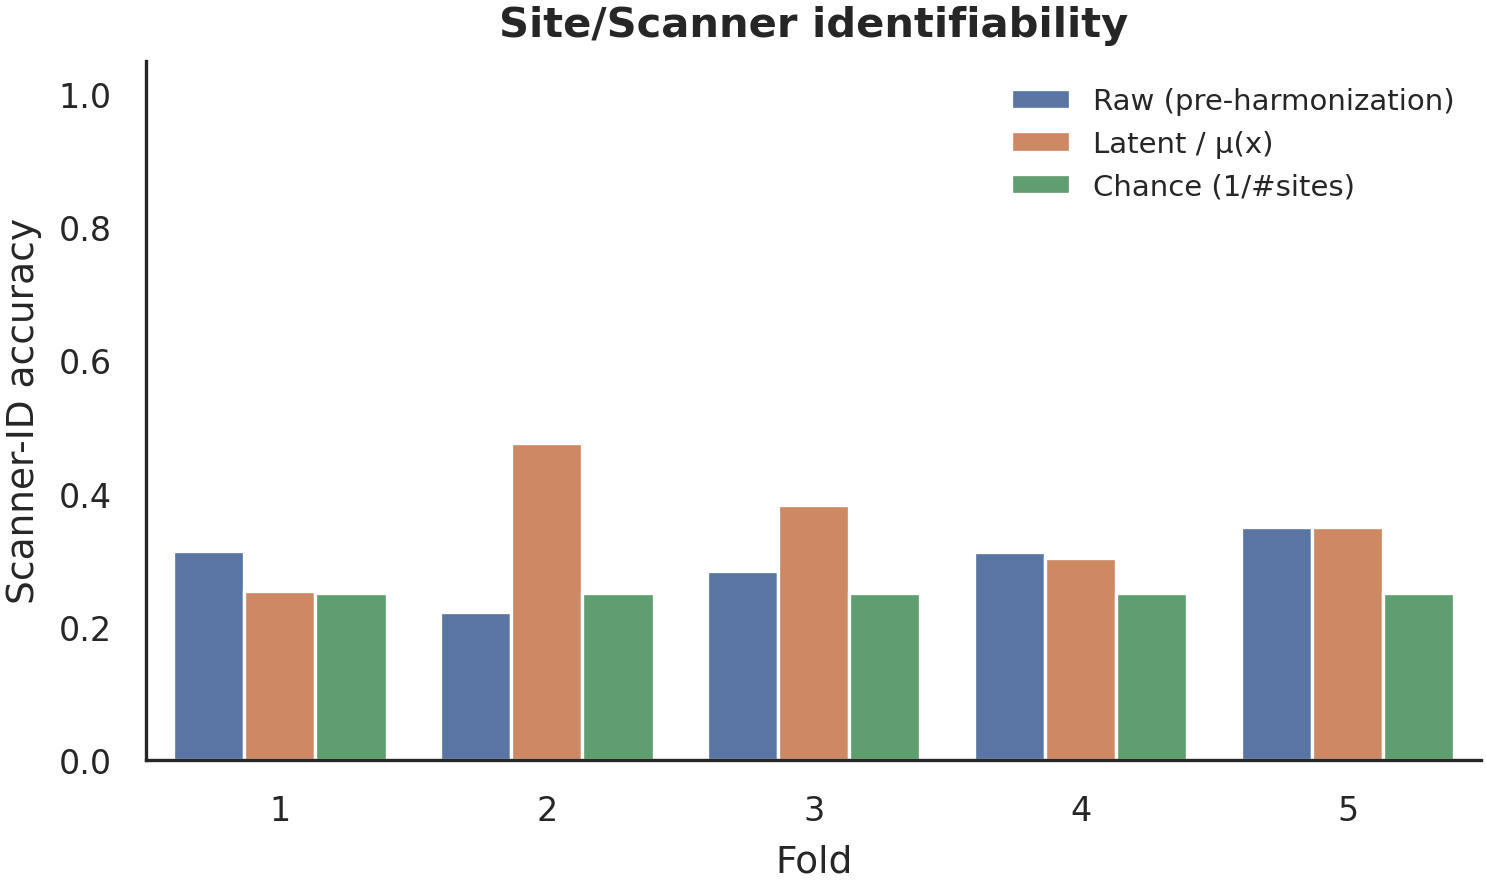

✅ Fig 3 guardada en: Figures_Nature/fig3_scanner_leakage.pdf
✅ Table S2 guardada en: Tables_Nature/TableS2_scanner_leakage.csv
⚠️ No pude generar Supp Fig S1. Claves NPZ disponibles: ['global_tensor_data', 'subject_ids', 'channel_names', 'rois_count', 'target_len_ts', 'tr_seconds', 'filter_low_hz', 'filter_high_hz', 'hrf_deconvolution_applied', 'hrf_model', 'channel_normalization_method_subject', 'notes_on_further_normalization', 'roi_order_name', 'roi_names_in_order', 'network_labels_in_order']


In [29]:
# ============================================================
# CELDA C — ARMONIZACIÓN / FUGA DEL ESCÁNER (Fig 3, Supp Fig S1)
# ============================================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

assert 'df_qc_summary' in globals(), "Corre Celda B primero (df_qc_summary)."

# ------------------------------------------------------------
# 1. FIG 3: Leakage por fold (raw vs latent) con chance
# ------------------------------------------------------------
leak_cols = []
if 'acc_site_raw' in df_qc_summary.columns:
    leak_cols.append('acc_site_raw')
if 'acc_site_latent' in df_qc_summary.columns:
    leak_cols.append('acc_site_latent')

if not leak_cols:
    print("⚠️ No tengo columnas de fuga de escáner ('acc_site_raw' / 'acc_site_latent') en df_qc_summary. Saltando Fig 3.")
else:
    leak_plot_df = df_qc_summary[['fold'] + leak_cols + (['chance_level'] if 'chance_level' in df_qc_summary.columns else [])].copy()
    # melt para barras agrupadas
    value_vars = [c for c in ['acc_site_raw','acc_site_latent','chance_level'] if c in leak_plot_df.columns]
    leak_long = leak_plot_df.melt(id_vars='fold',
                                  value_vars=value_vars,
                                  var_name='source',
                                  value_name='acc')
    source_map = {
        'acc_site_raw': 'Raw (pre-harmonization)',
        'acc_site_latent': 'Latent / μ(x)',
        'chance_level': 'Chance (1/#sites)'
    }
    leak_long['source'] = leak_long['source'].map(source_map).fillna(leak_long['source'])

    fig3, ax3 = plt.subplots(figsize=(5,3), constrained_layout=True)
    sns.barplot(
        data=leak_long, x='fold', y='acc', hue='source',
        ax=ax3, capsize=.15
    )
    ax3.set_ylim(0,1.05)
    ax3.set_ylabel("Scanner-ID accuracy")
    ax3.set_xlabel("Fold")
    ax3.set_title("Site/Scanner identifiability", weight='bold')
    ax3.legend(frameon=False, fontsize=7)

    savefig_nature(fig3, FIG_DIR / "fig3_scanner_leakage")
    plt.show()
    print("✅ Fig 3 guardada en:", FIG_DIR / "fig3_scanner_leakage.pdf")

    # Exportar tabla S2
    tableS2_path = TBL_DIR / "TableS2_scanner_leakage.csv"
    df_qc_summary.to_csv(tableS2_path, index=False)
    print("✅ Table S2 guardada en:", tableS2_path)

# ------------------------------------------------------------
# 2. Supp Fig S1: QC de normalización / reconstrucción
# ------------------------------------------------------------
# Intento reconstruir histogramas de pesos de conectividad:
#  - "raw" (antes de armonizar)
#  - "input"/"norm" (lo que entra al modelo)
#  - "recon" (reconstrucción VAE)
# Si no las encuentro en el NPZ, solo aviso.

def _pick_first_key(available_keys, substrings):
    for sub in substrings:
        for k in available_keys:
            if sub.lower() in k.lower():
                return k
    return None

try:
    npz_dbg = np.load(GLOBAL_TENSOR_PATH)
    available_keys = list(npz_dbg.keys())
except Exception as e:
    npz_dbg = None
    available_keys = []
    print(f"⚠️ No pude abrir GLOBAL_TENSOR_PATH para hist QC ({e}).")

if npz_dbg is not None:
    key_raw   = _pick_first_key(available_keys, ['raw','orig','original','unscaled'])
    key_norm  = _pick_first_key(available_keys, ['global_tensor_data','norm','zscore','scaled'])
    key_recon = _pick_first_key(available_keys, ['recon','reconstructed','vae','decoded'])

    def _offdiag_values(arr_4d):
        # arr_4d puede ser [n_subj, n_chan, R, R] o [n_subj, R, R]
        arr = arr_4d
        if arr.ndim == 4:
            arr = arr.mean(axis=1)  # promediamos canales
        # arr ahora [n_subj, R, R]
        n_subj, R1, R2 = arr.shape
        vals = []
        for ii in range(R1):
            for jj in range(R2):
                if ii < jj:
                    vals.append(arr[:, ii, jj])
        if len(vals) == 0:
            return np.array([])
        return np.concatenate(vals, axis=0)

    have_all = (key_raw is not None) and (key_norm is not None) and (key_recon is not None)
    if have_all:
        vals_raw  = _offdiag_values(npz_dbg[key_raw])
        vals_norm = _offdiag_values(npz_dbg[key_norm])
        vals_rec  = _offdiag_values(npz_dbg[key_recon])

        figS1, axsS1 = plt.subplots(1,3, figsize=(9,3), sharey=True, constrained_layout=True)
        panels = [
            ("Raw / pre-harmonization", vals_raw),
            ("Harmonized / model input", vals_norm),
            ("VAE reconstruction", vals_rec),
        ]
        for ax, (title, arr_vals) in zip(axsS1, panels):
            sns.histplot(arr_vals, bins=40, stat='density', ax=ax)
            ax.set_title(title, fontsize=9)
            ax.set_xlabel("Edge weight")
            ax.set_ylabel("Density")
        savefig_nature(figS1, FIG_DIR / "figS1_QC_preproc")
        plt.show()
        print("✅ Supp Fig S1 guardada en:", FIG_DIR / "figS1_QC_preproc.pdf")
    else:
        print("⚠️ No pude generar Supp Fig S1. Claves NPZ disponibles:", available_keys)
 

In [30]:
# =================== CELDA CARGA MAESTRA (MEJORADA) ===================
import numpy as np
import pandas as pd
from pathlib import Path

# --- Carga inicial (como antes) ---
try:
    _npz = np.load(GLOBAL_TENSOR_PATH)
    global_tensor_data = _npz["global_tensor_data"]  # [n_subj, n_channels_total, R, R]
    subject_ids_all = _npz["subject_ids"].astype(str)
    print(f"✔️ Tensor global cargado: {global_tensor_data.shape}")
except Exception as e:
    raise FileNotFoundError(f"Error cargando tensor global desde {GLOBAL_TENSOR_PATH}: {e}")

try:
    meta = pd.read_csv(METADATA_PATH)
    meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()
    print(f"✔️ Metadatos cargados: {meta.shape}")
except Exception as e:
    raise FileNotFoundError(f"Error cargando metadatos desde {METADATA_PATH}: {e}")

# --- Merge y filtro CN/AD (como antes) ---
idx_df = pd.DataFrame({"SubjectID": subject_ids_all, "tensor_idx": np.arange(len(subject_ids_all))})
cnad_df_raw = (
    idx_df.merge(meta, on="SubjectID", how="left")
    .query("ResearchGroup_Mapped in ['CN', 'AD']")
    .reset_index(drop=True)
)
print(f"ℹ️ Sujetos CN/AD iniciales: {len(cnad_df_raw)}")

# --- VALIDACIÓN Y LIMPIEZA DE METADATOS CLAVE ---
cnad_df = cnad_df_raw.copy() # Trabajar sobre una copia

# 1. Validar y limpiar 'Sex' -> {'M', 'F', NaN}
if 'Sex' in cnad_df.columns:
    original_sex_counts = cnad_df['Sex'].value_counts(dropna=False)
    # Mapear valores comunes (0/1, m/f) a M/F estándar
    cnad_df['Sex'] = (
        cnad_df['Sex']
        .replace({0: 'M', 1: 'F', 'm': 'M', 'f': 'F'}) # Mapeo inicial
        .astype(str).str.upper() # Convertir a string y mayúsculas
        .replace({'NONE': np.nan, '': np.nan, 'NAN': np.nan}) # Manejar strings vacíos/nulos
    )
    # Dejar NaN si no es M o F después de la limpieza
    cnad_df['Sex'] = cnad_df['Sex'].where(cnad_df['Sex'].isin(['M', 'F']), np.nan)
    cleaned_sex_counts = cnad_df['Sex'].value_counts(dropna=False)
    if not cleaned_sex_counts.equals(original_sex_counts.rename(index=str).rename(index=str.upper)):
         print(f"⚠️ Columna 'Sex' limpiada. Original: {dict(original_sex_counts)}, Limpio: {dict(cleaned_sex_counts)}")
    else:
         print(f"✔️ Columna 'Sex' validada: {dict(cleaned_sex_counts)}")
else:
    print("⚠️ Columna 'Sex' no encontrada en metadatos.")

# 2. Validar y limpiar 'Age' -> numérico o NaN
if 'Age' in cnad_df.columns:
    original_age_type = cnad_df['Age'].dtype
    cnad_df['Age'] = pd.to_numeric(cnad_df['Age'], errors='coerce')
    n_nan_age = cnad_df['Age'].isna().sum()
    if original_age_type != cnad_df['Age'].dtype or n_nan_age > 0:
        print(f"⚠️ Columna 'Age' convertida a numérico. {n_nan_age} valores no numéricos convertidos a NaN.")
    else:
        print(f"✔️ Columna 'Age' validada como numérica.")
    if n_nan_age > 0:
         print(f"   -> Ejemplo de filas con Age=NaN:\n{cnad_df_raw[cnad_df['Age'].isna()].head(2)}")
else:
    print("⚠️ Columna 'Age' no encontrada en metadatos.")

# --- Resumen final ---
print(f"\n✅ cnad_df final listo: {cnad_df.shape[0]} sujetos AD/CN")
print("\nResumen de tipos y nulos en cnad_df:")
cnad_df[['tensor_idx', 'SubjectID', 'ResearchGroup_Mapped', 'Age', 'Sex']].info()
print("\nEstadísticas descriptivas básicas:")
display(cnad_df[['Age']].describe().T)
print("\nDistribución de Sexo:")
display(cnad_df['Sex'].value_counts(dropna=False))

✔️ Tensor global cargado: (431, 7, 131, 131)
✔️ Metadatos cargados: (434, 33)
ℹ️ Sujetos CN/AD iniciales: 184
✔️ Columna 'Sex' validada: {'F': 92, 'M': 92}
✔️ Columna 'Age' validada como numérica.

✅ cnad_df final listo: 184 sujetos AD/CN

Resumen de tipos y nulos en cnad_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tensor_idx            184 non-null    int64  
 1   SubjectID             184 non-null    object 
 2   ResearchGroup_Mapped  184 non-null    object 
 3   Age                   184 non-null    float64
 4   Sex                   184 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 7.3+ KB

Estadísticas descriptivas básicas:


count       mean       std   min     25%    50%   75%   max
Age  184.0  74.352717  7.410566  55.3  69.625  74.35  79.4  94.7


Distribución de Sexo:


Sex
F    92
M    92
Name: count, dtype: int64

In [31]:
# ============================================================
# CELDA D — BALANCE COHORTES POR FOLD (Table S1, versión final)
# Genera la tabla demográfica / de procedencia por fold (train/test)
# y una fila global "ALL" lista para Supplementary Table S1.
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import t

# ------------------------------------------------------------------
# 0. Chequeos básicos de dependencias en el workspace
#    (estas variables ya existen si corriste las celdas previas)
# ------------------------------------------------------------------
assert 'cnad_df' in globals(), "cnad_df no existe. Corre las celdas de carga de metadata."
assert 'fold_indices' in globals(), "fold_indices no existe. Corre la celda donde armaste train/test por fold."
assert 'N_FOLDS' in globals(), "N_FOLDS no definido."
assert 'TBL_DIR' in globals(), "TBL_DIR no definido (debería venir de la celda 0)."

# ------------------------------------------------------------------
# 1. Normalización mínima de columnas clave en cnad_df
#    (esto lo hacemos por si vienes de un kernel limpio)
# ------------------------------------------------------------------
cnad_df = cnad_df.copy()

# Edad -> numérico
if 'Age' in cnad_df.columns:
    cnad_df['Age'] = pd.to_numeric(cnad_df['Age'], errors='coerce')

# Sexo -> 'M' / 'F' consistente (útil para %Female)
if 'Sex' in cnad_df.columns:
    cnad_df['Sex'] = (
        cnad_df['Sex']
        .replace({0:'M', 1:'F', 'm':'M', 'f':'F'})
        .astype(str)
        .str.upper()
    )

# ------------------------------------------------------------------
# 2. Helper functions para métricas demográficas
# ------------------------------------------------------------------
def mean_sd_str(x, ndigits=1):
    """
    Devuelve 'media ± sd' con 1 decimal.
    Si hay <2 valores válidos, devolvemos 'NA' para no mentirle al revisor.
    """
    x = pd.to_numeric(pd.Series(x), errors='coerce').dropna()
    if len(x) < 2:
        return "NA"
    return f"{x.mean():.{ndigits}f} ± {x.std(ddof=1):.{ndigits}f}"

def pct_female(series_sex):
    """
    Porcentaje de sujetos etiquetados como F (sobre F+M).
    Devuelve 'NA' si no hay datos.
    """
    s = pd.Series(series_sex).astype(str).str.upper()
    mask = s.isin(['M','F'])
    if mask.sum() == 0:
        return "NA"
    prop_f = (s[mask] == 'F').mean()
    return f"{100.0 * prop_f:.1f}%"

def pick_site_col(df):
    """    Adivina qué columna representa 'sitio / escáner / centro'.    """
    # Prioriza 'Site3' o 'AcqSite' ANTES que 'Manufacturer'
    candidates_priority = [
        "Site3",  # <-- Añadido al inicio
        "AcquisitionSite", "AcqSite",
        "Site", "ScannerSite",
        "Center", "ScannerCenter",
        "ScannerManufacturer", "Manufacturer", # <-- Siguen aquí pero con menos prioridad
        "ManufacturerModelName", "ScannerVendor"
    ]
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates_priority:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

site_col = pick_site_col(cnad_df)
print(f"🛰  Columna elegida como 'sitio/escáner': {site_col}")

# ------------------------------------------------------------------
# 3. Recorremos folds y computamos stats train/test
# ------------------------------------------------------------------
rows = []

for f in range(1, N_FOLDS + 1):

    tr_idx = fold_indices[f]['train']  # índices sobre cnad_df
    te_idx = fold_indices[f]['test']

    df_tr = cnad_df.iloc[tr_idx].copy()
    df_te = cnad_df.iloc[te_idx].copy()

    # Diagnóstico (AD / CN)
    grp_tr = df_tr['ResearchGroup_Mapped']
    grp_te = df_te['ResearchGroup_Mapped']

    # Conteos básicos
    n_tr  = len(df_tr)
    n_te  = len(df_te)

    n_tr_CN = (grp_tr == 'CN').sum()
    n_tr_AD = (grp_tr == 'AD').sum()
    n_te_CN = (grp_te == 'CN').sum()
    n_te_AD = (grp_te == 'AD').sum()

    # Edad
    age_tr_desc = mean_sd_str(df_tr['Age']) if 'Age' in df_tr.columns else "NA"
    age_te_desc = mean_sd_str(df_te['Age']) if 'Age' in df_te.columns else "NA"

    # Sexo
    fem_tr = pct_female(df_tr['Sex']) if 'Sex' in df_tr.columns else "NA"
    fem_te = pct_female(df_te['Sex']) if 'Sex' in df_te.columns else "NA"

    # Sitio / escáner
    if site_col is not None and site_col in df_tr.columns:
        n_sites_tr = df_tr[site_col].nunique(dropna=True)
        n_sites_te = df_te[site_col].nunique(dropna=True)

        # Top 3 sitios en test (esto ayuda a demostrar diversidad, evita leakage monocéntrico)
        top_sites_te_counts = (
            df_te[site_col]
            .value_counts(dropna=True)
            .head(3)
            .to_dict()
        )
        # Lo convertimos a string legible "SiteA:10; SiteB:7; ..."
        if len(top_sites_te_counts) > 0:
            top_sites_te_str = "; ".join([f"{k}:{v}" for k,v in top_sites_te_counts.items()])
        else:
            top_sites_te_str = "NA"
    else:
        n_sites_tr = np.nan
        n_sites_te = np.nan
        top_sites_te_str = "NA"

    rows.append({
        "fold": f,

        # tamaños por split
        "N_train": n_tr,
        "N_test": n_te,

        # balance diagnóstico
        "CN_train": n_tr_CN,
        "AD_train": n_tr_AD,
        "CN_test": n_te_CN,
        "AD_test": n_te_AD,

        # edad (media ± sd)
        "Age_train_mean±sd": age_tr_desc,
        "Age_test_mean±sd":  age_te_desc,

        # sexo
        "%Female_train": fem_tr,
        "%Female_test":  fem_te,

        # procedencia / escáner
        "N_sites_train": n_sites_tr,
        "N_sites_test":  n_sites_te,
        "TopSites_test_example": top_sites_te_str,
    })

cohort_balance_df = pd.DataFrame(rows)

# ------------------------------------------------------------------
# 4. Agregamos una fila "ALL" para el conjunto completo CN+AD
# ------------------------------------------------------------------
all_grp = cnad_df['ResearchGroup_Mapped']

if site_col is not None and site_col in cnad_df.columns:
    n_sites_total = cnad_df[site_col].nunique(dropna=True)
else:
    n_sites_total = np.nan

row_all = {
    "fold": "ALL",

    # en "ALL" ponemos todo en columnas *_train por consistencia visual
    "N_train": len(cnad_df),
    "N_test": "",

    "CN_train": (all_grp == 'CN').sum(),
    "AD_train": (all_grp == 'AD').sum(),
    "CN_test": "",
    "AD_test": "",

    "Age_train_mean±sd": mean_sd_str(cnad_df['Age']) if 'Age' in cnad_df.columns else "NA",
    "Age_test_mean±sd": "",

    "%Female_train": pct_female(cnad_df['Sex']) if 'Sex' in cnad_df.columns else "NA",
    "%Female_test":  "",

    "N_sites_train": n_sites_total,
    "N_sites_test":  "",
    "TopSites_test_example": "NA"
}

cohort_balance_df = pd.concat(
    [cohort_balance_df, pd.DataFrame([row_all])],
    ignore_index=True
)

# ------------------------------------------------------------------
# 5. Guardar CSV final en carpeta de tablas del paper
# ------------------------------------------------------------------
out_path_s1 = Path(TBL_DIR) / "TableS1_cohort_balance.csv"
cohort_balance_df.to_csv(out_path_s1, index=False)

print("✅ Table S1 generada y guardada en:", out_path_s1)
display(cohort_balance_df)
 

🛰  Columna elegida como 'sitio/escáner': Site3
✅ Table S1 generada y guardada en: Tables_Nature/TableS1_cohort_balance.csv


fold  N_train N_test  CN_train  AD_train CN_test AD_test Age_train_mean±sd  \
0    1      147     37        71        76      18      19        74.1 ± 7.7   
1    2      147     37        71        76      18      19        74.8 ± 7.6   
2    3      147     37        71        76      18      19        74.5 ± 7.2   
3    4      147     37        71        76      18      19        74.6 ± 7.6   
4    5      148     36        72        76      17      19        73.8 ± 6.9   
5  ALL      184               89        95                        74.4 ± 7.4   

  Age_test_mean±sd %Female_train %Female_test  N_sites_train N_sites_test  \
0       75.4 ± 6.2         49.7%        51.4%             32           19   
1       72.6 ± 6.5         49.7%        51.4%             32           19   
2       73.8 ± 8.2         50.3%        48.6%             33           23   
3       73.4 ± 6.7         50.3%        48.6%             32           20   
4       76.6 ± 8.9         50.0%        50.0%             31           20   
5                          50.0%                          33                

  TopSites_test_example  
0    130:9; 18:4; 168:3  
1      130:5; 6:4; 18:3  
2    130:9; 100:3; 13:3  
3    130:5; 100:4; 19:3  
4      19:5; 130:5; 2:3  
5                    NA

AAL NIfTI usado: AAL3v1.nii.gz
AAL MAT usado : ROI_MNI_V7_List.mat
AAL TXT visto : AAL3v1.nii.txt
AAL XML visto : AAL3v1.xml
✅ Todos los ROI del consenso se mapearon a IDs del atlas AAL3.


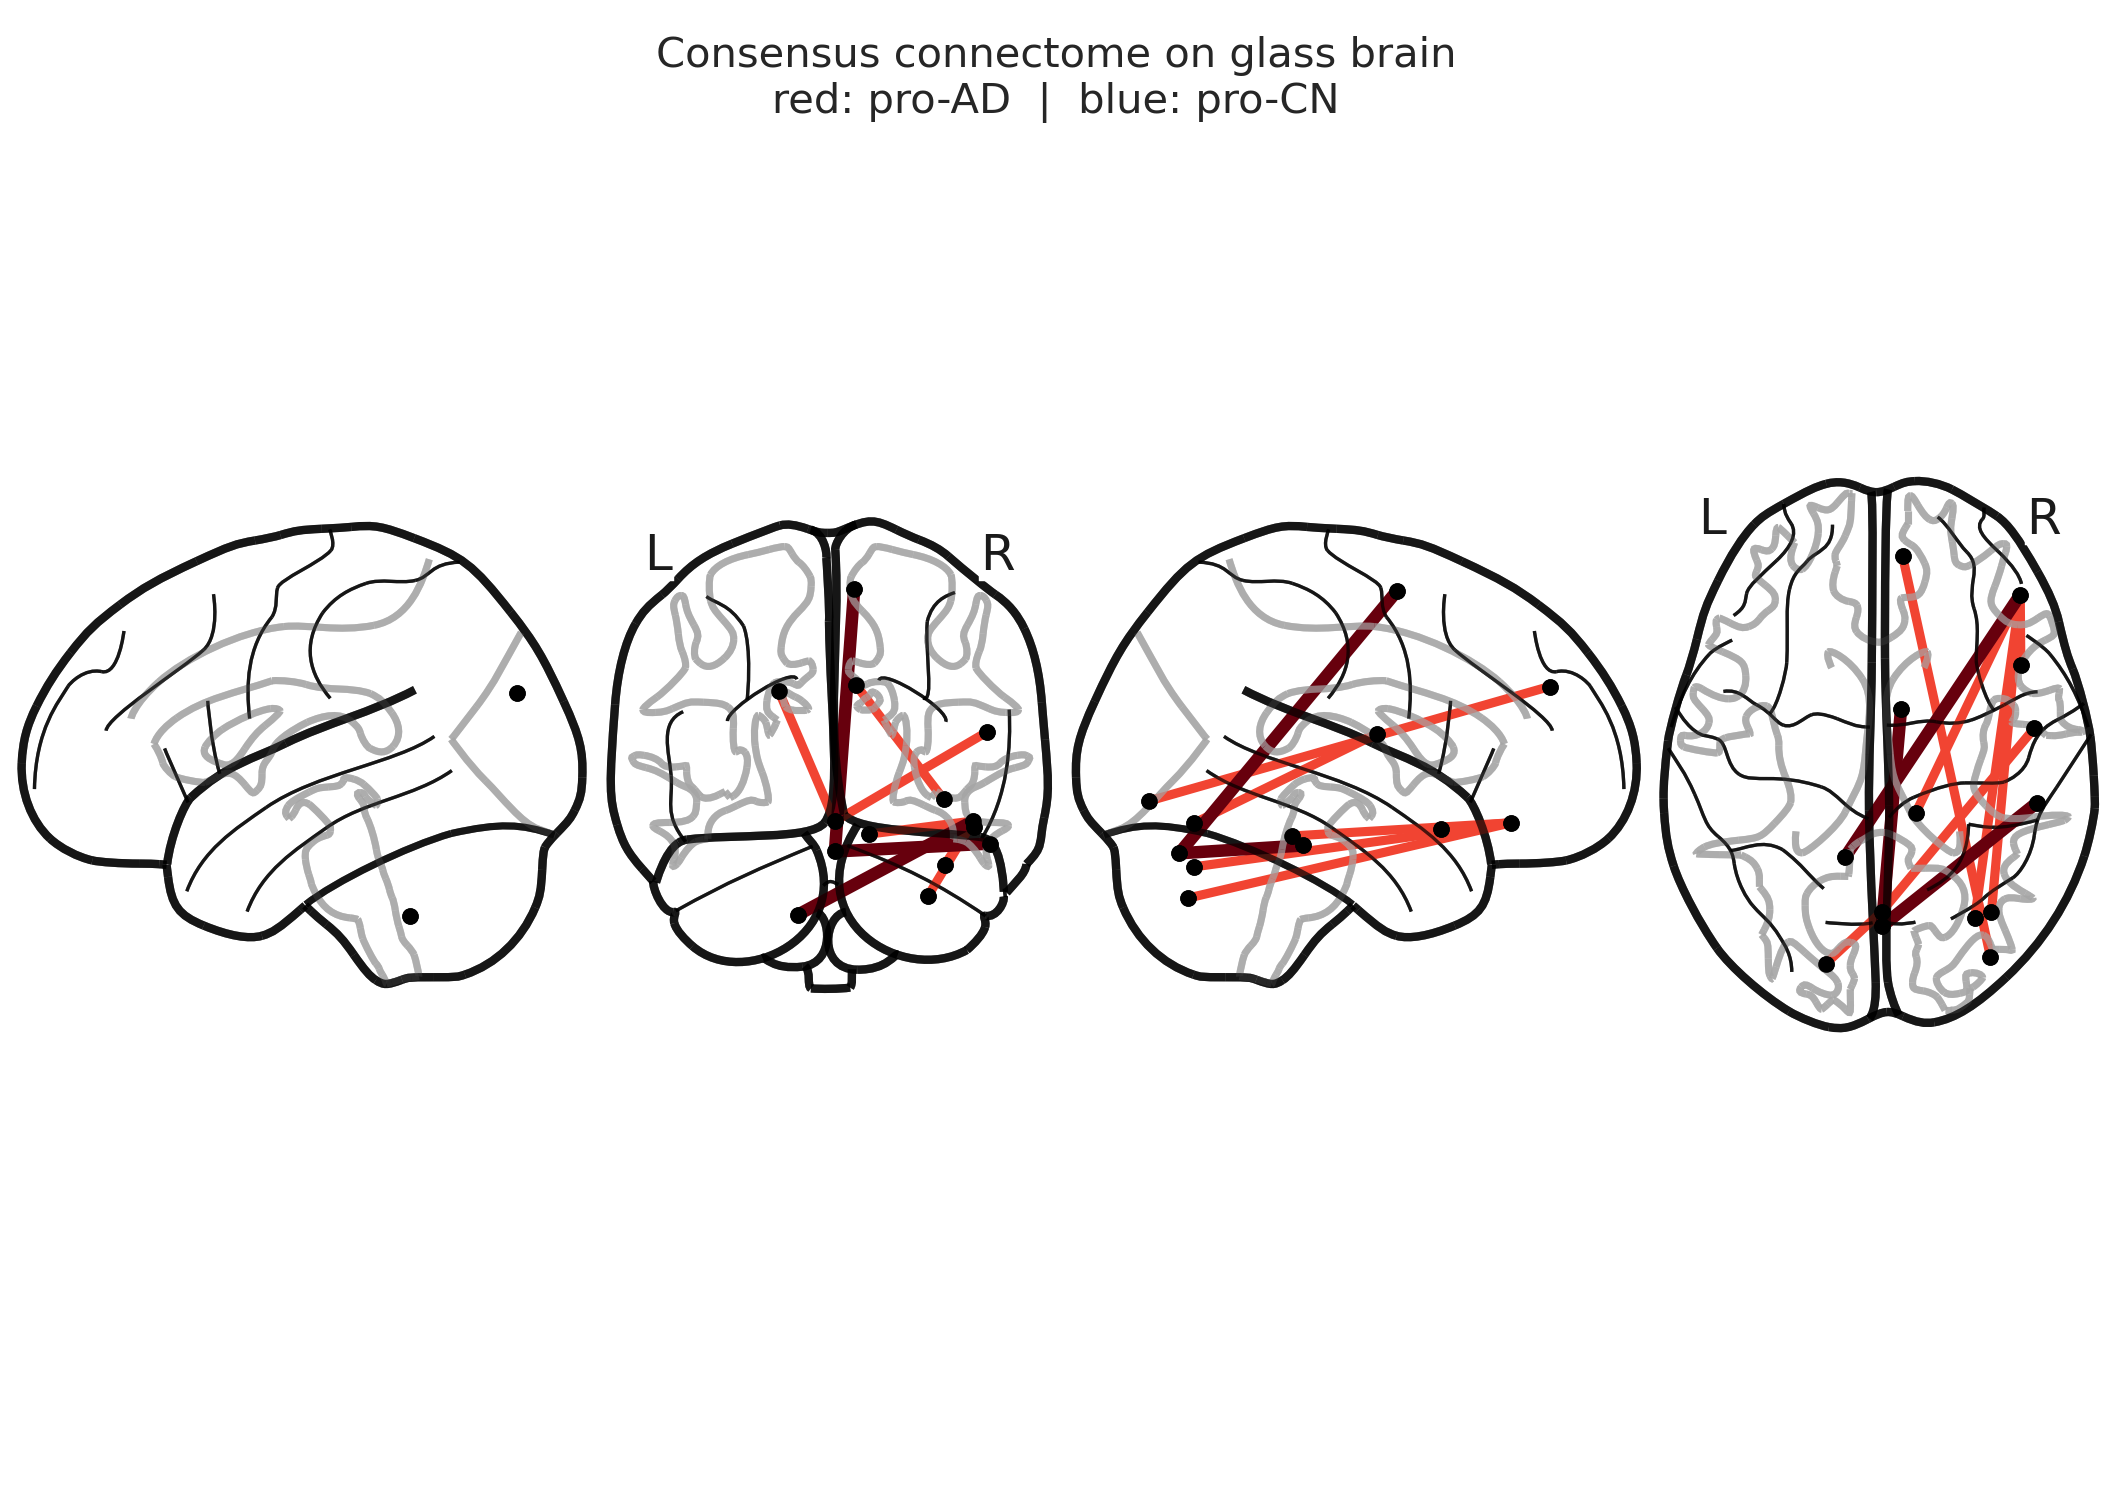

✅ Figuras generadas: connectome + mapa nodal.


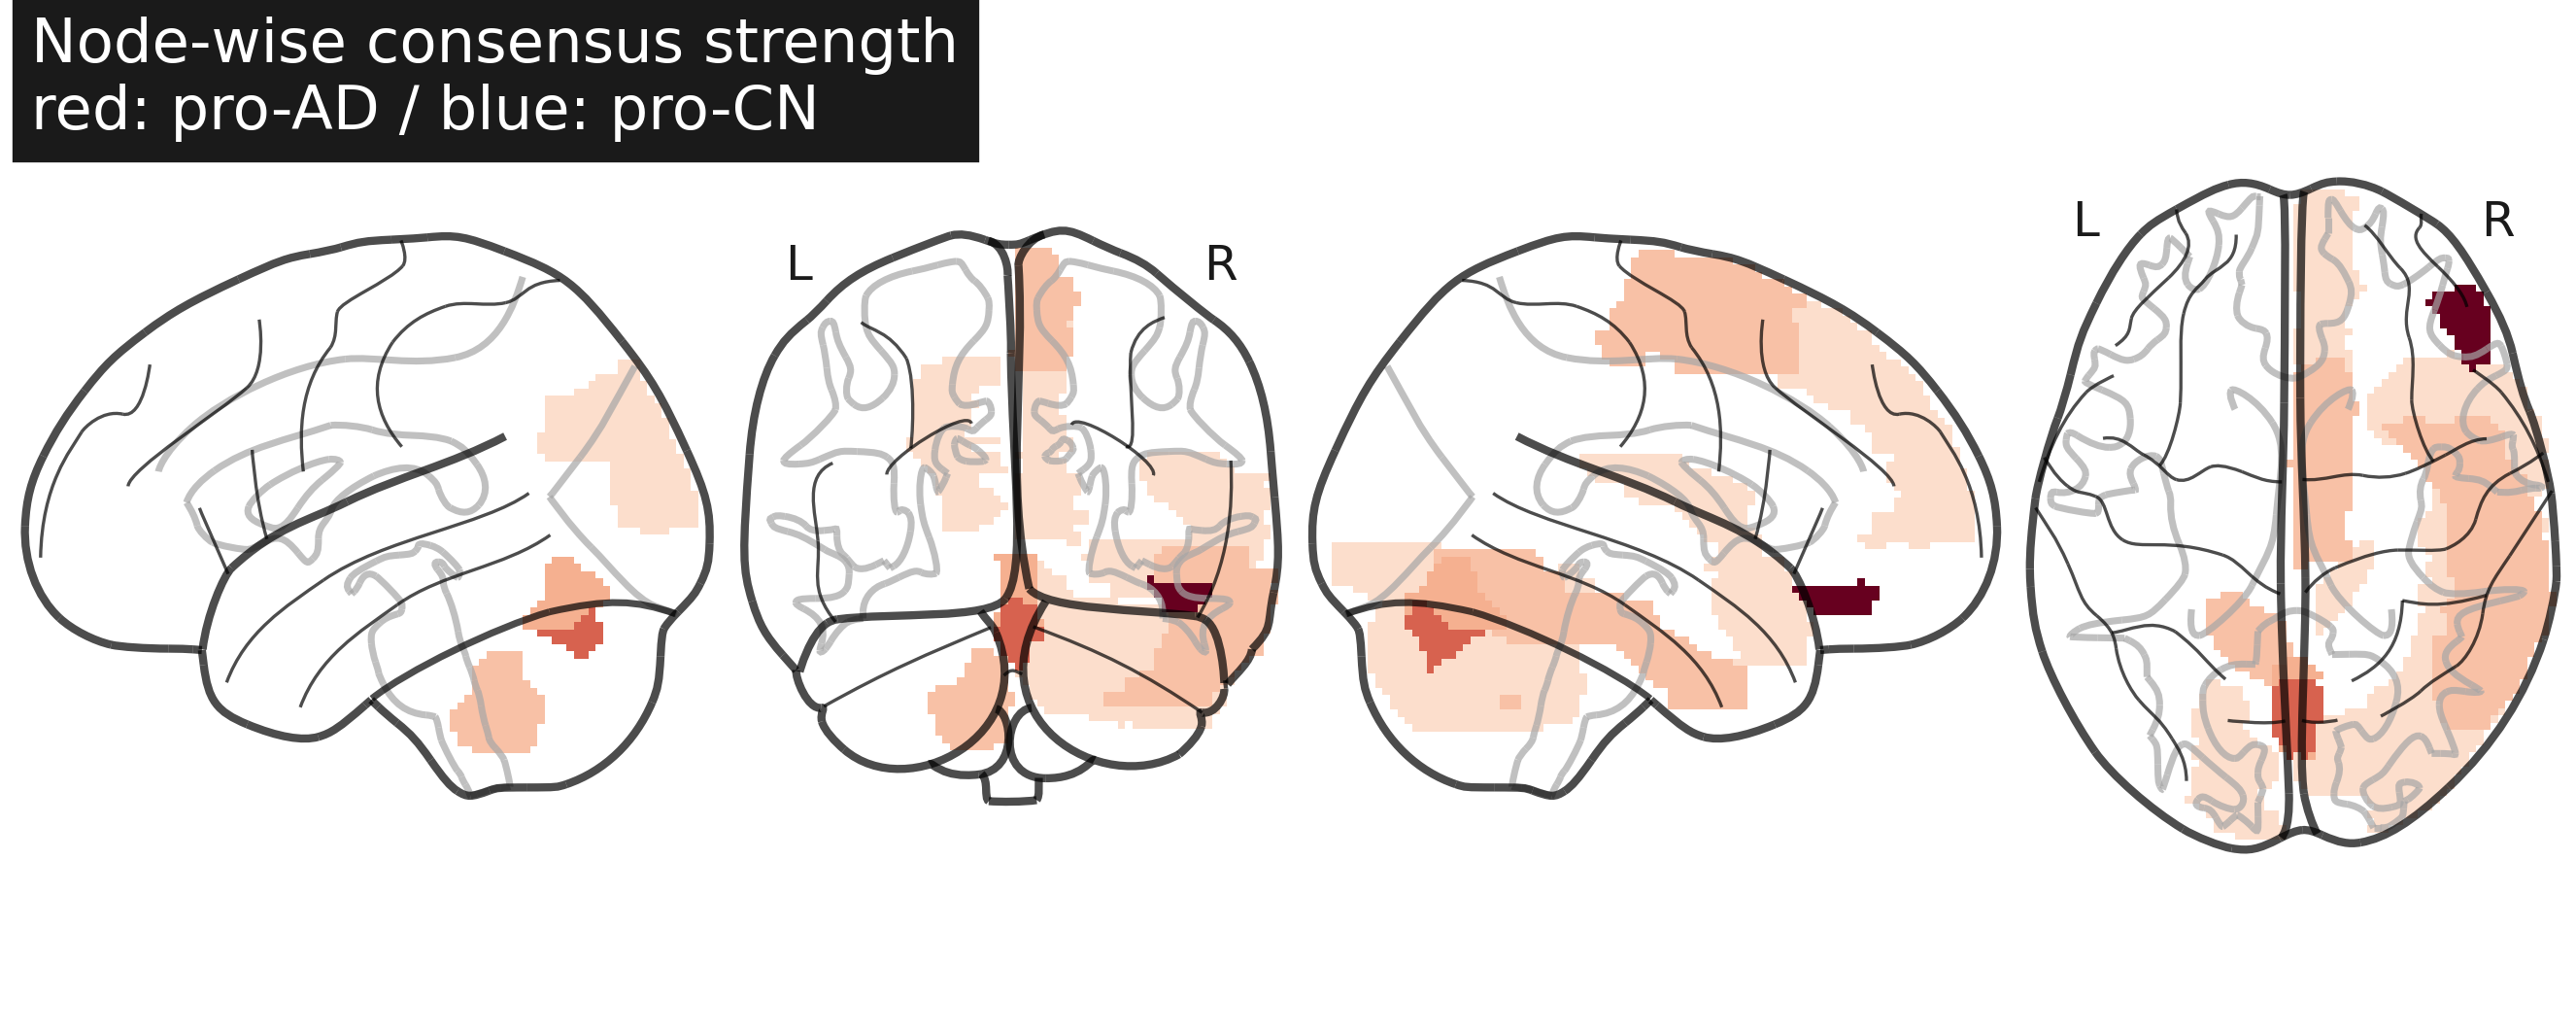

In [32]:
# ===========================
# GLASS BRAIN con AAL3 + CONSENSUS_SET (versión robusta)
# ===========================
import re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.io import loadmat
import matplotlib.pyplot as plt

from nilearn.image import new_img_like
from nilearn.plotting import (
    plot_connectome, plot_glass_brain, find_xyz_cut_coords
)

# -------------------------------------------------
# 0) Localiza AAL3 en tu máquina
#    (ajusta esta ruta si la tienes en otro lado)
# -------------------------------------------------
AAL3_DIR = Path("/home/diego/Escritorio/AAL3v1_for_SPM12/AAL3")

cand_nii = [
    AAL3_DIR/"AAL3v1.nii.gz",
    AAL3_DIR/"AAL3v1.nii",
    AAL3_DIR/"ROI_MNI_V7.nii",
]
cand_mat = [
    AAL3_DIR/"ROI_MNI_V7_List.mat",
    AAL3_DIR/"ROI_MNI_V7_1mm_List.mat",
]

cand_txt = [
    AAL3_DIR/"AAL3v1.nii.txt",
    AAL3_DIR/"ROI_MNI_V7_vol.txt",
]

cand_xml = [
    AAL3_DIR/"AAL3v1.xml",
    AAL3_DIR/"ROI_MNI_V7.xml",
]

AAL_NII = next((p for p in cand_nii if p.exists()), None)
AAL_MAT = next((p for p in cand_mat if p.exists()), None)
AAL_TXT = next((p for p in cand_txt if p.exists()), None)
AAL_XML = next((p for p in cand_xml if p.exists()), None)

assert AAL_NII is not None,  "❌ No encuentro el NIfTI del atlas AAL3."
assert AAL_MAT is not None,  "❌ No encuentro ROI_MNI_V7_List.mat (lo necesito sí o sí)."

print(f"AAL NIfTI usado: {AAL_NII.name}")
print(f"AAL MAT usado : {AAL_MAT.name}")
if AAL_TXT: print(f"AAL TXT visto : {AAL_TXT.name}")
if AAL_XML: print(f"AAL XML visto : {AAL_XML.name}")

# -------------------------------------------------
# 1) Helpers para normalizar nombres
# -------------------------------------------------
def _canon(s: str) -> str:
    """Versión mayúsculas sin símbolos para matching laxo."""
    return re.sub(r"[^A-Za-z0-9]", "", str(s)).upper()

def _abbr_tokens(name: str) -> str:
    """
    Abrevia un nombre 'Cerebelum_Crus1_R' -> 'CERCRU1R'
    Coincide con el estilo de tus ROI.
    """
    toks = re.split(r"[^A-Za-z0-9]+", name)
    short = []
    for t in toks:
        if not t:
            continue
        if t.isdigit():
            short.append(t)
        elif len(t) <= 3:
            short.append(t.upper())
        else:
            short.append(t[:3].upper())
    return "".join(short)

# -------------------------------------------------
# 2) Leer las etiquetas del atlas desde el .mat
#    Esto nos da ambos nombres:
#    - Nom_C (corto, tipo CERCRU1R)
#    - Nom_L (largo, tipo Cerebelum_Crus1_R)
# -------------------------------------------------
mat = loadmat(str(AAL_MAT))
ROI_arr = mat["ROI"]  # shape (1, n_rois) con dtype estructurado

id2names = {}   # {ID_int: set([Nom_C, Nom_L, ...])}
for col in range(ROI_arr.shape[1]):
    item = ROI_arr[0, col]
    roi_id  = int(item["ID"][0][0])
    nom_c   = str(item["Nom_C"][0]).strip()  # código corto AAL3 ("CERCRU1R", etc.)
    nom_l   = str(item["Nom_L"][0]).strip()  # nombre largo ("Cerebelum_Crus1_R", etc.)
    id2names.setdefault(roi_id, set()).update([nom_c, nom_l])

# También añadimos, si está, lo que venga del .txt (a veces Nom_L con ortografía distinta)
if AAL_TXT is not None:
    for line in AAL_TXT.read_text(encoding="utf-8", errors="ignore").splitlines():
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = re.split(r"\s+", line, maxsplit=1)
        if len(parts) == 2 and parts[0].isdigit():
            idx = int(parts[0])
            lbl = parts[1].strip()
            id2names.setdefault(idx, set()).add(lbl)

# Construimos lookup inverso:
#  - name2id: mapea cualquier etiqueta exacta → ID
#  - canon2id: mapea versiones normalizadas/abreviadas → ID
name2id  = {}
canon2id = {}
for idx, names in id2names.items():
    for nm in names:
        name2id[nm] = idx
        canon2id[_canon(nm)] = idx
        canon2id[_abbr_tokens(nm)] = idx

# -------------------------------------------------
# 3) Cargar el atlas volumétrico y preparar función ROI→MNI
# -------------------------------------------------
aal_img = nib.load(str(AAL_NII))
atlas_data = aal_img.get_fdata().astype(int)

def resolve_roi_to_id(roi_name: str):
    """
    Devuelve (ID_int, nombre_usado) para un ROI tipo 'CERCRU1R' o 'Frontal_Sup_Medial_R'.
    """
    # 1) match exacto
    if roi_name in name2id:
        return name2id[roi_name], roi_name

    # 2) por versión canonicalizada
    c = _canon(roi_name)
    if c in canon2id:
        return canon2id[c], roi_name

    # 3) por abreviación estilo AAL3
    a = _abbr_tokens(roi_name)
    if a in canon2id:
        return canon2id[a], roi_name

    return None, None

def roi_center_mni(label_id: int):
    """
    Centro MNI aproximado del ROI 'label_id' en el atlas.
    """
    mask = (atlas_data == int(label_id)).astype(int)
    mask_img = new_img_like(aal_img, mask)
    return find_xyz_cut_coords(mask_img)

# -------------------------------------------------
# 4) Resolver TODOS los nodos que entran en tu consensus_set
#    (asumo que ya ejecutaste las celdas previas y tienes
#     consensus_set con columnas ['pi','tau','Signed'])
# -------------------------------------------------
roi_names_needed = sorted({roi for edge in consensus_set.index for roi in edge})

resolved_ids = {}
unresolved = []
for nm in roi_names_needed:
    idx, used = resolve_roi_to_id(nm)
    if idx is None:
        unresolved.append(nm)
    else:
        resolved_ids[nm] = idx

if len(unresolved) > 0:
    print("⚠️ Todavía hay ROI sin resolver:", unresolved)
else:
    print("✅ Todos los ROI del consenso se mapearon a IDs del atlas AAL3.")

# Coordenadas MNI para cada ROI resuelto
roi2coord = {}
for roi_name, idx in resolved_ids.items():
    try:
        roi2coord[roi_name] = roi_center_mni(idx)
    except Exception as e:
        warnings.warn(f"No pude sacar coord MNI de {roi_name} (ID {idx}): {e}")

# -------------------------------------------------
# 5A) CONNECTOME SOBRE EL GLASS BRAIN
# -------------------------------------------------
def build_adj_from_consensus(roi_order, df_cons, weight_col="Signed"):
    """
    Construye matriz simétrica A[i,j] con el peso de cada arista del consensus_set.
    """
    n = len(roi_order)
    pos = {r: i for i, r in enumerate(roi_order)}
    A = np.zeros((n, n), dtype=float)
    for (a, b), row in df_cons.iterrows():
        if (a in pos) and (b in pos):
            w = float(row[weight_col])
            i, j = pos[a], pos[b]
            A[i, j] = A[j, i] = w
    return A

# orden de nodos que sí tienen coordenadas
roi_order = [r for r in roi_names_needed if r in roi2coord]
coords    = [roi2coord[r] for r in roi_order]

A = build_adj_from_consensus(roi_order, consensus_set, "Signed")
A_pos = np.clip(A, 0, None)
A_neg = np.clip(A, None, 0)

if A.size == 0 or not np.any(A):
    print("⚠️ Después del mapeo no quedó ninguna arista para dibujar.")
else:
    vmax_edges = float(np.abs(A).max())

    fig = plt.figure(figsize=(7, 5))

    # capa positiva (pro-AD en rojo)
    _disp_pos = plot_connectome(
        adjacency_matrix=A_pos,
        node_coords=coords,
        node_color="black",
        node_size=10,
        edge_cmap="Reds",
        edge_vmin=0,
        edge_vmax=vmax_edges,
        display_mode="lyrz",  # 'lyrz' = hemisferios + cortes
        figure=fig,
    )

    # capa negativa (pro-CN en azul)
    plot_connectome(
        adjacency_matrix=-A_neg,
        node_coords=coords,
        node_color="black",
        node_size=10,
        edge_cmap="Blues",
        edge_vmin=0,
        edge_vmax=vmax_edges,
        display_mode="lyrz",
        figure=fig,
    )

    plt.suptitle(
        "Consensus connectome on glass brain\nred: pro-AD  |  blue: pro-CN",
        y=0.98, fontsize=10
    )

    if "savefig_nature" in globals():
        savefig_nature(fig, FIG_DIR / "fig_glass_connectome_consensus")
    plt.show()

# -------------------------------------------------
# 5B) MAPA NODAL (fuerza firmada por nodo)
# -------------------------------------------------
node_strength = pd.Series(0.0, index=roi_order)
for (a, b), w in consensus_set["Signed"].items():
    w = float(w)
    if a in node_strength.index:
        node_strength[a] += w
    if b in node_strength.index:
        node_strength[b] += w

# Construimos un volumen estadístico donde cada voxel del ROI recibe
# la "fuerza firmada" de ese ROI.
stat_vol = np.zeros_like(atlas_data, dtype=float)
for roi_name, idx in resolved_ids.items():
    if roi_name in node_strength.index:
        stat_vol[atlas_data == int(idx)] = node_strength[roi_name]

stat_img = new_img_like(aal_img, stat_vol)

display2 = plot_glass_brain(
    stat_img,
    plot_abs=False,
    threshold=0,
    display_mode="lyrz",
    cmap="RdBu_r",
    black_bg=False,
    symmetric_cbar=True,
    title=(
        "Node-wise consensus strength\n"
        "red: pro-AD / blue: pro-CN"
    ),
)

# Guardar este glass brain nodal
if "savefig_nature" in globals():
    out_base = FIG_DIR / "fig_glass_nodestrength_consensus"
    display2.savefig(str(out_base) + ".pdf")
    display2.savefig(str(out_base) + ".png", dpi=300)

print("✅ Figuras generadas: connectome + mapa nodal.")


PRI por fold (z-score, >0 = explicaciones con alta fidelidad):


fold  AUDC_sal  AUDC_rand  PRI_z
0     1  0.005007   0.000904   3.23
1     2  0.005468   0.000662   2.46
2     3  0.008253   0.000151   4.87
3     4  0.005000   0.001474   1.73
4     5  0.006316   0.000021   3.15

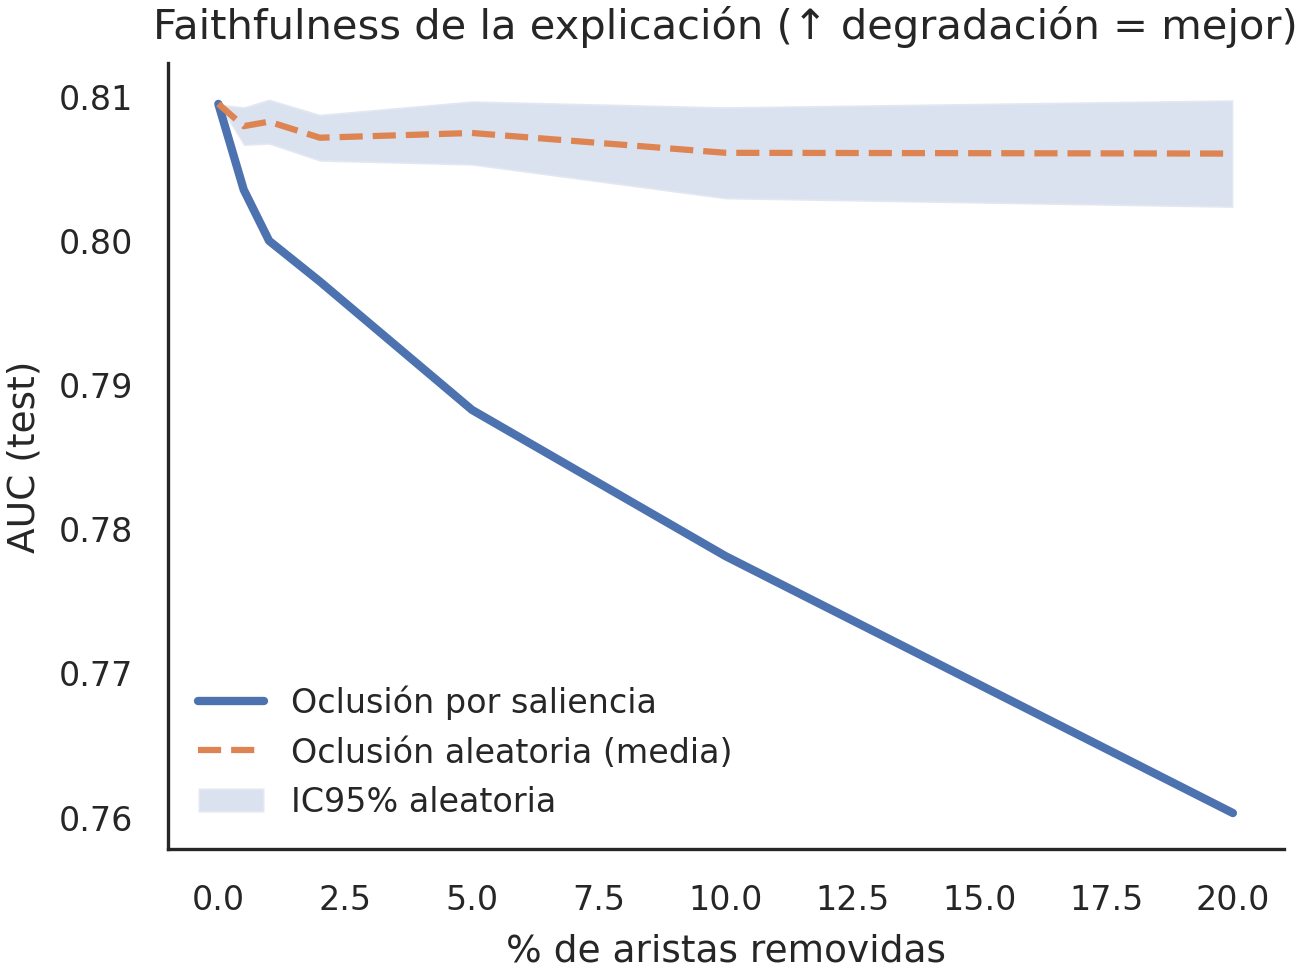

In [33]:
# =================== CELDA — PATTERN RECOGNITION INDEX (PRI) ===================
# Requiere: df_full con 'fold','Rank','Saliency_Signed','idx_i','idx_j'
#           fold_indices, ConvolutionalVAE, apply_normalization_params, pipelines cargados como en tu Celda A
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import t

assert {'fold','Rank','Saliency_Signed','idx_i','idx_j'}.issubset(df_full.columns), "df_full le faltan columnas."

percents = [0, 0.5, 1, 2, 5, 10, 20]  # % del total de aristas removidas
N_RANDOM = 20                         # corridas aleatorias para IC95
MASK_VALUE = 0.0                      # valor de oclusión (0 tras normalizar funciona bien)

def _upper_edges(R):
    # lista de (i,j) con i<j
    return [(i,j) for i in range(R) for j in range(i+1,R)]

R = global_tensor_data.shape[-1]
ALL_EDGES = _upper_edges(R)
N_EDGES = len(ALL_EDGES)


# --- INICIO DE CORRECCIÓN 1 ---
def mask_edges_raw(tensor_raw, edges_to_zero):
    """tensor_raw: [n_subj, n_chan, R, R] raw y PRE-SLICED (ya tiene solo los canales de interés).
       Devuelve un nuevo tensor con (i,j)/(j,i) a 0 en TODOS los canales de entrada.
    """
    X = tensor_raw.copy()
    # Enmascaramos todos los canales presentes en el tensor (que ya fue filtrado)
    for (i,j) in edges_to_zero:
        X[:, :, i, j] = MASK_VALUE # Usar ':' para todos los canales
        X[:, :, j, i] = MASK_VALUE
    return X
# --- FIN DE CORRECCIÓN 1 ---


def auc_after_mask(fold, edges_to_zero):
    # test set del fold
    fold_dir = BASE_RUN_DIR / f"fold_{fold}"
    pipe = joblib.load(fold_dir / f"classifier_{CLF}_pipeline_fold_{fold}.joblib")
    vae_model = ConvolutionalVAE(
        input_channels=len(CHANNELS_TO_USE),
        latent_dim=run_args['latent_dim'],
        image_size=global_tensor_data.shape[-1],
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'],
        use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{fold}.pt", map_location=device))
    vae_model.eval()
    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

    test_idx = fold_indices[fold]['test']
    df_te = cnad_df.iloc[test_idx]
    y_true = df_te['ResearchGroup_Mapped'].map({'CN':0,'AD':1}).values

    gidx = df_te['tensor_idx'].values
    Xraw = global_tensor_data[gidx][:, CHANNELS_TO_USE, :, :]
    
    # --- INICIO DE CORRECCIÓN 2 ---
    # aplicar máscara en raw y luego normalizar (respeta tu pipeline)
    Xraw_mask = mask_edges_raw(Xraw, edges_to_zero) # <-- MODIFICADO: no pasar channels
    # --- FIN DE CORRECCIÓN 2 ---
    
    Xnorm = apply_normalization_params(Xraw_mask, norm_params)

    with torch.no_grad():
        mu, _ = vae_model.encode(torch.from_numpy(Xnorm).float().to(device))
        Z = mu.cpu().numpy()

    meta_cols = run_args['metadata_features']
    meta_te = df_te[meta_cols].copy()
    if 'Sex' in meta_cols:
        meta_te['Sex'] = meta_te['Sex'].map({'M':0,'F':1})
    for c in meta_cols:
        meta_te[c] = meta_te[c].fillna(meta_te[c].median() if pd.api.types.is_numeric_dtype(meta_te[c]) else meta_te[c].mode().iloc[0])
    X = np.hstack([Z, meta_te[meta_cols].values])

    y_prob = pipe.predict_proba(X)[:,1]
    if len(np.unique(y_true)) < 2: 
        return np.nan
    return roc_auc_score(y_true, y_prob)

# --- Curvas de degradación por fold ---
rows = []
for f in range(1, N_FOLDS+1):
    # baseline sin máscara
    auc0 = auc_after_mask(f, [])
    # ranking por fold
    df_f = df_full[df_full['fold'] == f].sort_values('Rank')
    ranked_edges = df_f[['idx_i','idx_j']].drop_duplicates().to_records(index=False)
    ranked_edges = [(int(i),int(j)) for i,j in ranked_edges]

    for p in percents:
        K = int(round(p/100.0 * N_EDGES))
        topK = ranked_edges[:K] if K>0 else []
        auc_top = auc_after_mask(f, topK)
        # aleatorio (media ± IC95)
        auc_rands = []
        rng = np.random.default_rng(17)
        for _ in range(N_RANDOM):
            randK = rng.choice(len(ALL_EDGES), size=K, replace=False) if K>0 else []
            edges_rand = [ALL_EDGES[i] for i in randK] if K>0 else []
            auc_rands.append(auc_after_mask(f, edges_rand))
        auc_rand_mean = np.nanmean(auc_rands) if len(auc_rands) else auc0
        auc_rand_sd   = np.nanstd(auc_rands, ddof=1) if len(auc_rands)>1 else 0.0
        ci = t.ppf(0.975, df=max(len(auc_rands)-1,1)) * (auc_rand_sd/np.sqrt(max(len(auc_rands),1)))

        # AUDC insumo: degradación respecto a baseline
        rows.append({
            'fold': f, 'percent': p, 'AUC0': auc0,
            'AUC_sal': auc_top, 'AUC_rand_mean': auc_rand_mean, 'AUC_rand_ci95': ci
        })
df_pri = pd.DataFrame(rows)

# --- Índice PRI por fold: área (trapz) de degradación (AUC0 - AUC(p)) vs % ---
def _area_deg(vs_percent, auc0, auc_vec):
    deg = np.maximum(auc0 - np.array(auc_vec), 0.0)
    x = np.array(vs_percent)/100.0
    return np.trapz(deg, x)

pri_rows = []
for f, g in df_pri.groupby('fold'):
    auc0 = g['AUC0'].iloc[0]
    area_sal = _area_deg(g['percent'], auc0, g['AUC_sal'])
    area_rnd = _area_deg(g['percent'], auc0, g['AUC_rand_mean'])
    # z-score usando la amplitud del IC como ruido (aprox conservadora)
    sd_rnd  = (g['AUC_rand_ci95'].abs().max() / t.ppf(0.975, df=max(N_RANDOM-1,1))) if (g['AUC_rand_ci95']>0).any() else 1e-6
    PRI_z = (area_sal - area_rnd) / max(sd_rnd, 1e-6)
    pri_rows.append({'fold': f, 'AUDC_sal': area_sal, 'AUDC_rand': area_rnd, 'PRI_z': PRI_z})

df_PRI = pd.DataFrame(pri_rows)
print("PRI por fold (z-score, >0 = explicaciones con alta fidelidad):")
display(df_PRI.assign(PRI_z=lambda d: d['PRI_z'].round(2)))

# --- Figura: Curva AUC vs % removido (promedio de folds) ---
plot_df = (df_pri
           .groupby('percent', as_index=False)
           .agg(AUC_sal=('AUC_sal','mean'),
                AUC_rand_mean=('AUC_rand_mean','mean'),
                AUC_rand_ci95=('AUC_rand_ci95','mean')))

fig, ax = plt.subplots(figsize=(4.8,3.4))
ax.plot(plot_df['percent'], plot_df['AUC_sal'], lw=2, label='Oclusión por saliencia')
ax.plot(plot_df['percent'], plot_df['AUC_rand_mean'], lw=1.5, ls='--', label='Oclusión aleatoria (media)')
ax.fill_between(plot_df['percent'],
                plot_df['AUC_rand_mean']-plot_df['AUC_rand_ci95'],
                plot_df['AUC_rand_mean']+plot_df['AUC_rand_ci95'],
                alpha=0.2, label='IC95% aleatoria')
ax.set_xlabel('% de aristas removidas'); ax.set_ylabel('AUC (test)')
ax.set_title('Faithfulness de la explicación (↑ degradación = mejor)')
ax.legend(frameon=False)
savefig_nature(fig, FIG_DIR / "fig4_faithfulness_pri")
plt.show()

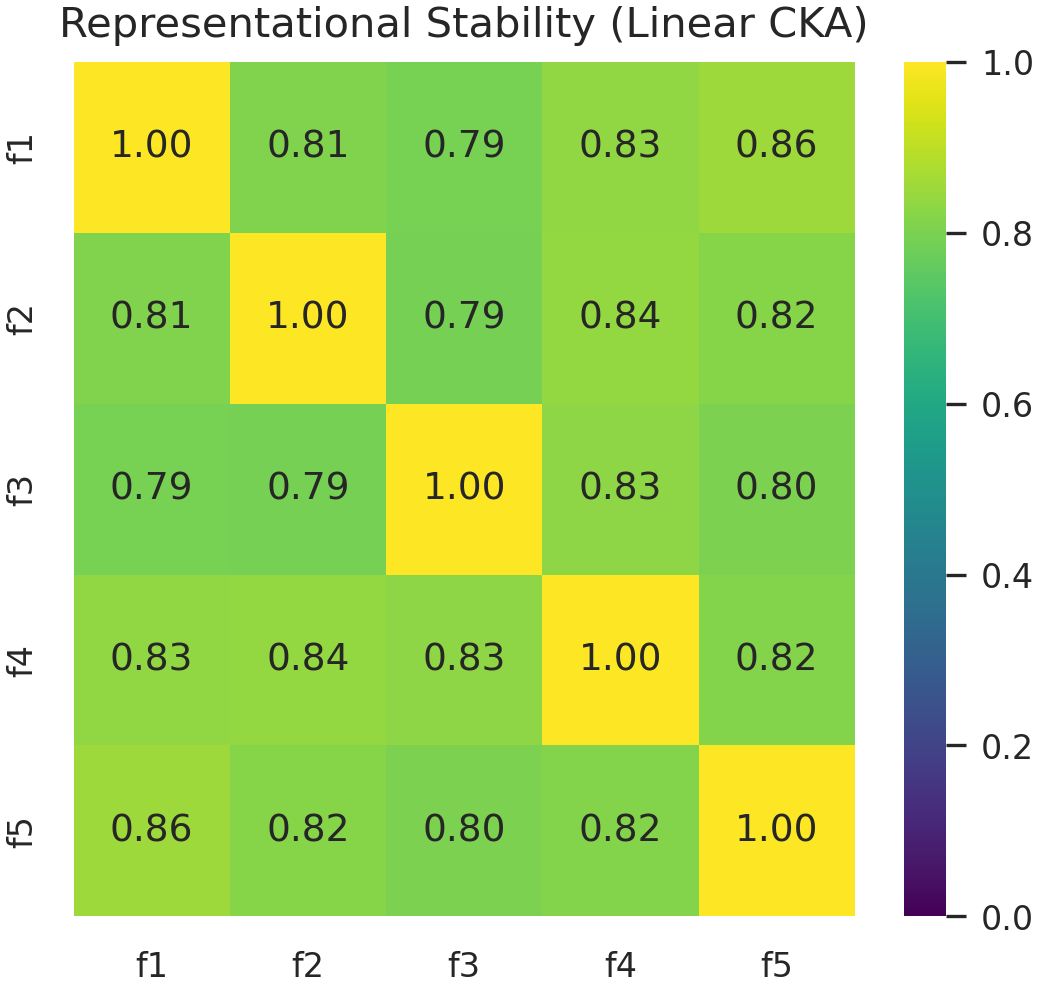

CKA medio fuera de la diagonal: 0.8191950372626333


In [34]:
# =============== CELDA — CKA ENTRE FOLDS (LATENT REPRESENTATION) ===============
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

def linear_cka(X, Y):
    # X:[n,d], Y:[n,d2], centrado implícito mediante Gram centrado
    def _center_gram(K):
        n = K.shape[0]
        H = np.eye(n) - np.ones((n,n))/n
        return H @ K @ H
    K = X @ X.T
    L = Y @ Y.T
    Kc, Lc = _center_gram(K), _center_gram(L)
    hsic = np.sum(Kc*Lc)
    norm = np.sqrt(np.sum(Kc*Kc) * np.sum(Lc*Lc)) + 1e-12
    return float(hsic / norm)

# Codificamos TODOS los CN/AD con cada VAE
Z_by_fold = {}
for f in range(1, N_FOLDS+1):
    fold_dir = BASE_RUN_DIR / f"fold_{f}"
    vae_model = ConvolutionalVAE(
        input_channels=len(CHANNELS_TO_USE),
        latent_dim=run_args['latent_dim'],
        image_size=global_tensor_data.shape[-1],
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'],
        use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{f}.pt", map_location=device))
    vae_model.eval()
    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

    gidx = cnad_df['tensor_idx'].values
    Xraw = global_tensor_data[gidx][:, CHANNELS_TO_USE, :, :]
    Xnorm = apply_normalization_params(Xraw, norm_params)
    with torch.no_grad():
        mu, _ = vae_model.encode(torch.from_numpy(Xnorm).float().to(device))
        Z_by_fold[f] = mu.cpu().numpy()

# Matriz CKA (fold x fold)
F = sorted(Z_by_fold.keys())
M = np.zeros((len(F), len(F)))
for i, fi in enumerate(F):
    for j, fj in enumerate(F):
        M[i,j] = linear_cka(Z_by_fold[fi], Z_by_fold[fj])

fig, ax = plt.subplots(figsize=(4.2,3.7))
sns.heatmap(M, vmin=0, vmax=1, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=[f"f{f}" for f in F], yticklabels=[f"f{f}" for f in F], ax=ax)
ax.set_title("Representational Stability (Linear CKA)")
savefig_nature(fig, FIG_DIR / "fig5_latent_cka")
plt.show()

print("CKA medio fuera de la diagonal:", np.nanmean(M[np.triu_indices_from(M,1)]))


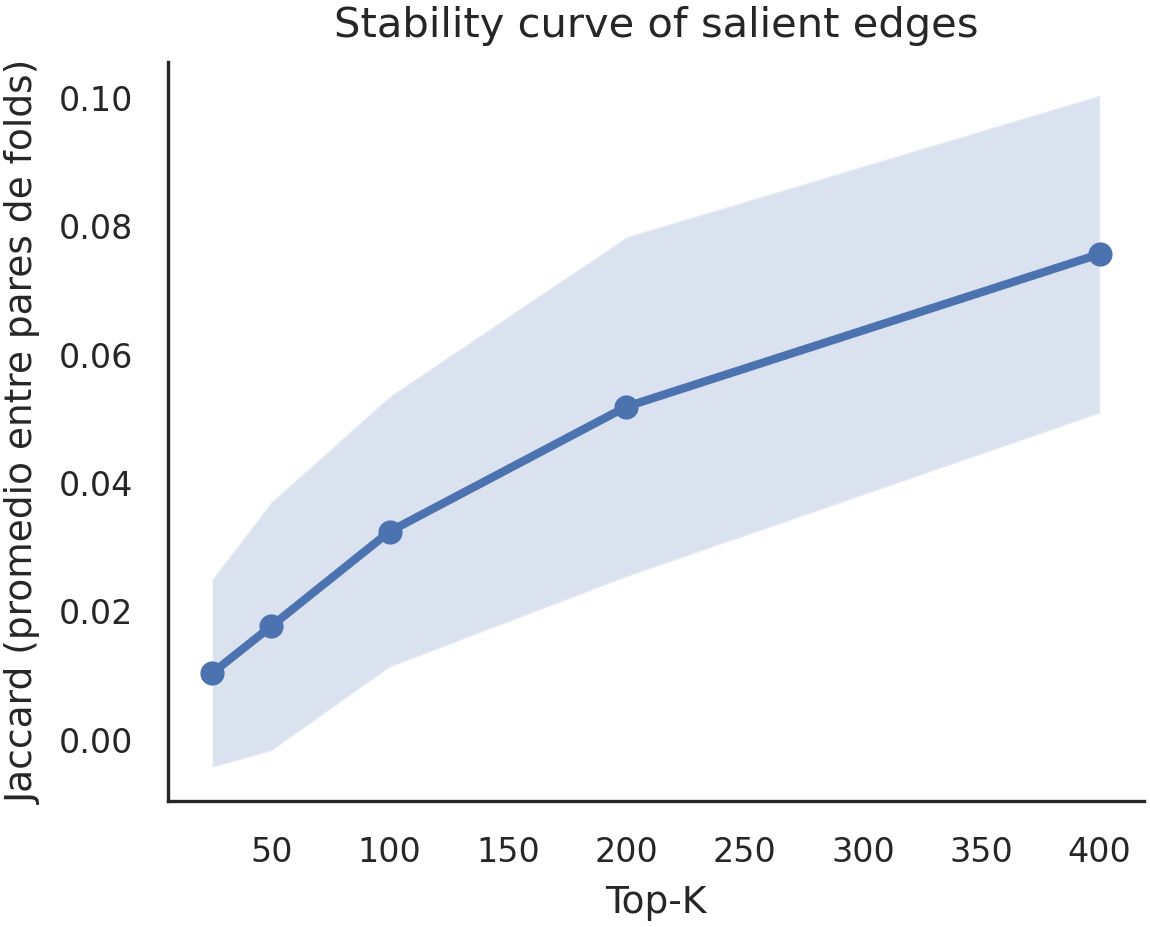

Concordancia de ranking (Kendall τ) top-500: 0.10


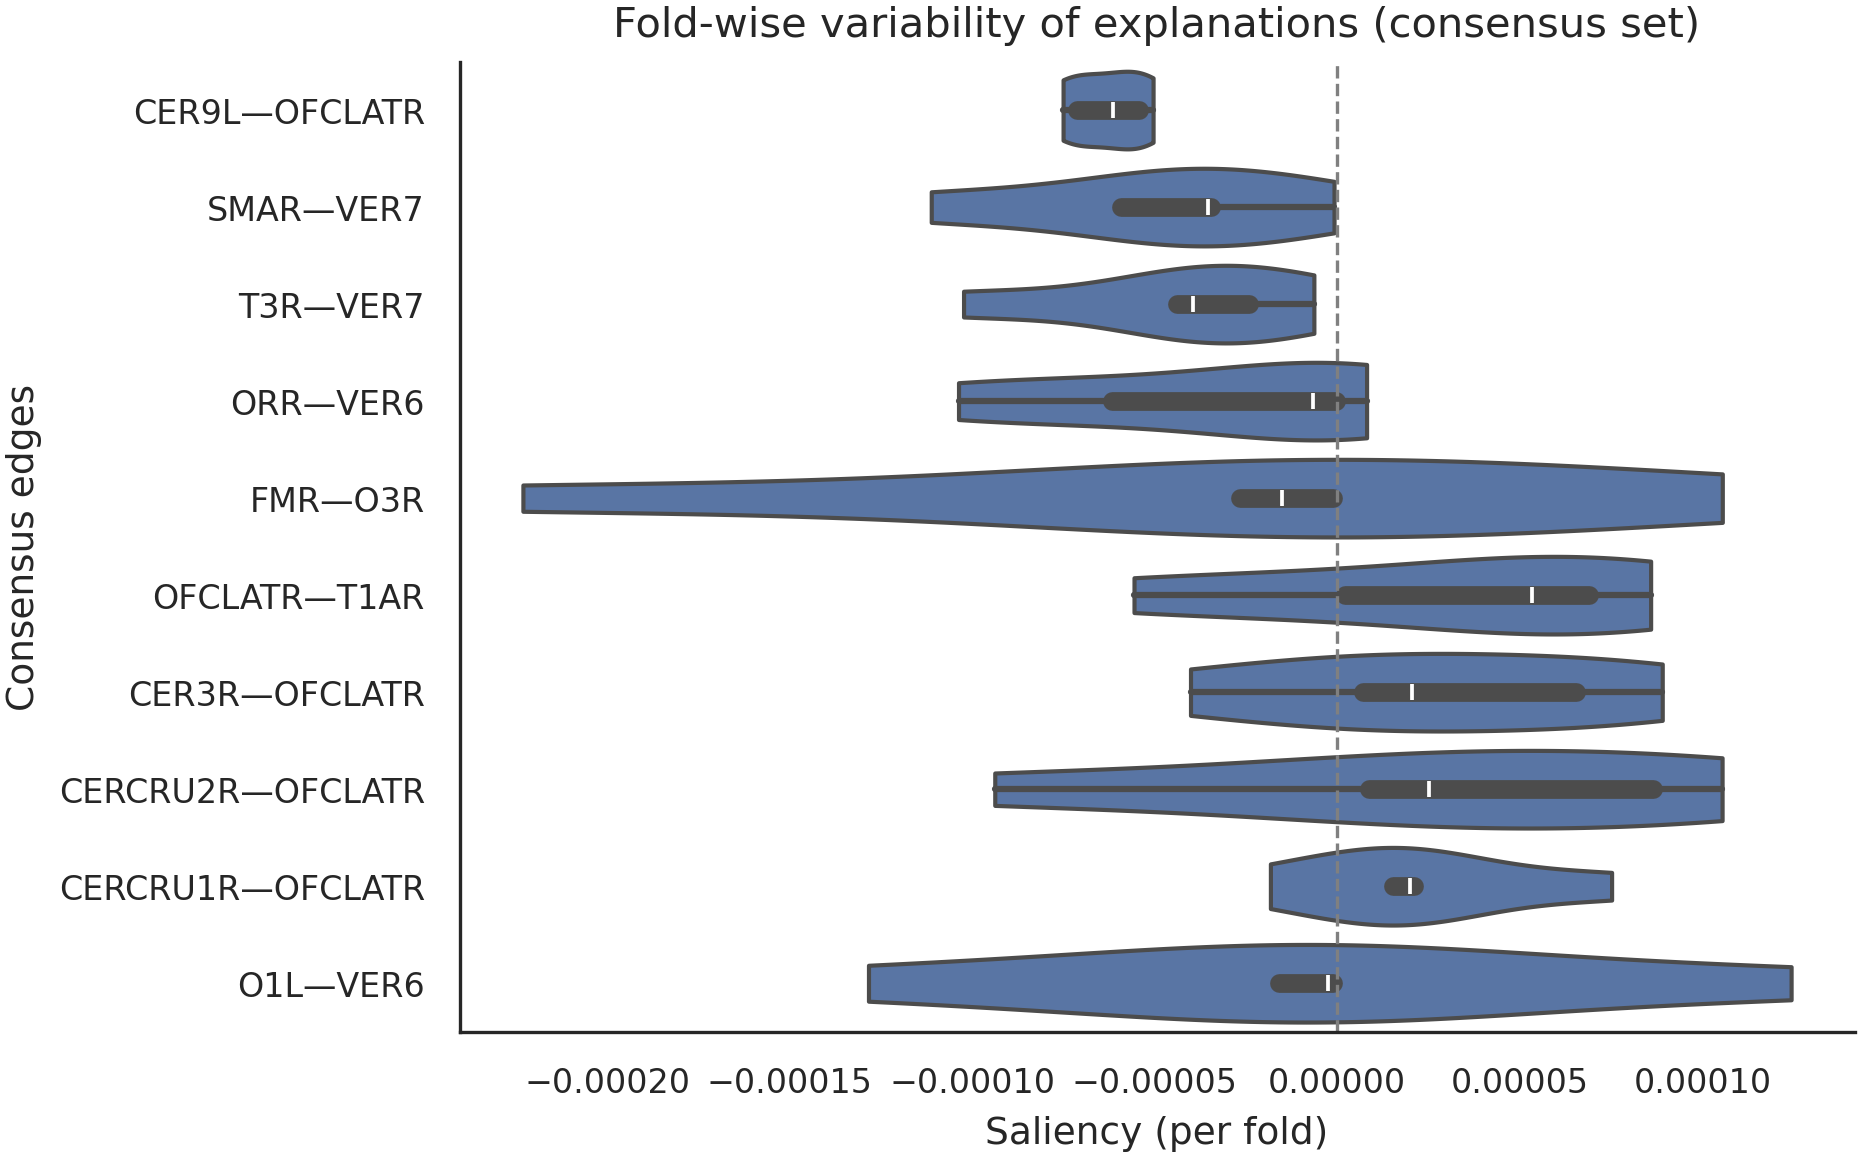

In [35]:
# ======= CELDA — VARIABILIDAD DE INTERPRETABILIDAD/EXPLICABILIDAD ENTRE FOLDS =======
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from itertools import combinations
from scipy.stats import kendalltau

# --- 1) Curvas de estabilidad de ranking: Jaccard(top-K) promedio entre pares de folds
Kgrid = [25, 50, 100, 200, 400]
pair_vals = {K: [] for K in Kgrid}
for f1, f2 in combinations(range(1, N_FOLDS+1), 2):
    r1 = df_full[df_full['fold']==f1].sort_values('Rank').drop_duplicates('connection_id')
    r2 = df_full[df_full['fold']==f2].sort_values('Rank').drop_duplicates('connection_id')
    s1 = r1['connection_id'].tolist()
    s2 = r2['connection_id'].tolist()
    for K in Kgrid:
        A = set(s1[:K]); B = set(s2[:K])
        j = len(A&B) / max(len(A|B),1)
        pair_vals[K].append(j)
        
stab_df = pd.DataFrame({'K': Kgrid,
                        'Jaccard_mean': [np.mean(pair_vals[K]) for K in Kgrid],
                        'Jaccard_sd':   [np.std(pair_vals[K], ddof=1) for K in Kgrid]})
                        
fig, ax = plt.subplots(figsize=(4.2,3.2))
ax.plot(stab_df['K'], stab_df['Jaccard_mean'], lw=2, marker='o')
ax.fill_between(stab_df['K'],
                stab_df['Jaccard_mean']-stab_df['Jaccard_sd'],
                stab_df['Jaccard_mean']+stab_df['Jaccard_sd'], alpha=0.2)
ax.set_xlabel('Top-K'); ax.set_ylabel('Jaccard (promedio entre pares de folds)')
ax.set_title('Stability curve of salient edges')
savefig_nature(fig, FIG_DIR / "fig6_stability_curve_jaccard")
plt.show()

# --- 2) Concordancia de ranking: Kendall τ / W para un conjunto común de aristas
TOPM = 500
# universo = intersección de aristas presentes en todos los folds
edges_all = [set(df_full[df_full['fold']==f]['connection_id']) for f in range(1, N_FOLDS+1)]
univ = sorted(set.intersection(*edges_all))

# tomamos TOPM por ranking de un fold de referencia y restringimos al universo
ref = (df_full[df_full['fold']==1].sort_values('Rank')
       .query("connection_id in @univ").head(TOPM)['connection_id'].tolist())
E = ref if len(ref)>=TOPM else univ[:TOPM]

# rank matrix: rows=edges, cols=folds
Rmat = np.zeros((len(E), N_FOLDS), dtype=int)
for j, f in enumerate(range(1, N_FOLDS+1)):
    r = (df_full[df_full['fold']==f]
         .set_index('connection_id')['Rank'].to_dict())
    Rmat[:, j] = [r.get(e, len(r)+1) for e in E]
         
# Kendall tau promedio entre columnas
taus = []
for a,b in combinations(range(N_FOLDS),2):
    t,_ = kendalltau(Rmat[:,a], Rmat[:,b])
    taus.append(t)
tau_mean = np.nanmean(taus)
print(f"Concordancia de ranking (Kendall τ) top-{TOPM}: {tau_mean:.2f}")

# --- 3) Forest/violin: dispersión por fold de las aristas del consenso
cons = consensus_set.index.tolist()
df_forest = (df_full[df_full['connection_id'].isin(cons)]
             .groupby(['connection_id','fold'])['Saliency_Signed'].mean().reset_index())

# --- INICIO DE CORRECCIÓN ---
# Convertir 'connection_id' (tupla) a string para evitar error de MultiIndex en Seaborn
df_forest['connection_id_str'] = df_forest['connection_id'].apply(lambda t: f"{t[0]}—{t[1]}")

# ordenar por |media| (usando el nuevo 'connection_id_str' para agrupar)
order = (df_forest.groupby('connection_id_str')['Saliency_Signed'].mean()
         .abs().sort_values(ascending=False).index.tolist())
         
fig, ax = plt.subplots(figsize=(6,4.2))
# Usar la nueva columna 'connection_id_str' para el eje 'y'
sns.violinplot(data=df_forest, y='connection_id_str', x='Saliency_Signed',
               order=order, inner='box', cut=0, scale='width', ax=ax)
# --- FIN DE CORRECCIÓN ---
               
ax.axvline(0, ls='--', c='gray', lw=0.8)
ax.set_ylabel('Consensus edges'); ax.set_xlabel('Saliency (per fold)')
ax.set_title('Fold-wise variability of explanations (consensus set)')
savefig_nature(fig, FIG_DIR / "fig6_variability_violin_consensus")
plt.show()

In [36]:
# ======= CELDA OPCIONAL — EIP via bootstrap estratificado (requiere IG por sujeto) =======
# df_rank_by_fold: {fold -> DataFrame con index=edge y columna 'Rank' o 'score'}
# subj_IG_by_fold: {fold -> DataFrame [n_subj x n_edges] con |IG|}
# strata_df: DataFrame [n_subj x 2] con columnas p.ej. ['Manufacturer','Sex'] alineado a sujetos CN/AD
from sklearn.utils import check_random_state

def eip_bootstrap(df_rank_by_fold, subj_IG_by_fold, strata_df, K=200, B=1000, seed=13):
    rng = check_random_state(seed)
    # universo de edges candidatos (union top-K original)
    edges = sorted(set.union(*[set(df.head(K).index) for df in df_rank_by_fold.values()]))
    e2i = {e:i for i,e in enumerate(edges)}
    cnt = np.zeros(len(edges), dtype=int)

    # precomputo estratos
    keys = list(zip(strata_df['Manufacturer'], strata_df['Sex']))
    uniq = sorted(set(keys))
    idx_by = {u: np.where([k==u for k in keys])[0] for u in uniq}

    for _ in range(B):
        # remuestreo sujetos *dentro de* cada estrato
        boot_idx = []
        for u, idx in idx_by.items():
            if len(idx)==0: continue
            boot_idx.extend(rng.choice(idx, size=len(idx), replace=True))
        boot_idx = np.array(boot_idx, dtype=int)

        # recomputa ranking meta agregando |IG| por sujeto bootstrapeado
        scores = pd.Series(0.0, index=edges)
        for f, M in subj_IG_by_fold.items():
            # promedio |IG| en bootstrap
            s = M.iloc[boot_idx].mean(axis=0)
            s = s.reindex(scores.index).fillna(0.0)
            scores += s.values
        top = set(scores.sort_values(ascending=False).head(K).index)
        for e in top: cnt[e2i[e]] += 1

    return pd.Series(cnt/B, index=edges, name='EIP')

# eip = eip_bootstrap(df_rank_by_fold, subj_IG_by_fold, strata_df, K=200, B=1000)
# eip.to_csv(TBL_DIR / "TableS_EIP.csv")
